# Competition Solution: Кредитный скоринг

# Решение тестовго технического задания от SHIFT

## Задача бинарной классификации с метрикой ROC-AUC

## 1. Импорт библиотек и настройка

In [2]:
from typing import List, Tuple, Dict, Optional, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Модели
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Ансамбли
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Дополнительные
from datetime import datetime
import joblib
import zipfile
import os

# Настройки
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.8f' % x)

RANDOM_STATE = 42

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


## 2. Загрузка данных

In [3]:
print("Загрузка данных из тренировочного файла...")
train: pd.DataFrame = pd.read_csv('../data/shift_ml_2026_train.csv')
train

Загрузка данных из тренировочного файла...


id      сумма_займа срок_займа  процентная_ставка  \
0        68355089 1235000.00000000     3 года        11.99000000   
1        68341763 1000000.00000000      5 лет        10.78000000   
2        68426831  597500.00000000     3 года        13.44000000   
3        68476668 1000000.00000000     3 года         9.17000000   
4        67275481 1000000.00000000     3 года         8.49000000   
...           ...              ...        ...                ...   
1210774  89905081  900000.00000000      5 лет         9.49000000   
1210775  88948836 1470000.00000000      5 лет        13.99000000   
1210776  89996426 1600000.00000000      5 лет        14.49000000   
1210777  90006534  800000.00000000      5 лет        12.79000000   
1210778  88224441 1200000.00000000      5 лет        14.49000000   

              аннуитет рейтинг допрейтинг  \
0       41014.00000000       В         В1   
1       21633.00000000       Б         Б4   
2       20259.00000000       В         В3   
3       31879.00000000       Б         Б2   
4       31563.00000000       Б         Б1   
...                ...     ...        ...   
1210774 18897.50000000       Б         Б2   
1210775 34197.00000000       В         В3   
1210776 37637.00000000       В         В4   
1210777 18117.00000000       В         В1   
1210778 28228.00000000       В         В4   

                                  профессия_заемщика     стаж владение_жильем  \
0                                            инженер  10+ лет         ИПОТЕКА   
1                                 водитель грузовика  10+ лет         ИПОТЕКА   
2                                ветеринарный техник   4 года          АРЕНДА   
3        вице-президент операций по набору персонала  10+ лет         ИПОТЕКА   
4                                 дорожному водителю  10+ лет         ИПОТЕКА   
...                                              ...      ...             ...   
1210774                                          NaN    5 лет   СОБСТВЕННОСТЬ   
1210775                главный оперативный сотрудник    9 лет         ИПОТЕКА   
1210776                         менеджер по продажам   3 года         ИПОТЕКА   
1210777                                     менеджер  10+ лет          АРЕНДА   
1210778                       руководитель программы    6 лет          АРЕНДА   

           годовой_доход  подтвержден_ли_доход  итоговый_статус_займа  \
0       1300000.00000000        Не подтвержден                      0   
1       1260000.00000000        Не подтвержден                      0   
2        680000.00000000  Подтвержден источник                      0   
3       3600000.00000000        Не подтвержден                      0   
4       1700000.00000000        Не подтвержден                      0   
...                  ...                   ...                    ...   
1210774 2600000.00000000        Не подтвержден                      0   
1210775 3615840.00000000        Не подтвержден                      0   
1210776 3140000.00000000  Подтвержден источник                      1   
1210777 3000000.00000000        Не подтвержден                      0   
1210778 2200000.00000000        Не подтвержден                      1   

         рейтинг_OCR платежный_график  коэфф_акционных_зачислений_в_остатке  \
0                  4                n                            0.89916772   
1                  2                n                            0.48989072   
2                  3                n                            0.93866225   
3                  1                n                            0.86817745   
4                  4                n                            0.24925409   
...              ...              ...                                   ...   
1210774            2                n                            0.10150046   
1210775            3                n                            0.97712302   
1210776            1                n                            0.10820712   
1210777          

In [4]:
print("Загрузка данных из тестового файла...")
test: pd.DataFrame = pd.read_csv('../data/shift_ml_2026_test.csv')
test

Загрузка данных из тестового файла...


id      сумма_займа срок_займа  процентная_ставка  \
0       85540387  450000.00000000     3 года         9.49000000   
1       28112500  400000.00000000     3 года         6.03000000   
2       65731570 1250000.00000000     3 года        12.05000000   
3       65874747  977500.00000000      5 лет        20.99000000   
4       57893355  520000.00000000     3 года        18.25000000   
...          ...              ...        ...                ...   
134526  72082596  280000.00000000     3 года        13.67000000   
134527    484702  700000.00000000     3 года        10.25000000   
134528  73273241 1500000.00000000     3 года        12.99000000   
134529  50466330 1070000.00000000     3 года        15.61000000   
134530  46350249  798750.00000000     3 года        16.99000000   

             аннуитет рейтинг допрейтинг  \
0      14413.00000000       Б         Б2   
1      12174.50000000       А         А1   
2      41548.00000000       В         В1   
3      26439.50000000       Д         Д5   
4      18865.00000000       Д         Д1   
...               ...     ...        ...   
134526  9525.00000000       В         В3   
134527 22669.50000000       Б         Б2   
134528 50534.00000000       В         В2   
134529 37412.50000000       Г         Г1   
134530 28474.00000000       Г         Г3   

                                       профессия_заемщика     стаж  \
0                                   обслуживание клиентов  10+ лет   
1                           помощник по правовым вопросам    5 лет   
2                специалист по анализу кредитоспособности    5 лет   
3                                  специальный специалист   3 года   
4                          руководитель районного проекта   3 года   
...                                                   ...      ...   
134526                              хирургические продажи   4 года   
134527                              &quot; е2 инк. &quot;   4 года   
134528  сертифицированный сотрудник по финансовому пла...  10+ лет   
134529                                           владелец  10+ лет   
134530                                              повар    6 лет   

       владение_жильем    годовой_доход  подтвержден_ли_доход  рейтинг_OCR  \
0              ИПОТЕКА  840000.00000000        Не подтвержден            4   
1               АРЕНДА 1520000.00000000        Не подтвержден            4   
2              ИПОТЕКА 1250000.00000000        Не подтвержден            1   
3              ИПОТЕКА 1020000.00000000           Подтвержден            4   
4               АРЕНДА 1000000.00000000           Подтвержден            2   
...                ...              ...                   ...          ...   
134526          АРЕНДА 5200000.00000000  Подтвержден источник            4   
134527          АРЕНДА 1250000.00000000        Не подтвержден            4   
134528          АРЕНДА 1600000.00000000  Подтвержден источник            2   
134529         ИПОТЕКА 1070000.00000000        Не подтвержден            3   
134530         ИПОТЕКА  800000.00000000        Не подтвержден            1   

       платежный_график  коэфф_акционных_зачислений_в_остатке  \
0                     n                            0.45894745   
1                     n                            0.00696409   
2                     n                            0.48500615   
3                     n                            0.30867189   
4                     n                            0.24980605   
...                 ...                                   ...   
134526                n                            0.15573715   
134527                n                            0.89973773   
134528                n                            0.81257616   
134529                n                            0.65343908   
134530                n                            0.52985743   

                цель_займа  кол_во_субсидий_за_год  индекс_проживания  \
0       консолидация_долга                      

In [5]:
print(f"Размер train: {train.shape}")
print(f"Размер test: {test.shape}")

Размер train: (1210779, 109)
Размер test: (134531, 108)


### Первичный осмотр

#### Первые строки train файла

In [6]:
print("\nПервые 10 строк train:")
display(train.head(10))


Первые 10 строк train:


id      сумма_займа срок_займа  процентная_ставка       аннуитет  \
0  68355089 1235000.00000000     3 года        11.99000000 41014.00000000   
1  68341763 1000000.00000000      5 лет        10.78000000 21633.00000000   
2  68426831  597500.00000000     3 года        13.44000000 20259.00000000   
3  68476668 1000000.00000000     3 года         9.17000000 31879.00000000   
4  67275481 1000000.00000000     3 года         8.49000000 31563.00000000   
5  68466926  500000.00000000     3 года         6.49000000 15322.50000000   
6  68616873  400000.00000000     3 года        11.48000000 13187.00000000   
7  68338832   70000.00000000     3 года        12.88000000  2355.00000000   
8  66624733  900000.00000000      5 лет        19.48000000 23585.00000000   
9  68466961 1400000.00000000     3 года         6.49000000 42902.50000000   

  рейтинг допрейтинг                                 профессия_заемщика  \
0       В         В1                                            инженер   
1       Б         Б4                                 водитель грузовика   
2       В         В3                                ветеринарный техник   
3       Б         Б2        вице-президент операций по набору персонала   
4       Б         Б1                                 дорожному водителю   
5       А         А2                                управление услугами   
6       Б         Б5                               связь с поставщиками   
7       В         В2  руководитель материально-технического обеспечения   
8       Д         Д2                  менеджер программного обеспечения   
9       А         А2                               старший руководитель   

      стаж владение_жильем    годовой_доход  подтвержден_ли_доход  \
0  10+ лет         ИПОТЕКА 1300000.00000000        Не подтвержден   
1  10+ лет         ИПОТЕКА 1260000.00000000        Не подтвержден   
2   4 года          АРЕНДА  680000.00000000  Подтвержден источник   
3  10+ лет         ИПОТЕКА 3600000.00000000        Не подтвержден   
4  10+ лет         ИПОТЕКА 1700000.00000000        Не подтвержден   
5    6 лет          АРЕНДА 1700000.00000000        Не подтвержден   
6  10+ лет         ИПОТЕКА  840000.00000000        Не подтвержден   
7   3 года         ИПОТЕКА 1280000.00000000        Не подтвержден   
8    7 лет          АРЕНДА 3000000.00000000        Не подтвержден   
9  10+ лет         ИПОТЕКА 1840000.00000000        Не подтвержден   

   итоговый_статус_займа  рейтинг_OCR платежный_график  \
0                      0            4                n   
1                      0            2                n   
2                      0            3                n   
3                      0            1                n   
4                      0            4                n   
5                      0            2                n   
6                      0            3                n   
7                      0            1                n   
8                      1            3                n   
9                      0            2                n   

   коэфф_акционных_зачислений_в_остатке                  цель_займа  \
0                            0.89916772               мелкий_бизнес   
1                            0.48989072  улучшение_жилищных_условий   
2                            0.93866225          консолидация_долга   
3                            0.86817745          консолидация_долга   
4                            0.24925409             крупная_покупка   
5                            0.37317465             кредитная_карта   
6                            0.33389351             кредитная_карта   
7                            0.05980593                      другое   
8                            0.71817205          консолидация_долга   
9                            0.90454670          консолидация_долга   

   кол_во_субсидий_за_год  индекс_проживания                   регион  \
0                       0       577.00000000     Новгородская область   
1       

#### Получение информации из train файла

In [7]:
print("\nИнформация о данных train:")
train.info()


Информация о данных train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(19)
memory usage: 1006.9+ MB


#### Информация о названиях колонок и типов данных в тренировочном датафрейме

In [8]:
print(f"\nКолонки в train: {train.columns.tolist()}")
print(f"\nТипы данных:\n{train.dtypes.value_counts()}")


Колонки в train: ['id', 'сумма_займа', 'срок_займа', 'процентная_ставка', 'аннуитет', 'рейтинг', 'допрейтинг', 'профессия_заемщика', 'стаж', 'владение_жильем', 'годовой_доход', 'подтвержден_ли_доход', 'итоговый_статус_займа', 'рейтинг_OCR', 'платежный_график', 'коэфф_акционных_зачислений_в_остатке', 'цель_займа', 'кол_во_субсидий_за_год', 'индекс_проживания', 'регион', 'пдн', 'пос_стоп_фактор', 'юридический_статус', 'кол-во_просрочек_за_два_года', 'коэфф_невыплаченного_сумм_остатка', 'коэфф_исходного_платежа', 'дата_первого_займа', 'нижний_порог_рейтинга_заемщика', 'верхний_порог_рейтинга_заемщика', 'кол-во_заявок_за_полгода', 'кол-во_месяцев_с_последней_просрочки', 'кол-во_месяцев_с_последнего_займа', 'кол-во_открытых_счетов', 'кол-во_записей_в_общедоступных_документах', 'оборотный_баланс', 'коэфф_загрузки_возобновляемого_счета', 'кол-во_счетов', 'первоначальный_статус_займа', 'непогашенная_сумма_из_тела_займов', 'сумма_выплат_по_просрочкам', 'пени_за_дефолт', 'дата_следующей_выплаты

#### Первые строки test файла

In [9]:
print("\nПервые 10 строк test:")
display(test.head(10))


Первые 10 строк test:


id      сумма_займа срок_займа  процентная_ставка       аннуитет  \
0  85540387  450000.00000000     3 года         9.49000000 14413.00000000   
1  28112500  400000.00000000     3 года         6.03000000 12174.50000000   
2  65731570 1250000.00000000     3 года        12.05000000 41548.00000000   
3  65874747  977500.00000000      5 лет        20.99000000 26439.50000000   
4  57893355  520000.00000000     3 года        18.25000000 18865.00000000   
5  80589347 1000000.00000000     3 года        14.46000000 34401.50000000   
6  36381174 1750000.00000000     3 года        10.49000000 56871.50000000   
7    624831  320000.00000000      5 лет        15.57000000  7709.00000000   
8  44065675  493750.00000000     3 года        15.61000000 17264.00000000   
9    771518 1062500.00000000      5 лет        12.99000000 24170.00000000   

  рейтинг допрейтинг                        профессия_заемщика      стаж  \
0       Б         Б2                     обслуживание клиентов   10+ лет   
1       А         А1             помощник по правовым вопросам     5 лет   
2       В         В1  специалист по анализу кредитоспособности     5 лет   
3       Д         Д5                    специальный специалист    3 года   
4       Д         Д1            руководитель районного проекта    3 года   
5       В         В4                                   инженер     5 лет   
6       Б         Б3                    управляющий контрактом  < 1 года   
7       Г         Г5                         очищенные бридеры     1 год   
8       Г         Г1                           видеопереводчик    3 года   
9       В         В1                                       NaN       NaN   

  владение_жильем    годовой_доход  подтвержден_ли_доход  рейтинг_OCR  \
0         ИПОТЕКА  840000.00000000        Не подтвержден            4   
1          АРЕНДА 1520000.00000000        Не подтвержден            4   
2         ИПОТЕКА 1250000.00000000        Не подтвержден            1   
3         ИПОТЕКА 1020000.00000000           Подтвержден            4   
4          АРЕНДА 1000000.00000000           Подтвержден            2   
5          АРЕНДА 2200000.00000000  Подтвержден источник            2   
6         ИПОТЕКА 2600000.00000000           Подтвержден            4   
7          АРЕНДА  540000.00000000        Не подтвержден            3   
8         ИПОТЕКА  820000.00000000        Не подтвержден            3   
9         ИПОТЕКА  834000.00000000           Подтвержден            1   

  платежный_график  коэфф_акционных_зачислений_в_остатке          цель_займа  \
0                n                            0.45894745  консолидация_долга   
1                n                            0.00696409  консолидация_долга   
2                n                            0.48500615     кредитная_карта   
3                n                            0.30867189  консолидация_долга   
4                n                            0.24980605             переезд   
5                n                            0.00282360       мелкий_бизнес   
6                n                            0.87671939  консолидация_долга   
7                n                            0.61494588  консолидация_долга   
8                n                            0.18472671  консолидация_долга   
9                n                            0.12123337              другое   

   кол_во_субсидий_за_год  индекс_проживания  \
0                       0       601.00000000   
1                       0       112.00000000   
2                       2       611.00000000   
3                       0       606.00000000   
4                       0       605.00000000   
5                       0       907.00000000   
6                       0       337.00000000   
7                       0       330.00000000   
8                       0       282.00000000   
9                       0       487.00000000   

                              регион         пдн пос_стоп_фактор  \
0               Республика Татарстан 19.09

#### Получение информации из test файла

In [10]:
print("\nИнформация о данных test:")
test.info()


Информация о данных test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134531 entries, 0 to 134530
Columns: 108 entries, id to тип_предоставления_кредита
dtypes: float64(85), int64(5), object(18)
memory usage: 110.9+ MB


#### Информация о названиях колонок и типов данных в тестовом датафрейме

In [11]:
print(f"\nКолонки в test: {test.columns.tolist()}")
print(f"\nТипы данных:\n{test.dtypes.value_counts()}")


Колонки в test: ['id', 'сумма_займа', 'срок_займа', 'процентная_ставка', 'аннуитет', 'рейтинг', 'допрейтинг', 'профессия_заемщика', 'стаж', 'владение_жильем', 'годовой_доход', 'подтвержден_ли_доход', 'рейтинг_OCR', 'платежный_график', 'коэфф_акционных_зачислений_в_остатке', 'цель_займа', 'кол_во_субсидий_за_год', 'индекс_проживания', 'регион', 'пдн', 'пос_стоп_фактор', 'юридический_статус', 'кол-во_просрочек_за_два_года', 'коэфф_невыплаченного_сумм_остатка', 'коэфф_исходного_платежа', 'дата_первого_займа', 'нижний_порог_рейтинга_заемщика', 'верхний_порог_рейтинга_заемщика', 'кол-во_заявок_за_полгода', 'кол-во_месяцев_с_последней_просрочки', 'кол-во_месяцев_с_последнего_займа', 'кол-во_открытых_счетов', 'кол-во_записей_в_общедоступных_документах', 'оборотный_баланс', 'коэфф_загрузки_возобновляемого_счета', 'кол-во_счетов', 'первоначальный_статус_займа', 'непогашенная_сумма_из_тела_займов', 'сумма_выплат_по_просрочкам', 'пени_за_дефолт', 'дата_следующей_выплаты', 'грейд_на_детерминаторе

## 3. EDA - Анализ данных

### Анализ целевой переменной

In [12]:
target_col: str = 'итоговый_статус_займа'
print(f"\nРаспределение целевой переменной '{target_col}':")
target_dist: pd.Series = train[target_col].value_counts(normalize=True)
print(target_dist)


Распределение целевой переменной 'итоговый_статус_займа':
итоговый_статус_займа
0   0.80038141
1   0.19961859
Name: proportion, dtype: float64


In [13]:
print(f"\nРаспределение целевой переменной:\n{train[target_col].value_counts(normalize=True)}")


Распределение целевой переменной:
итоговый_статус_займа
0   0.80038141
1   0.19961859
Name: proportion, dtype: float64


### График для анализа результатов целевой переменной

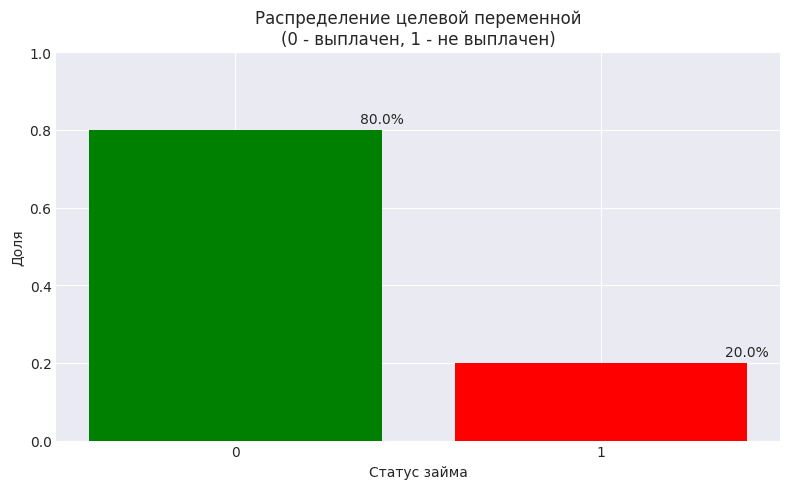

In [14]:
plt.figure(figsize=(8, 5))
bars = plt.bar(target_dist.index.astype(str), target_dist.values, color=['green', 'red'])
plt.title('Распределение целевой переменной\n(0 - выплачен, 1 - не выплачен)')
plt.xlabel('Статус займа')
plt.ylabel('Доля')
plt.ylim(0, 1)
for bar, value in zip(bars, target_dist.values):
    plt.text(bar.get_x() + bar.get_width(), bar.get_height() + 0.01, 
             f'{value:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Анализ пропусков в данных

In [15]:
print("\nАнализ пропусков в данных:")

def analyze_missing(
    df: pd.DataFrame, 
    dataset_name: str
) -> pd.DataFrame:
    missing: pd.Series = df.isnull().sum()
    missing_pct: pd.Series = (missing / len(df)) * 100
    missing_df: pd.DataFrame = pd.DataFrame({
        'missing_count': missing,
        'missing_percent': missing_pct
    }).sort_values('missing_percent', ascending=False)
    
    missing_df: pd.DataFrame = missing_df[missing_df['missing_count'] > 0]
    
    print(f"\n{dataset_name} - колонки с пропусками ({len(missing_df)}):")
    if len(missing_df) > 0:
        display(missing_df.head(40))
        if len(missing_df) > 0:
            plt.figure(figsize=(12, 6))
            missing_df.head(40)['missing_percent'].plot(kind='bar')
            plt.title(f'Топ-40 признаков с пропусками ({dataset_name})')
            plt.ylabel('Процент пропусков')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("Пропусков нет!")
    return missing_df


Анализ пропусков в данных:



Train - колонки с пропусками (69):


missing_count  \
дата_следующей_выплаты                                    1210779   
кредитный_баланс_по_возоб_счетам                          1193971   
совокупный_статус_подтверждения_доходов_заемщиков         1187729   
совокупный_пдн_заемщиков                                  1187548   
совокупный_доход_заемщиков                                1187546   
кол-во_месяцев_с_последнего_займа                         1005117   
кол-во_мес_с_последней_задолженности_по_карте              923517   
кол-во_месяцев_с_последнего_нарушения                      892120   
кол-во_мес_с_последней_задолженности_по_возобно...         805599   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...         792391   
кол-во_месяцев_с_посл_аннуитетного_счета                   739709   
соотношение_баланса_к_лимиту_общее                         726952   
кол-во_финансовых_операций                                 726902   
кол-во_открытых_счетов_за_полгода                          726902   
кол-во_заявок_на_кредит_за_год                             726902   
текущий_баланс_по_аннуитетным_счетам                       726901   
кол-во_возоб_счетов_за_год                                 726901   
макс_баланс_по_возоб_счетам                                726901   
кол-во_возоб_счетов_за_2_года                              726901   
кол-во_аннуитетных_счетов_за_год                           726901   
кол-во_финансовых_запросов                                 726901   
кол-во_аннуитетных_счетов_за_2_года                        726901   
кол-во_текущих_аннуитетных_счетов                          726901   
кол-во_месяцев_с_последней_просрочки                       610561   
пени_за_дефолт                                             363441   
кол-во_мес_с_последней_заявки                              156537   
кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес             105517   
кол-во_месяцев_с_первого_аннуитетного_счета                 95020   
профессия_заемщика                                          77049   
стаж                                                        70508   
процент_счетов_без_просрочек                                60902   
средний_баланс_текущих_счетов                               60788   
кол-во_возобновляемых_счетов                                60768   
кол-во_месяцев_с_первого_возобновляемого_счета              60768   
кол-во_месяцев_с_последнего_возобновляемого_счета           60768   
общая_сумма_взысканий                                       60767   
общая_сумма_на_счетах                                       60767   
кол-во_открытых_возобновляемых_счетов                       60767   
общий_лимит_по_возоб_счету                                  60767   
кол-во_месяцев_с_последнего_счета                           60767   

                                                    missing_percent  
дата_следующей_выплаты                                 100.00000000  
кредитный_баланс_по_возоб_счетам                        98.61180281  
совокупный_статус_подтверждения_доходов_заемщиков       98.09626695  
совокупный_пдн_заемщиков                                98.08131790  
совокупный_доход_заемщиков                              98.08115271  
кол-во_месяцев_с_последнего_займа                       83.01407606  
кол-во_мес_с_последней_задолженности_по_карте           76.27461329  
кол-во_месяцев_с_последнего_нарушения                   73.68148936  
кол-во_мес_с_последней_задолженности_по_возобно...      66.53559403  
соотношение_сумм_текущего_баланса_к_лимиту_по_а...      65.44472608  
кол-во_месяцев_с_посл_аннуитетного_счета                61.09364302  
соотношение_баланса_к_лимиту_общее                      60.04002382  
кол-во_финансовых_операций                              60.03589425  
кол-во_открытых_счетов_за_полгода                       60.03589425  
кол-во_заявок_на_кредит_за_год                          60.03589425  
текущий_баланс_по_аннуитетным_счетам                    60.03581166  
кол-во_возоб_счетов_за_год      

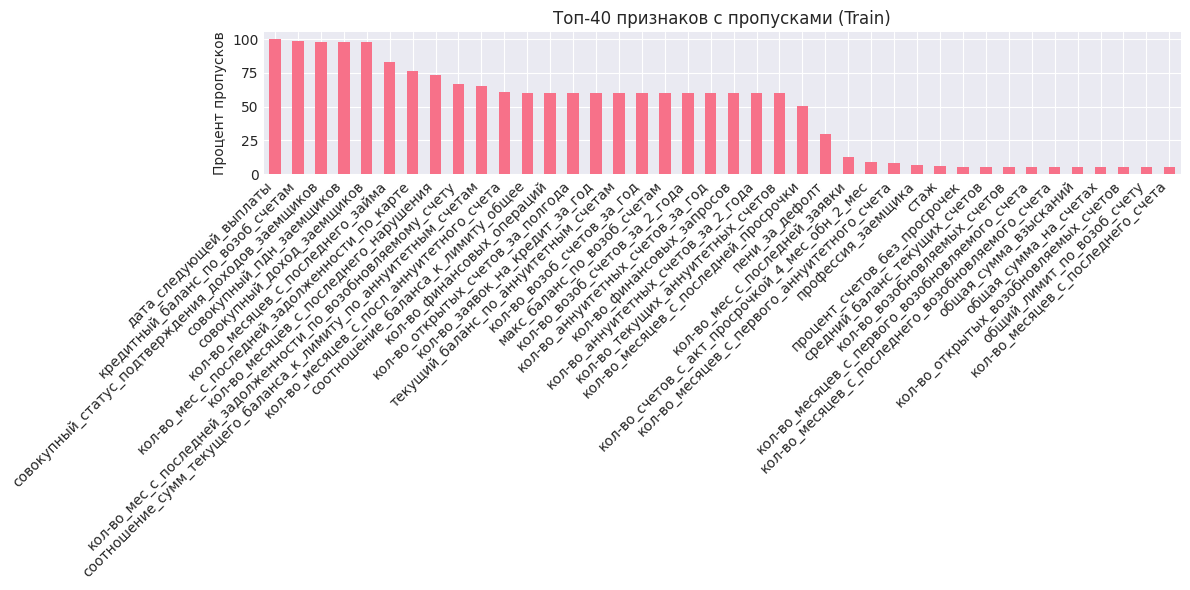

missing_count  \
дата_следующей_выплаты                                    1210779   
кредитный_баланс_по_возоб_счетам                          1193971   
совокупный_статус_подтверждения_доходов_заемщиков         1187729   
совокупный_пдн_заемщиков                                  1187548   
совокупный_доход_заемщиков                                1187546   
кол-во_месяцев_с_последнего_займа                         1005117   
кол-во_мес_с_последней_задолженности_по_карте              923517   
кол-во_месяцев_с_последнего_нарушения                      892120   
кол-во_мес_с_последней_задолженности_по_возобно...         805599   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...         792391   
кол-во_месяцев_с_посл_аннуитетного_счета                   739709   
соотношение_баланса_к_лимиту_общее                         726952   
кол-во_финансовых_операций                                 726902   
кол-во_открытых_счетов_за_полгода                          726902   
кол-во_заявок_на_кредит_за_год                             726902   
текущий_баланс_по_аннуитетным_счетам                       726901   
кол-во_возоб_счетов_за_год                                 726901   
макс_баланс_по_возоб_счетам                                726901   
кол-во_возоб_счетов_за_2_года                              726901   
кол-во_аннуитетных_счетов_за_год                           726901   
кол-во_финансовых_запросов                                 726901   
кол-во_аннуитетных_счетов_за_2_года                        726901   
кол-во_текущих_аннуитетных_счетов                          726901   
кол-во_месяцев_с_последней_просрочки                       610561   
пени_за_дефолт                                             363441   
кол-во_мес_с_последней_заявки                              156537   
кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес             105517   
кол-во_месяцев_с_первого_аннуитетного_счета                 95020   
профессия_заемщика                                          77049   
стаж                                                        70508   
процент_счетов_без_просрочек                                60902   
средний_баланс_текущих_счетов                               60788   
кол-во_возобновляемых_счетов                                60768   
кол-во_месяцев_с_первого_возобновляемого_счета              60768   
кол-во_месяцев_с_последнего_возобновляемого_счета           60768   
общая_сумма_взысканий                                       60767   
общая_сумма_на_счетах                                       60767   
кол-во_открытых_возобновляемых_счетов                       60767   
общий_лимит_по_возоб_счету                                  60767   
кол-во_месяцев_с_последнего_счета                           60767   
кол-во_счетов_с_акт_просрочкой_1_мес                        60767   
кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года              60767   
кредитный_лимит                                             60767   
лимит_по_аннуитетным_счетам                                 60767   
кол-во_счетов_за_посл_год                                   60767   
кол-во_возобновляемых_счетов_с_балансом_более_0             60767   
кол-во_аннуитетных_счетов                                   60767   
кол-во_карт                                                 60767   
кол-во_активных_возобновляемых_счетов                       60767   
кол-во_активных_карт                                        60767   
кол-во_счетов_с_просрочкой_4_мес                            60767   
соотношение_баланса_к_лимиту_по_картам                      55663   
процент_счетов_прев_75_лимита                               55331   
суммарная_доступная_сумма_займа_по_картам                   54971   
кол-во_месяцев_с_последней_карты                            54130   
кол-во_счетов_без_нарушений                                 50207   
кол-во_карт_без_нарушений                                   50207   
кол-во_открытых_счетов_за_2_года                  

In [16]:
missing_train: pd.DataFrame = analyze_missing(train, 'Train')
missing_train


Test - колонки с пропусками (67):


missing_count  \
дата_следующей_выплаты                                     134531   
пени_за_дефолт                                             134531   
кредитный_баланс_по_возоб_счетам                           132710   
совокупный_статус_подтверждения_доходов_заемщиков          131986   
совокупный_пдн_заемщиков                                   131965   
совокупный_доход_заемщиков                                 131964   
кол-во_месяцев_с_последнего_займа                          111638   
кол-во_мес_с_последней_задолженности_по_карте              102773   
кол-во_месяцев_с_последнего_нарушения                       99440   
кол-во_мес_с_последней_задолженности_по_возобно...          89749   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...          87903   
кол-во_месяцев_с_посл_аннуитетного_счета                    82219   
соотношение_баланса_к_лимиту_общее                          80813   
кол-во_открытых_счетов_за_полгода                           80811   
кол-во_аннуитетных_счетов_за_год                            80811   
кол-во_текущих_аннуитетных_счетов                           80811   
кол-во_финансовых_запросов                                  80811   
кол-во_финансовых_операций                                  80811   
текущий_баланс_по_аннуитетным_счетам                        80811   
макс_баланс_по_возоб_счетам                                 80811   
кол-во_аннуитетных_счетов_за_2_года                         80811   
кол-во_возоб_счетов_за_год                                  80811   
кол-во_возоб_счетов_за_2_года                               80811   
кол-во_заявок_на_кредит_за_год                              80811   
кол-во_месяцев_с_последней_просрочки                        68182   
кол-во_мес_с_последней_заявки                               17534   
кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес              11884   
кол-во_месяцев_с_первого_аннуитетного_счета                 10555   
профессия_заемщика                                           8736   
стаж                                                         8003   
процент_счетов_без_просрочек                                 6779   
средний_баланс_текущих_счетов                                6761   
общий_лимит_по_возоб_счету                                   6760   
кол-во_месяцев_с_последнего_возобновляемого_счета            6760   
кол-во_месяцев_с_последнего_счета                            6760   
общая_сумма_на_счетах                                        6760   
кол-во_возобновляемых_счетов                                 6760   
кол-во_месяцев_с_первого_возобновляемого_счета               6760   
общая_сумма_взысканий                                        6760   
кол-во_счетов_с_акт_просрочкой_1_мес                         6760   

                                                    missing_percent  
дата_следующей_выплаты                                 100.00000000  
пени_за_дефолт                                         100.00000000  
кредитный_баланс_по_возоб_счетам                        98.64640863  
совокупный_статус_подтверждения_доходов_заемщиков       98.10824271  
совокупный_пдн_заемщиков                                98.09263292  
совокупный_доход_заемщиков                              98.09188960  
кол-во_месяцев_с_последнего_займа                       82.98310427  
кол-во_мес_с_последней_задолженности_по_карте           76.39354498  
кол-во_месяцев_с_последнего_нарушения                   73.91604909  
кол-во_мес_с_последней_задолженности_по_возобно...      66.71250492  
соотношение_сумм_текущего_баланса_к_лимиту_по_а...      65.34033048  
кол-во_месяцев_с_посл_аннуитетного_счета                61.11528198  
соотношение_баланса_к_лимиту_общее                      60.07016970  
кол-во_открытых_счетов_за_полгода                       60.06868305  
кол-во_аннуитетных_счетов_за_год                        60.06868305  
кол-во_текущих_аннуитетных_счетов                       60.06868305  
кол-во_финансовых_запросов      

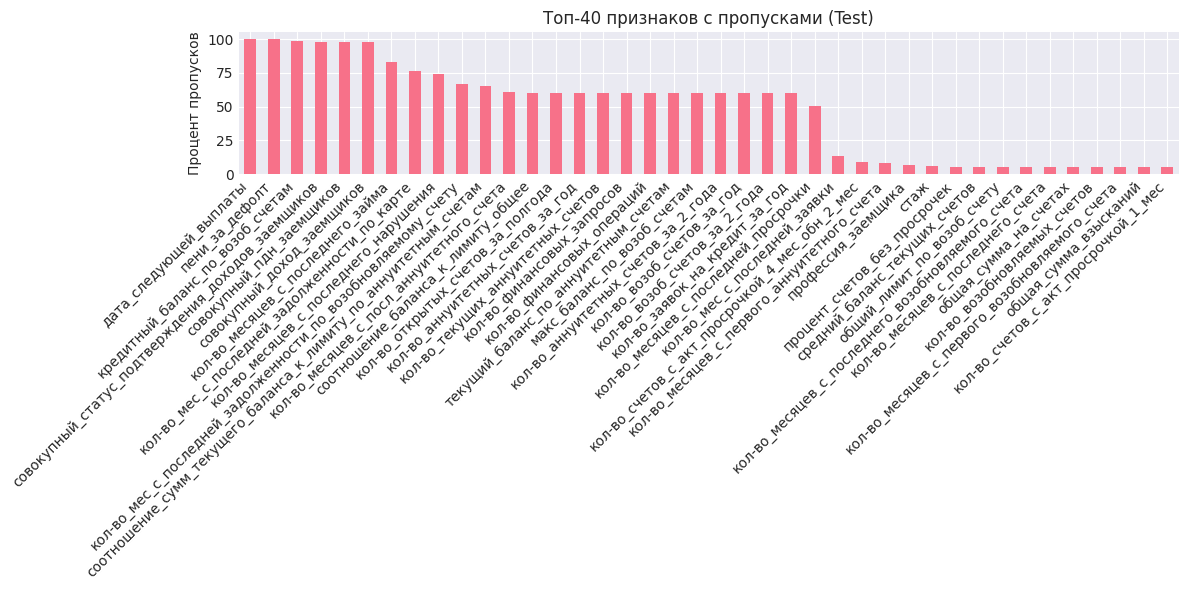

missing_count  \
дата_следующей_выплаты                                     134531   
пени_за_дефолт                                             134531   
кредитный_баланс_по_возоб_счетам                           132710   
совокупный_статус_подтверждения_доходов_заемщиков          131986   
совокупный_пдн_заемщиков                                   131965   
совокупный_доход_заемщиков                                 131964   
кол-во_месяцев_с_последнего_займа                          111638   
кол-во_мес_с_последней_задолженности_по_карте              102773   
кол-во_месяцев_с_последнего_нарушения                       99440   
кол-во_мес_с_последней_задолженности_по_возобно...          89749   
соотношение_сумм_текущего_баланса_к_лимиту_по_а...          87903   
кол-во_месяцев_с_посл_аннуитетного_счета                    82219   
соотношение_баланса_к_лимиту_общее                          80813   
кол-во_открытых_счетов_за_полгода                           80811   
кол-во_аннуитетных_счетов_за_год                            80811   
кол-во_текущих_аннуитетных_счетов                           80811   
кол-во_финансовых_запросов                                  80811   
кол-во_финансовых_операций                                  80811   
текущий_баланс_по_аннуитетным_счетам                        80811   
макс_баланс_по_возоб_счетам                                 80811   
кол-во_аннуитетных_счетов_за_2_года                         80811   
кол-во_возоб_счетов_за_год                                  80811   
кол-во_возоб_счетов_за_2_года                               80811   
кол-во_заявок_на_кредит_за_год                              80811   
кол-во_месяцев_с_последней_просрочки                        68182   
кол-во_мес_с_последней_заявки                               17534   
кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес              11884   
кол-во_месяцев_с_первого_аннуитетного_счета                 10555   
профессия_заемщика                                           8736   
стаж                                                         8003   
процент_счетов_без_просрочек                                 6779   
средний_баланс_текущих_счетов                                6761   
общий_лимит_по_возоб_счету                                   6760   
кол-во_месяцев_с_последнего_возобновляемого_счета            6760   
кол-во_месяцев_с_последнего_счета                            6760   
общая_сумма_на_счетах                                        6760   
кол-во_возобновляемых_счетов                                 6760   
кол-во_месяцев_с_первого_возобновляемого_счета               6760   
общая_сумма_взысканий                                        6760   
кол-во_счетов_с_акт_просрочкой_1_мес                         6760   
кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года               6760   
кредитный_лимит                                              6760   
лимит_по_аннуитетным_счетам                                  6760   
кол-во_счетов_за_посл_год                                    6760   
кол-во_возобновляемых_счетов_с_балансом_более_0              6760   
кол-во_открытых_возобновляемых_счетов                        6760   
кол-во_карт                                                  6760   
кол-во_аннуитетных_счетов                                    6760   
кол-во_активных_возобновляемых_счетов                        6760   
кол-во_счетов_с_просрочкой_4_мес                             6760   
кол-во_активных_карт                                         6760   
соотношение_баланса_к_лимиту_по_картам                       6249   
процент_счетов_прев_75_лимита                                6224   
суммарная_доступная_сумма_займа_по_картам                    6172   
кол-во_месяцев_с_последней_карты                             6091   
кол-во_счетов_без_нарушений                                  5634   
кол-во_карт_без_нарушений                                    5634   
кол-во_открытых_счетов_за_2_года                  

In [17]:
missing_test: pd.DataFrame = analyze_missing(test, 'Test')
missing_test

In [18]:
missing_df = pd.DataFrame({
    'train_missing_%': train.isnull().sum() / len(train) * 100,
    'test_missing_%': test.isnull().sum() / len(test) * 100
}).sort_values('train_missing_%', ascending=False)
missing_df

train_missing_%  \
дата_следующей_выплаты                                100.00000000   
кредитный_баланс_по_возоб_счетам                       98.61180281   
совокупный_статус_подтверждения_доходов_заемщиков      98.09626695   
совокупный_пдн_заемщиков                               98.08131790   
совокупный_доход_заемщиков                             98.08115271   
...                                                            ...   
сумма_задолженности                                     0.00000000   
тип_займа                                               0.00000000   
тип_предоставления_кредита                              0.00000000   
цель_займа                                              0.00000000   
юридический_статус                                      0.00000000   

                                                   test_missing_%  
дата_следующей_выплаты                               100.00000000  
кредитный_баланс_по_возоб_счетам                      98.64640863  
совокупный_статус_подтверждения_доходов_заемщиков     98.10824271  
совокупный_пдн_заемщиков                              98.09263292  
совокупный_доход_заемщиков                            98.09188960  
...                                                           ...  
сумма_задолженности                                    0.00000000  
тип_займа                                              0.00000000  
тип_предоставления_кредита                             0.00000000  
цель_займа                                             0.00000000  
юридический_статус                                     0.00000000  

[109 rows x 2 columns]

<Figure size 1200x600 with 0 Axes>

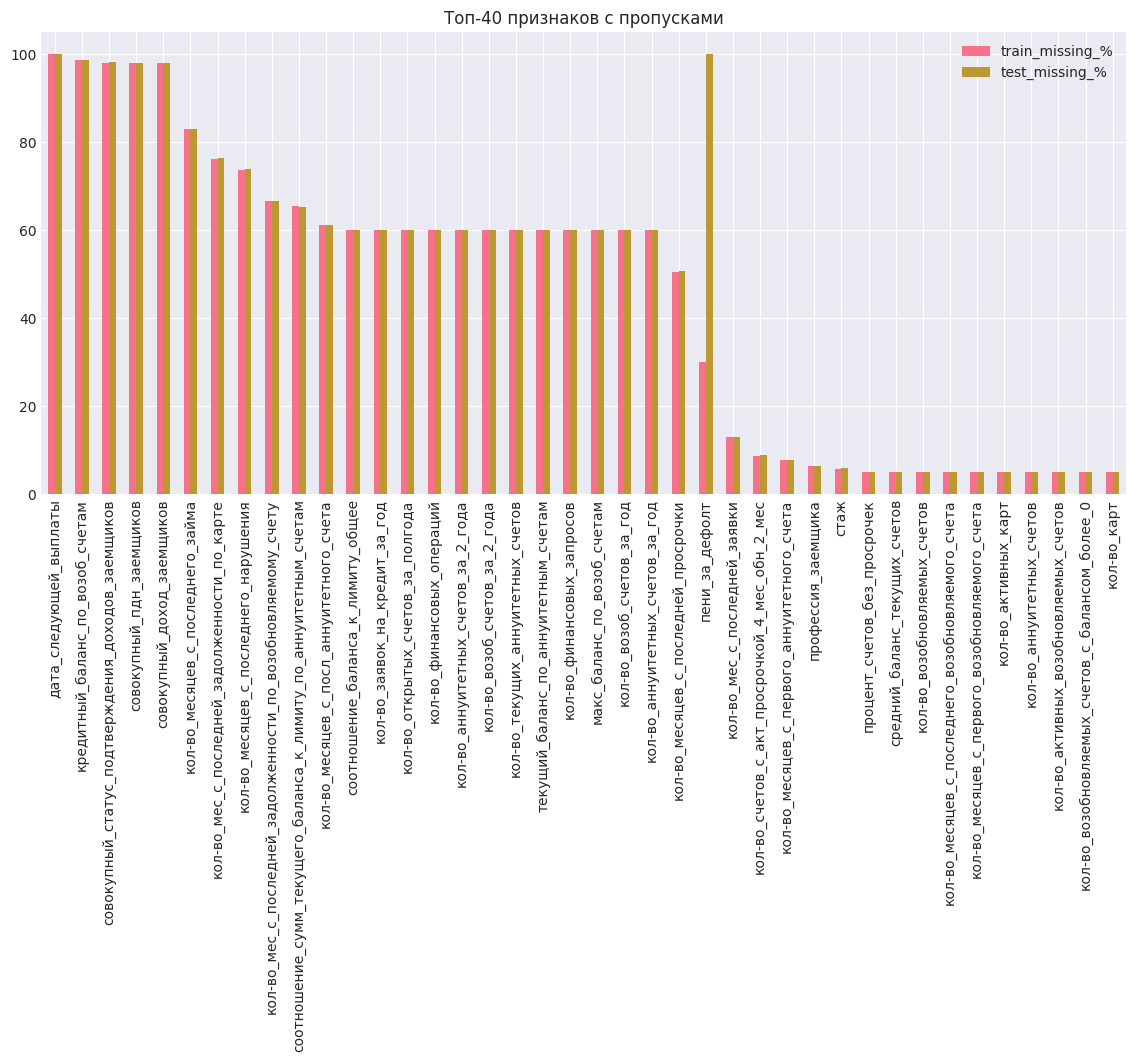

In [19]:
plt.figure(figsize=(12, 6))
missing_df.head(40).plot(kind='bar', figsize=(14, 6))
plt.title('Топ-40 признаков с пропусками')
plt.show()

### Анализ ключевых признаков

### Финансовые фичи

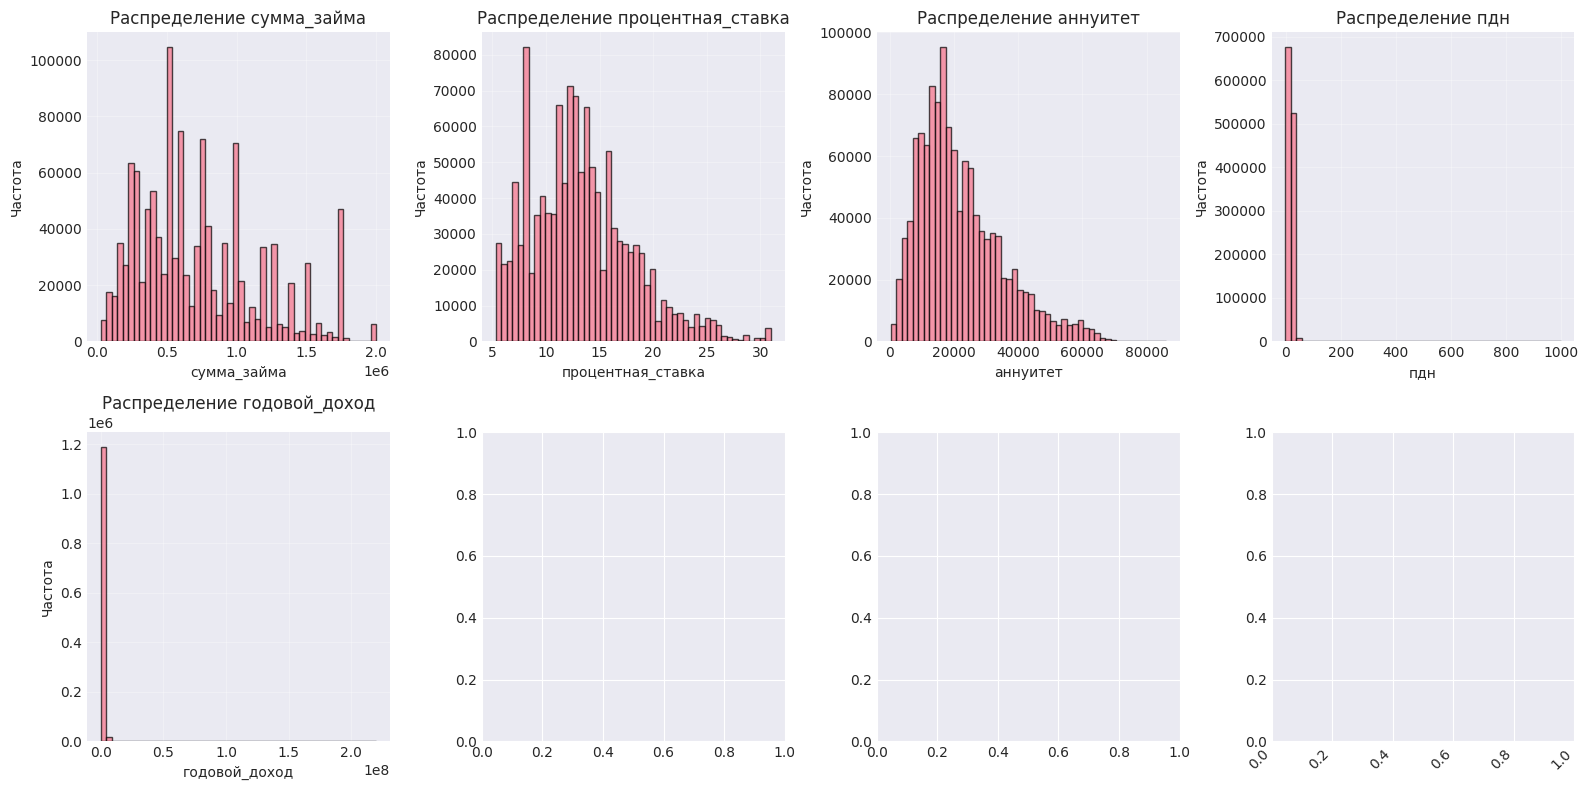

In [25]:
financial_features: List[str] = [
    'сумма_займа',              # Размер кредита
    'процентная_ставка',        # Процент по кредиту (чем выше - выше риск)
    'аннуитет',                 # Ежемесячный платеж
    'пдн',                      # Платеж на душу населения
    'годовой_доход',            # Доход заемщика
    'заем_к_доходу',            # Новый признак: отношение займа к доходу
    'аннуитет_к_доходу',        # Новый признак: платежная нагрузка
]

existing_features: List[str] = [f for f in financial_features if f in train.columns]

if existing_features:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features[:8]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
            
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Кредитная история и рейтинги

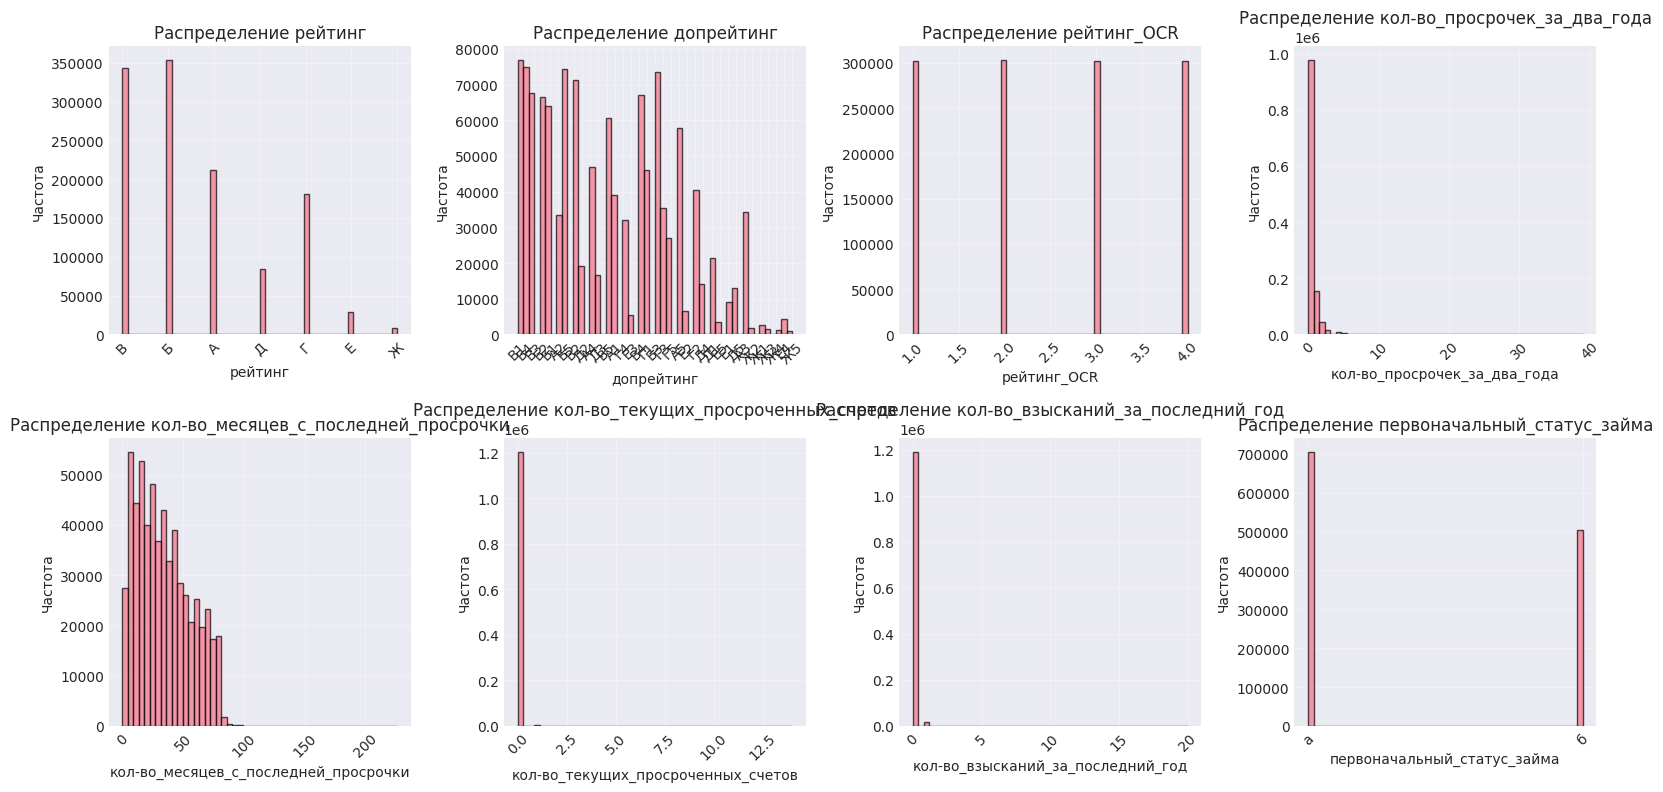

In [29]:
credit_history_features: List[str] = [
    'рейтинг',                  # Буквенный рейтинг (A-Ж) - порядковый признак
    'допрейтинг',               # Дополнительный рейтинг
    'рейтинг_OCR',              # Рейтинг от кредитного бюро
    'кол-во_просрочек_за_два_года',          # История просрочек
    'кол-во_месяцев_с_последней_просрочки',  # Время с последней просрочки
    'кол-во_текущих_просроченных_счетов',    # Текущие проблемы
    'кол-во_взысканий_за_последний_год',     # Взыскания
    'первоначальный_статус_займа',           # Исходный статус
]

existing_features_2: List[str] = [f for f in credit_history_features if f in train.columns]

if existing_features_2:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_2[:8]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

### Кредитные лимиты и использование

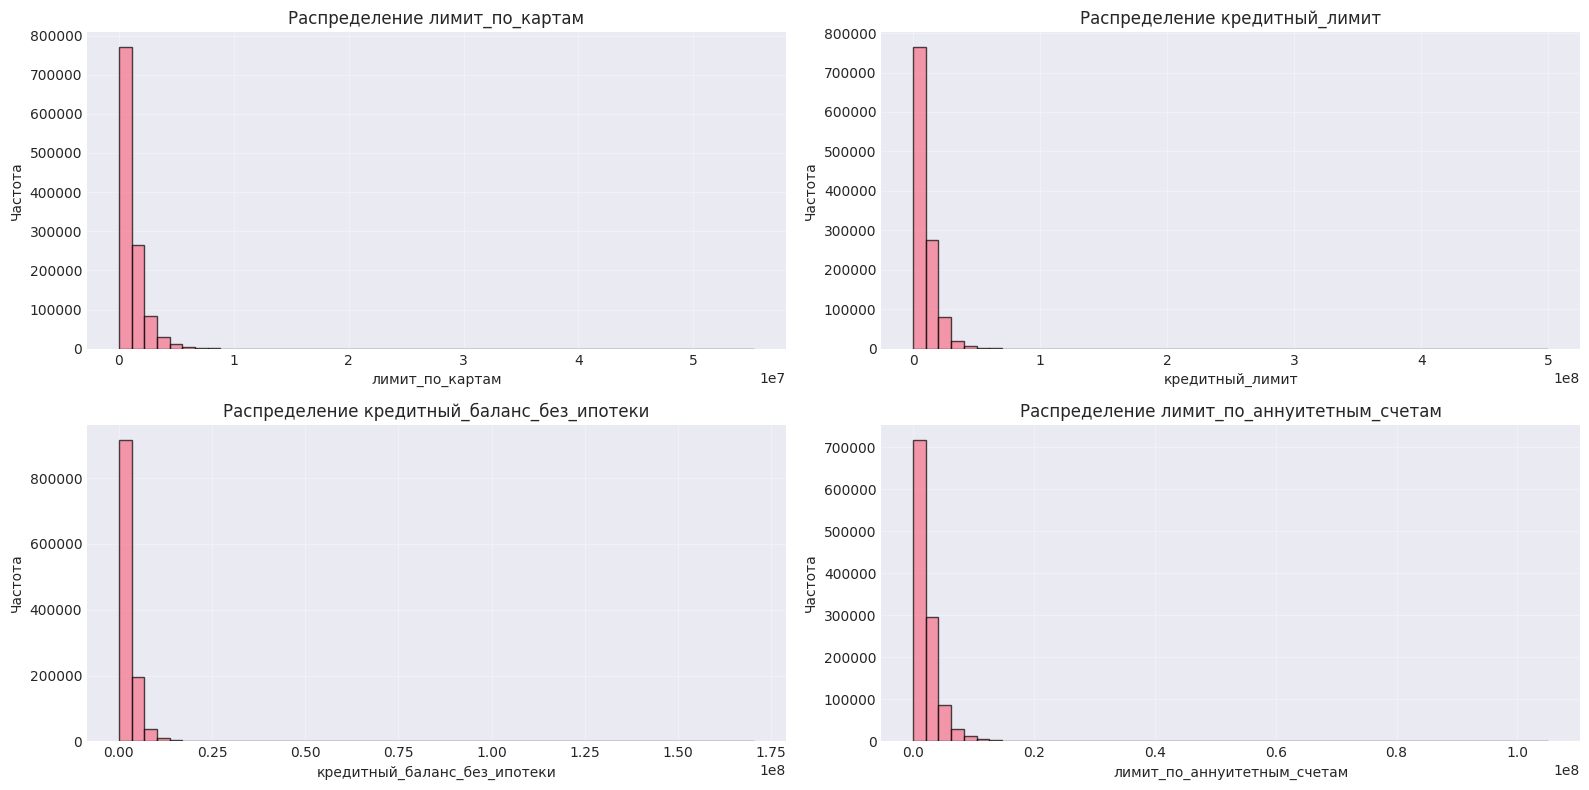

In [30]:
credit_limit_features: List[str] = [
    'лимит_по_картам',          # Лимит по кредитным картам
    'кредитный_лимит',          # Общий кредитный лимит
    'кредитный_баланс_без_ипотеки',  # Использование кредита
    'лимит_по_аннуитетным_счетам',  # Лимиты по разным типам счетов
    # 'общий_лимит',              # Новый признак: суммарный лимит
    # 'коэфф_использования_кредита',  # Новый признак: использование лимита
]

existing_features_3: List[str] = [f for f in credit_limit_features if f in train.columns]

if existing_features_3:
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_3[:4]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Демографические и профессиональные

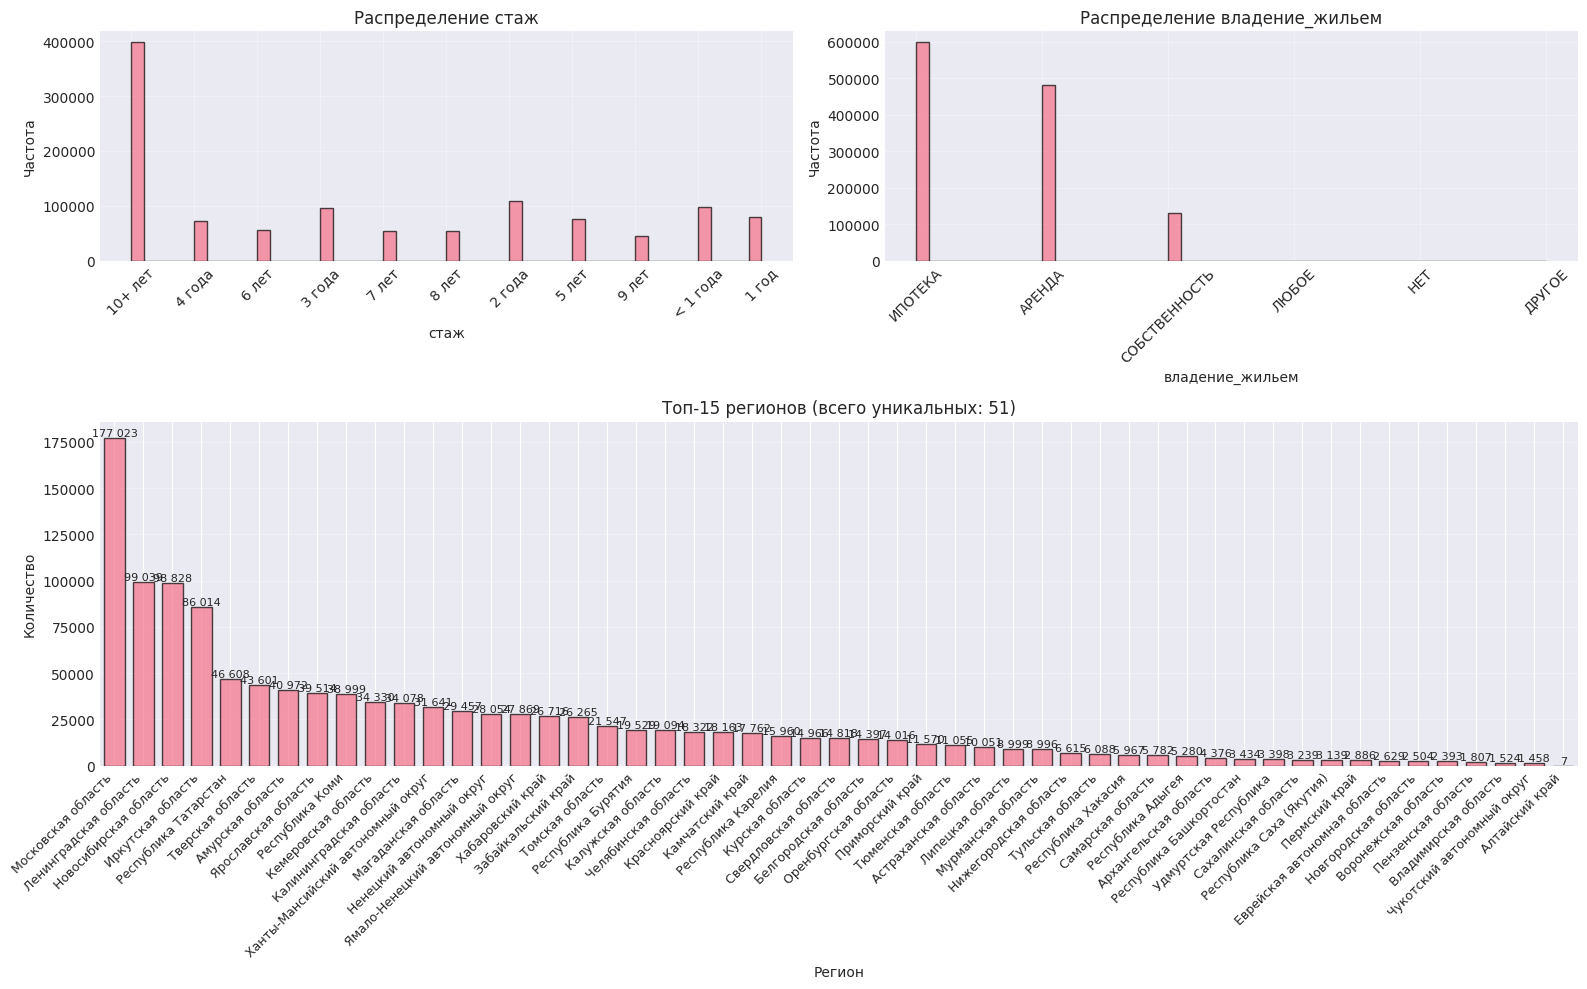

In [ ]:
demographic_features: List[str] = [
    # 'профессия_заемщика',       # Профессия (нужна группировка)
    'стаж',                     # Стаж работы
    'владение_жильем',          # ИПОТЕКА/АРЕНДА/СОБСТВЕННОСТЬ
    'регион',                   # Регион проживания
]

existing_features_4: List[str] = [f for f in demographic_features if f in train.columns]

if existing_features_4:
    fig = plt.figure(figsize=(16, 10))
    
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])
    
    ax1 = fig.add_subplot(gs[0, 0])  # стаж
    ax2 = fig.add_subplot(gs[0, 1])  # владение_жильем
    ax3 = fig.add_subplot(gs[1, :])  # регион
    
    axes = [ax1, ax2, ax3]
    features_to_plot = [f for f in existing_features_4 if f in train.columns]
    
    for i, feature in enumerate(features_to_plot[:3]):
        if feature in train.columns:
            if feature == 'регион':
                region_counts = train[feature].value_counts().head(70)  # Топ-70 регионов
                # Создаем барплот
                x_pos = np.arange(len(region_counts))
                bars = ax3.bar(x_pos, region_counts.values, alpha=0.7, edgecolor='black', width=0.7)
                ax3.set_xticks(x_pos)
                # Равномерно распределяем подписи
                ax3.set_xticklabels(region_counts.index, rotation=45, ha='right', fontsize=9)
                # Добавляем значения над столбцами
                for bar in bars:
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height):,}'.replace(',', ' '),
                            ha='center', va='bottom', fontsize=8)
                
                ax3.set_title(f'Топ-15 регионов (всего уникальных: {train[feature].nunique()})')
                ax3.set_xlabel('Регион')
                ax3.set_ylabel('Количество')
                ax3.grid(alpha=0.3, axis='y')
                # Устанавливаем равные отступы между столбцами
                ax3.set_xlim(-0.5, len(region_counts) - 0.5)
            else:
                # Для остальных признаков
                axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'Распределение {feature}')
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Частота')
                axes[i].grid(alpha=0.3)
                axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

### Исторические данные по счетам 

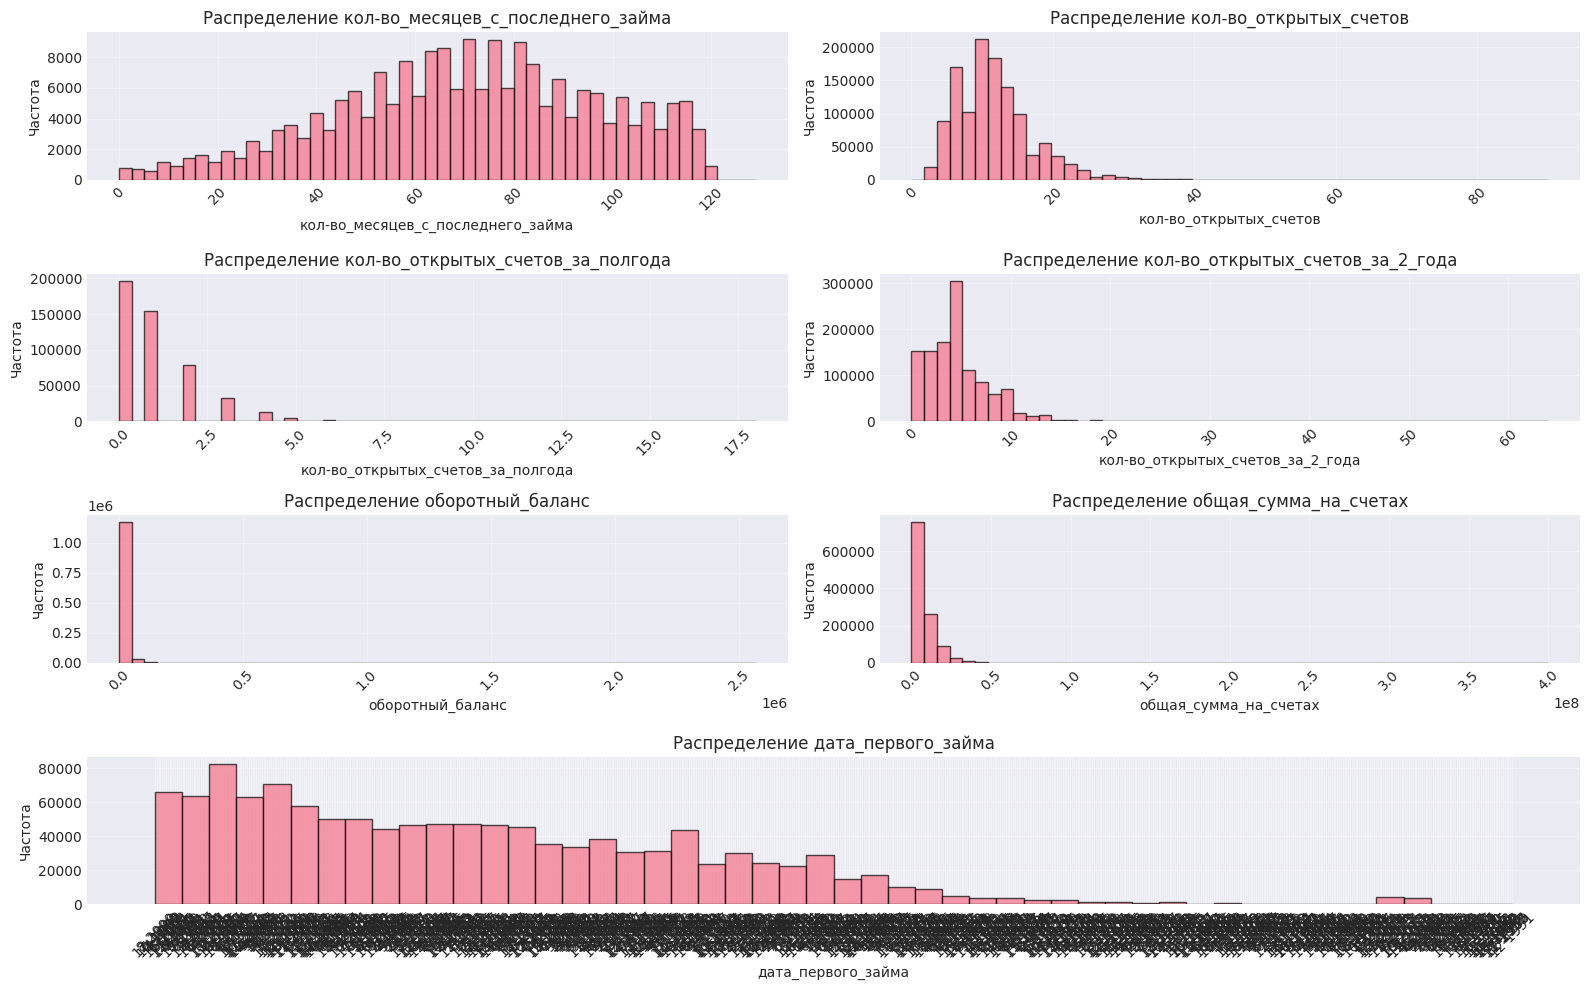

In [ ]:
account_history_features = [
    'кол-во_месяцев_с_последнего_займа',     # Время с последнего займа
    'кол-во_открытых_счетов',                # Количество счетов
    'кол-во_открытых_счетов_за_полгода',     # Активность
    'кол-во_открытых_счетов_за_2_года',
    'оборотный_баланс',                      # Текущие балансы
    'общая_сумма_на_счетах',
    'дата_первого_займа',       # Стаж кредитной истории
]

existing_features_5: List[str] = [f for f in account_history_features if f in train.columns]

if existing_features_5:
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(4, 2)
    ax1 = fig.add_subplot(gs[0, 0])  # кол-во_месяцев_с_последнего_займа
    ax2 = fig.add_subplot(gs[0, 1])  # кол-во_открытых_счетов
    ax3 = fig.add_subplot(gs[1, 0])  # кол-во_открытых_счетов_за_полгода
    ax4 = fig.add_subplot(gs[1, 1])  # кол-во_открытых_счетов_за_2_года
    ax5 = fig.add_subplot(gs[2, 0])  # оборотный_баланс
    ax6 = fig.add_subplot(gs[2, 1])  # общая_сумма_на_счетах
    ax7 = fig.add_subplot(gs[3, :])  # дата_первого_займа
    
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    features_to_plot = [f for f in existing_features_5 if f in train.columns]
    
    for i, feature in enumerate(features_to_plot[:7]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

### Цель и подтверждение дохода

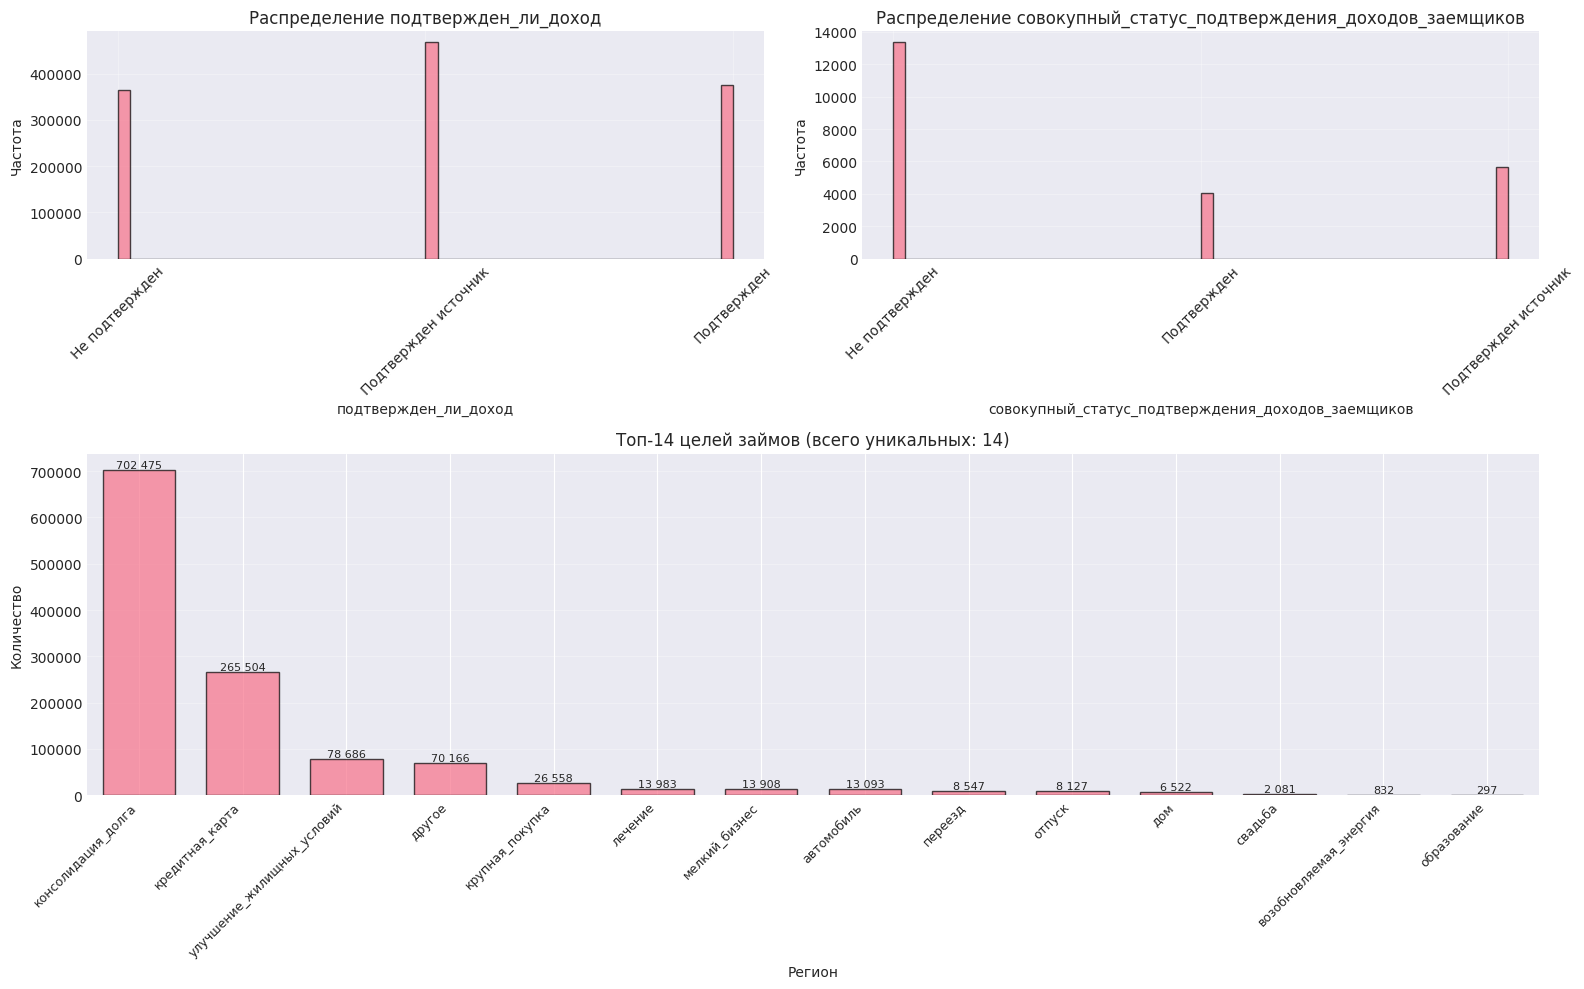

In [54]:
purpose_features = [
    'подтвержден_ли_доход',     # Подтверждение дохода
    'совокупный_статус_подтверждения_доходов_заемщиков',
    'цель_займа',               # Цель кредита
]

existing_features_6: List[str] = [f for f in purpose_features if f in train.columns]

if existing_features_6:
    fig = plt.figure(figsize=(16, 10))
    
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])
    
    ax1 = fig.add_subplot(gs[0, 0])  # подтвержден_ли_доход
    ax2 = fig.add_subplot(gs[0, 1])  # совокупный_статус_подтверждения_доходов_заемщиков
    ax3 = fig.add_subplot(gs[1, :])  # цель_займа
    
    axes = [ax1, ax2, ax3]
    features_to_plot = [f for f in existing_features_6 if f in train.columns]
    
    for i, feature in enumerate(features_to_plot[:3]):
        if feature in train.columns:
            if feature == 'цель_займа':
                region_counts = train[feature].value_counts().head(14)
                # Создаем барплот
                x_pos = np.arange(len(region_counts))
                bars = ax3.bar(x_pos, region_counts.values, alpha=0.7, edgecolor='black', width=0.7)
                ax3.set_xticks(x_pos)
                ax3.set_xticklabels(region_counts.index, rotation=45, ha='right', fontsize=9)
                for bar in bars:
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height):,}'.replace(',', ' '),
                            ha='center', va='bottom', fontsize=8)
                
                ax3.set_title(f'Топ-14 целей займов (всего уникальных: {train[feature].nunique()})')
                ax3.set_xlabel('Регион')
                ax3.set_ylabel('Количество')
                ax3.grid(alpha=0.3, axis='y')
                ax3.set_xlim(-0.5, len(region_counts) - 0.5)
            else:
                axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'Распределение {feature}')
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Частота')
                axes[i].grid(alpha=0.3)
                axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

### Коэффициенты и соотношения

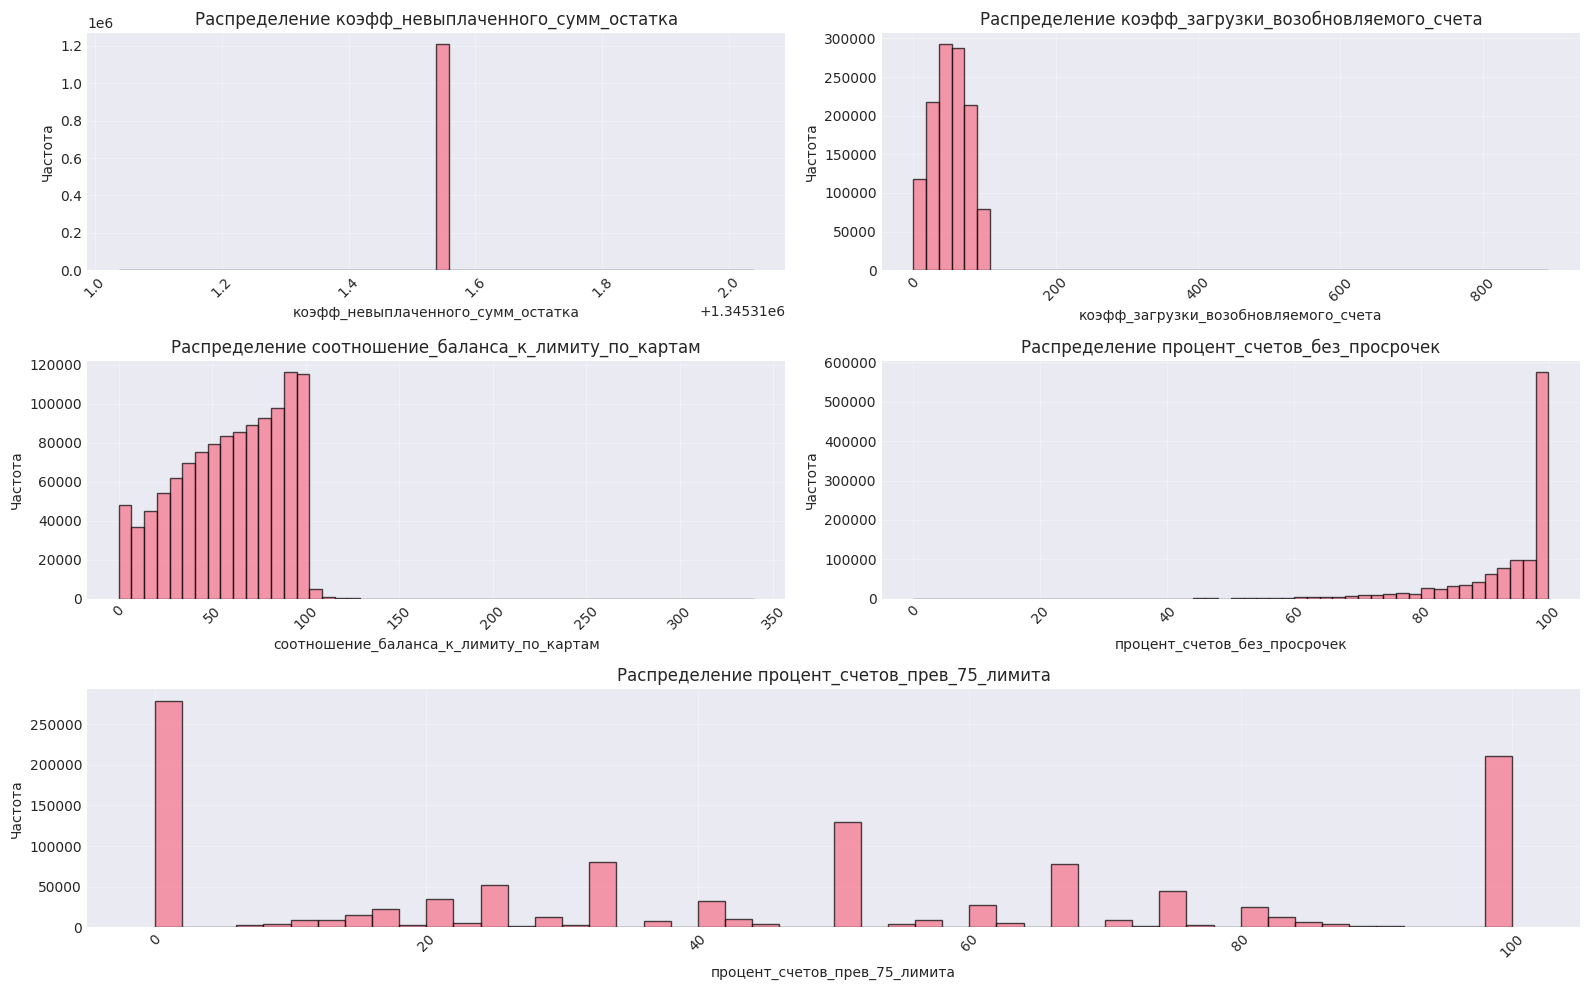

In [ ]:
ratio_features = [
    'коэфф_невыплаченного_сумм_остатка',    # Доля непогашенного
    'коэфф_загрузки_возобновляемого_счета', # Использование возобновляемого счета
    'соотношение_баланса_к_лимиту_по_картам', # Использование карт
    'процент_счетов_без_просрочек',         # Качество счетов
    'процент_счетов_прев_75_лимита',        # Перегруженность кредитов
]

existing_features_7: List[str] = [f for f in ratio_features if f in train.columns]

if existing_features_7:
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gs[0, 0])  # коэфф_невыплаченного_сумм_остатка
    ax2 = fig.add_subplot(gs[0, 1])  # коэфф_загрузки_возобновляемого_счета
    ax3 = fig.add_subplot(gs[1, 0])  # соотношение_баланса_к_лимиту_по_картам
    ax4 = fig.add_subplot(gs[1, 1])  # процент_счетов_без_просрочек
    ax5 = fig.add_subplot(gs[2, :])  # процент_счетов_прев_75_лимита (на всю ширину)
    axes = [ax1, ax2, ax3, ax4, ax5]
    features_to_plot = [f for f in existing_features_7 if f in train.columns]
    for i, feature in enumerate(features_to_plot[:5]):
        if feature in train.columns:
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

#### Топ-20 признаков

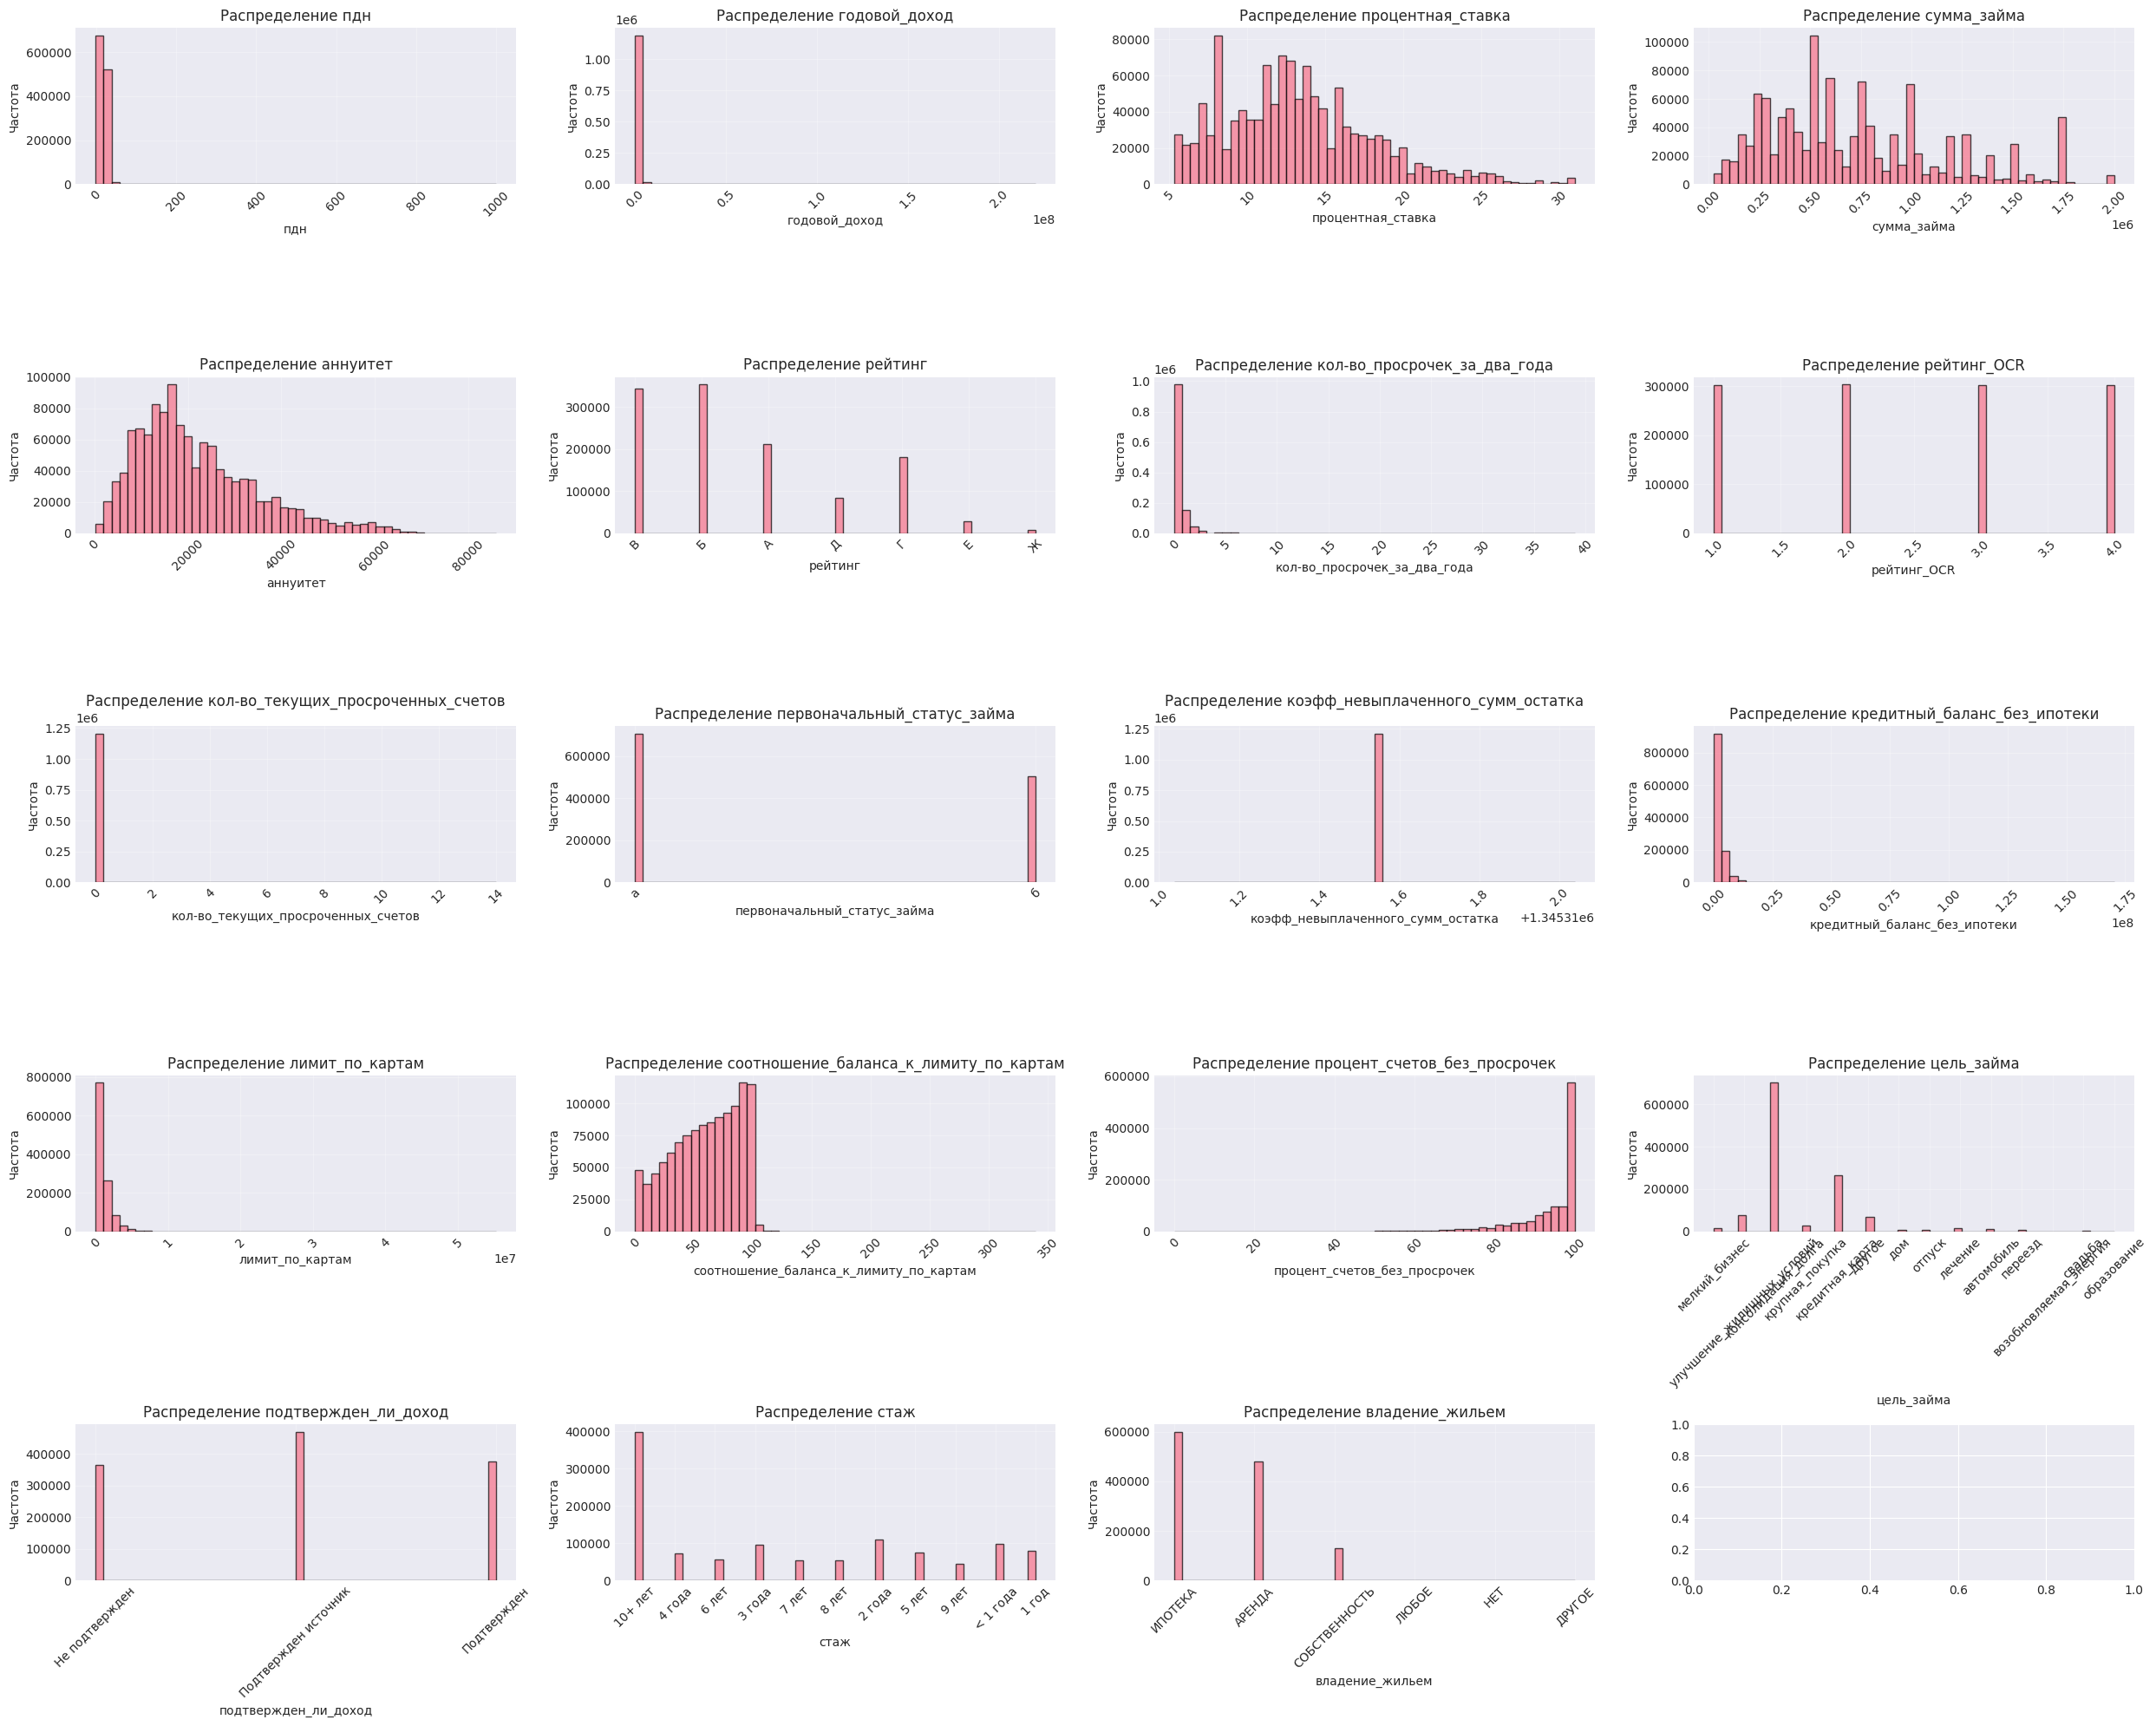

In [64]:
top_20_features = [
    # 1-5: Самые важные финансовые
    'пдн',                          # Ключевой показатель нагрузки
    'годовой_доход',                # Платежеспособность
    'процентная_ставка',            # Рисковость кредита
    'сумма_займа',                  # Размер обязательства
    'аннуитет',                     # Ежемесячная нагрузка
    
    # 6-10: Кредитная история
    'рейтинг',                      # Общая оценка риска
    'кол-во_просрочек_за_два_года', # История просрочек
    'рейтинг_OCR',                  # Оценка бюро
    'кол-во_текущих_просроченных_счетов', # Текущие проблемы
    'первоначальный_статус_займа',  # Исходные условия
    
    # 11-15: Использование кредитов
    'коэфф_невыплаченного_сумм_остатка',
    'кредитный_баланс_без_ипотеки',
    'лимит_по_картам',
    'соотношение_баланса_к_лимиту_по_картам',
    'процент_счетов_без_просрочек',
    
    # 16-20: Дополнительные
    'цель_займа',                   # Цель использования
    'подтвержден_ли_доход',         # Документальное подтверждение
    'стаж',                         # Стабильность работы
    'возраст',                      # Возрастная группа риска
    'владение_жильем',              # Стабильность проживания
]

existing_features_top: List[str] = [f for f in top_20_features if f in train.columns]

if existing_features_top:
    fig, axes = plt.subplots(5, 4, figsize=(25, 20))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features_top[:20]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

### Список числовых признаков

In [67]:
numeric_cols: List[str] = train.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
numeric_cols

['id',
 'сумма_займа',
 'процентная_ставка',
 'аннуитет',
 'годовой_доход',
 'рейтинг_OCR',
 'коэфф_акционных_зачислений_в_остатке',
 'кол_во_субсидий_за_год',
 'индекс_проживания',
 'пдн',
 'кол-во_просрочек_за_два_года',
 'коэфф_невыплаченного_сумм_остатка',
 'коэфф_исходного_платежа',
 'нижний_порог_рейтинга_заемщика',
 'верхний_порог_рейтинга_заемщика',
 'кол-во_заявок_за_полгода',
 'кол-во_месяцев_с_последней_просрочки',
 'кол-во_месяцев_с_последнего_займа',
 'кол-во_открытых_счетов',
 'кол-во_записей_в_общедоступных_документах',
 'оборотный_баланс',
 'коэфф_загрузки_возобновляемого_счета',
 'кол-во_счетов',
 'непогашенная_сумма_из_тела_займов',
 'сумма_выплат_по_просрочкам',
 'дата_следующей_выплаты',
 'грейд_на_детерминаторе',
 'кол-во_взысканий_за_последний_год',
 'кол-во_месяцев_с_последнего_нарушения',
 'код_политики',
 'совокупный_доход_заемщиков',
 'совокупный_пдн_заемщиков',
 'кол-во_текущих_просроченных_счетов',
 'общая_сумма_взысканий',
 'возвраты_с_учетом_мпл',
 'общая_

### Будущие признаки для анализа

In [68]:
engineered_features: List[str] = [
    # Финансовые соотношения
    'заем_к_доходу',                # сумма_займа / годовой_доход
    'аннуитет_к_доходу',            # аннуитет * 12 / годовой_доход
    'пдн_от_дохода',                # пдн / годовой_доход * 100
    'общий_лимит',                  # лимит_по_картам + кредитный_лимит
    'коэфф_использования_кредита',  # кредитный_баланс_без_ипотеки / кредитный_лимит
    
    # Временные
    'стаж_кредитной_истории_мес',   # Из дата_первого_займа
    'давность_просрочки_кат',        # Категории из кол-во_месяцев_с_последней_просрочки
    'срок_займа_мес',               # Из срок_займа
    
    # Кредитные
    'интенсивность_просрочек',      # кол-во_просрочек_за_два_года / (24 - кол-во_месяцев_с_последней_просрочки)
    'общая_кредитная_нагрузка',      # сумма всех балансов / сумма всех лимитов
]

### Корреляции с целевой переменной

In [ ]:
numeric_cols_filtered: List[str] = [col for col in numeric_cols if train[col].notnull().sum() > 100000]
numeric_cols_filtered

['id',
 'сумма_займа',
 'процентная_ставка',
 'аннуитет',
 'годовой_доход',
 'рейтинг_OCR',
 'коэфф_акционных_зачислений_в_остатке',
 'кол_во_субсидий_за_год',
 'индекс_проживания',
 'пдн',
 'кол-во_просрочек_за_два_года',
 'коэфф_невыплаченного_сумм_остатка',
 'коэфф_исходного_платежа',
 'нижний_порог_рейтинга_заемщика',
 'верхний_порог_рейтинга_заемщика',
 'кол-во_заявок_за_полгода',
 'кол-во_месяцев_с_последней_просрочки',
 'кол-во_месяцев_с_последнего_займа',
 'кол-во_открытых_счетов',
 'кол-во_записей_в_общедоступных_документах',
 'оборотный_баланс',
 'коэфф_загрузки_возобновляемого_счета',
 'кол-во_счетов',
 'непогашенная_сумма_из_тела_займов',
 'сумма_выплат_по_просрочкам',
 'грейд_на_детерминаторе',
 'кол-во_взысканий_за_последний_год',
 'кол-во_месяцев_с_последнего_нарушения',
 'код_политики',
 'кол-во_текущих_просроченных_счетов',
 'общая_сумма_взысканий',
 'возвраты_с_учетом_мпл',
 'общая_сумма_на_счетах',
 'кол-во_открытых_счетов_за_полгода',
 'кол-во_текущих_аннуитетных_сч

In [ ]:
correlations: pd.Series = train[numeric_cols_filtered + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
correlations

итоговый_статус_займа                                              1.00000000
процентная_ставка                                                  0.25827948
сумма_выплат_по_просрочкам                                         0.14036207
нижний_порог_рейтинга_заемщика                                     0.13069154
верхний_порог_рейтинга_заемщика                                    0.13069027
кол-во_открытых_счетов_за_2_года                                   0.10036624
соотношение_баланса_к_лимиту_общее                                 0.08879016
кол-во_счетов_за_посл_год                                          0.08611942
пдн                                                                0.08402269
кол-во_возоб_счетов_за_2_года                                      0.08250841
суммарная_доступная_сумма_займа_по_картам                          0.08169635
средний_баланс_текущих_счетов                                      0.07864659
кредитный_лимит                                                 

### Топ-20 признаков по корреляции с целевой переменной

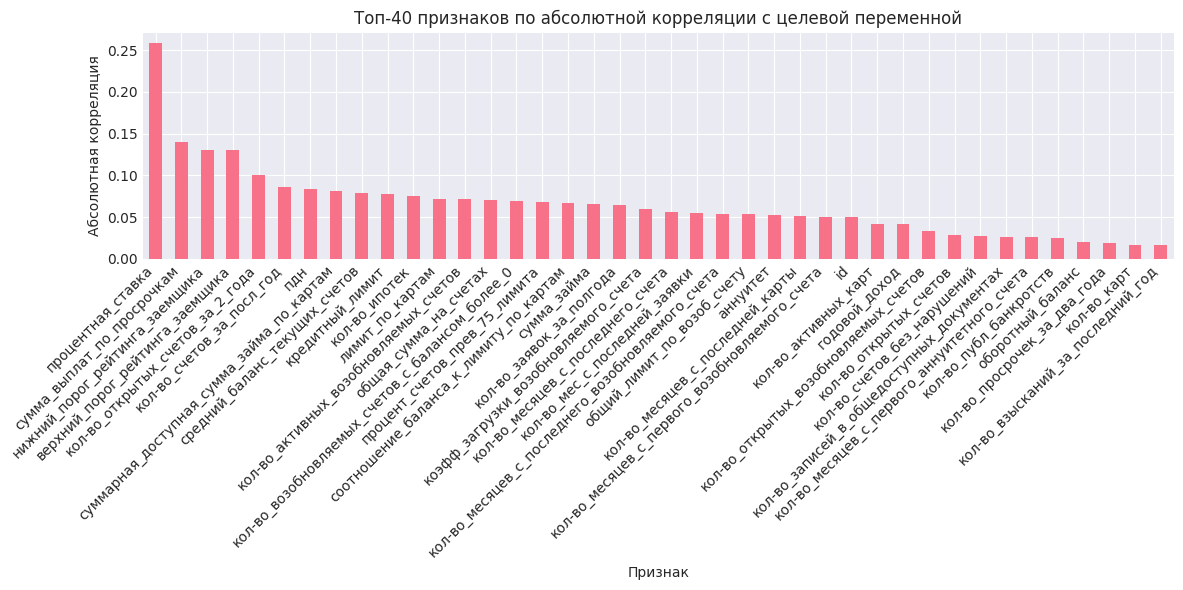


Топ-40 признаков по корреляции с итоговый_статус_займа:
процентная_ставка                                   0.25827948
сумма_выплат_по_просрочкам                          0.14036207
нижний_порог_рейтинга_заемщика                      0.13069154
верхний_порог_рейтинга_заемщика                     0.13069027
кол-во_открытых_счетов_за_2_года                    0.10036624
кол-во_счетов_за_посл_год                           0.08611942
пдн                                                 0.08402269
суммарная_доступная_сумма_займа_по_картам           0.08169635
средний_баланс_текущих_счетов                       0.07864659
кредитный_лимит                                     0.07807636
кол-во_ипотек                                       0.07521414
лимит_по_картам                                     0.07164932
кол-во_активных_возобновляемых_счетов               0.07103964
общая_сумма_на_счетах                               0.07077532
кол-во_возобновляемых_счетов_с_балансом_более_0     0.0696508

In [90]:
numeric_cols_filtered: List = []
for col in numeric_cols:
    if train[col].notna().sum() > len(train) * 0.5:  # Более 50% заполнено
        numeric_cols_filtered.append(col)

if len(numeric_cols_filtered) > 0:
    # Корреляции с целевой переменной
    correlations: pd.Series = train[numeric_cols_filtered + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
    
    # Топ-40 признаков по корреляции
    top_corr = correlations[1:41]  # Исключаем саму целевую
    
    plt.figure(figsize=(12, 6))
    top_corr.plot(kind='bar')
    plt.title('Топ-40 признаков по абсолютной корреляции с целевой переменной')
    plt.xlabel('Признак')
    plt.ylabel('Абсолютная корреляция')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\nТоп-40 признаков по корреляции с {target_col}:")
    print(correlations[1:41])

### Анализ категориальных признаков

In [75]:
print("\nАнализ категориальных признаков:")
categorical_cols: List[str] = train.select_dtypes(include=['object']).columns.tolist()
print(f"Всего категориальных признаков: {len(categorical_cols)}")
print(f"\nКатегориальные признаки ({len(categorical_cols)}): {categorical_cols}")


Анализ категориальных признаков:
Всего категориальных признаков: 19

Категориальные признаки (19): ['срок_займа', 'рейтинг', 'допрейтинг', 'профессия_заемщика', 'стаж', 'владение_жильем', 'подтвержден_ли_доход', 'платежный_график', 'цель_займа', 'регион', 'пос_стоп_фактор', 'юридический_статус', 'дата_первого_займа', 'первоначальный_статус_займа', 'пени_за_дефолт', 'тип_займа', 'совокупный_статус_подтверждения_доходов_заемщиков', 'особая_ситуация', 'тип_предоставления_кредита']


In [76]:
categorical_cols

['срок_займа',
 'рейтинг',
 'допрейтинг',
 'профессия_заемщика',
 'стаж',
 'владение_жильем',
 'подтвержден_ли_доход',
 'платежный_график',
 'цель_займа',
 'регион',
 'пос_стоп_фактор',
 'юридический_статус',
 'дата_первого_займа',
 'первоначальный_статус_займа',
 'пени_за_дефолт',
 'тип_займа',
 'совокупный_статус_подтверждения_доходов_заемщиков',
 'особая_ситуация',
 'тип_предоставления_кредита']

In [71]:
print("Проверка наличия признаков в данных train:")
available_categorical: List = []
for feature in categorical_cols:
    if feature in train.columns:
        available_categorical.append(feature)
        print(f"✓ {feature}")
    else:
        possible_variants: List[str] = [col for col in train.columns if feature.lower() in col.lower()]
        if possible_variants:
            print(f"Warning: {feature} -> найден вариант: {possible_variants[0]}")
            available_categorical.append(possible_variants[0])
        else:
            print(f"X {feature} - отсутствует в данных")

Проверка наличия признаков в данных train:
✓ срок_займа
✓ рейтинг
✓ допрейтинг
✓ профессия_заемщика
✓ стаж
✓ владение_жильем
✓ подтвержден_ли_доход
✓ платежный_график
✓ цель_займа
✓ регион
✓ пос_стоп_фактор
✓ юридический_статус
✓ дата_первого_займа
✓ первоначальный_статус_займа
✓ пени_за_дефолт
✓ тип_займа
✓ совокупный_статус_подтверждения_доходов_заемщиков
✓ особая_ситуация
✓ тип_предоставления_кредита


### Первичный анализ категориальных признаков


Признак: срок_займа
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.000000%)

Уникальные значения:
  '3 года': 918586 записей
  '5 лет': 292193 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  '5 лет': дефолт 32.4% (292193.0 записей)
  '3 года': дефолт 16.0% (918586.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 2.024824 раз выше минимальной!


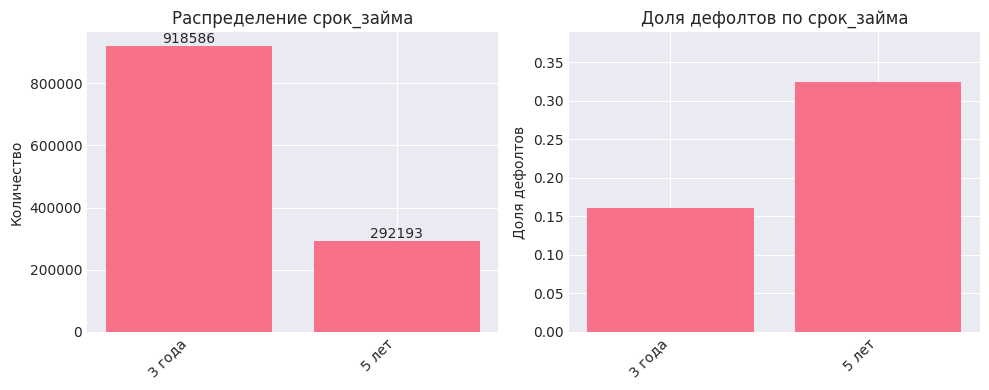


----------------------------------------

Признак: рейтинг
Тип данных: object
Уникальных значений: 7
Пропусков: 0 (0.000000%)

Уникальные значения:
  'Б': 353530 записей
  'В': 343586 записей
  'А': 211521 записей
  'Г': 180714 записей
  'Д': 84394 записей
  'Е': 28842 записей
  'Ж': 8192 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Ж': дефолт 49.7% (8192.0 записей)
  'Е': дефолт 45.2% (28842.0 записей)
  'Д': дефолт 38.4% (84394.0 записей)
  'Г': дефолт 30.3% (180714.0 записей)
  'В': дефолт 22.4% (343586.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 8.207260 раз выше минимальной!


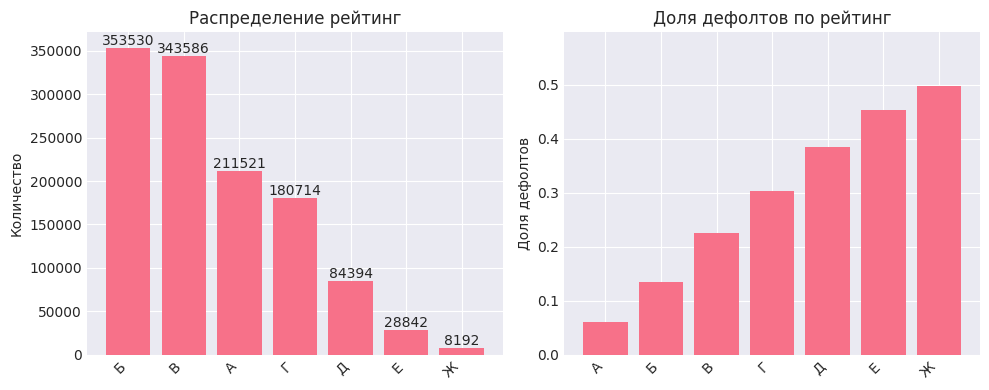


----------------------------------------

Признак: допрейтинг
Тип данных: object
Уникальных значений: 35
Пропусков: 0 (0.000000%)

----------------------------------------

Признак: профессия_заемщика
Тип данных: object
Уникальных значений: 273666
Пропусков: 77049 (6.363589%)

----------------------------------------

Признак: стаж
Тип данных: object
Уникальных значений: 11
Пропусков: 70508 (5.823358%)

Уникальные значения:
  '10+ лет': 398214 записей
  '2 года': 109469 записей
  '< 1 года': 97338 записей
  '3 года': 96842 записей
  '1 год': 79652 записей
  '5 лет': 75707 записей
  '4 года': 72444 записей
  NaN: 70508 записей
  '6 лет': 56522 записей
  '8 лет': 54635 записей
  '7 лет': 53633 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  '< 1 года': дефолт 20.5% (97338.0 записей)
  '1 год': дефолт 20.5% (79652.0 записей)
  '8 лет': дефолт 20.0% (54635.0 записей)
  '3 года': дефолт 19.9% (96842.0 записей)
  '9 лет': дефолт 19.9% (45815.0 записей)

-------------

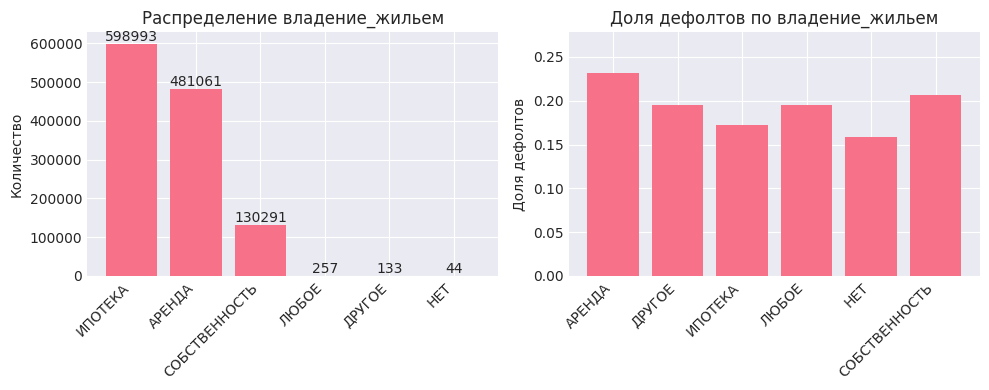


----------------------------------------

Признак: подтвержден_ли_доход
Тип данных: object
Уникальных значений: 3
Пропусков: 0 (0.000000%)

Уникальные значения:
  'Подтвержден источник': 468878 записей
  'Подтвержден': 376662 записей
  'Не подтвержден': 365239 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Подтвержден': дефолт 23.8% (376662.0 записей)
  'Подтвержден источник': дефолт 21.0% (468878.0 записей)
  'Не подтвержден': дефолт 14.7% (365239.0 записей)


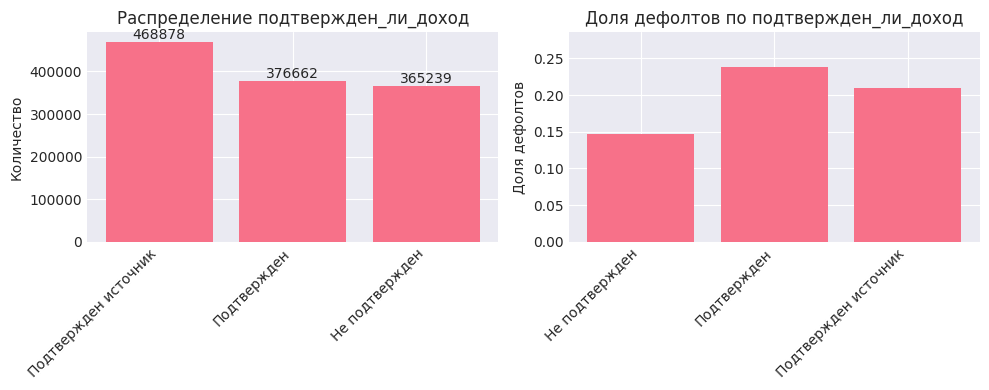


----------------------------------------

Признак: платежный_график
Тип данных: object
Уникальных значений: 1
Пропусков: 0 (0.000000%)

Уникальные значения:
  'n': 1210779 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'n': дефолт 20.0% (1210779.0 записей)


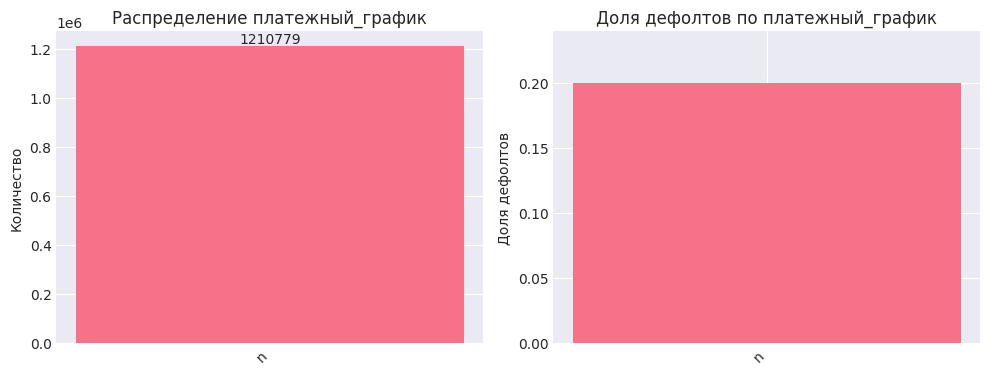


----------------------------------------

Признак: цель_займа
Тип данных: object
Уникальных значений: 14
Пропусков: 0 (0.000000%)

Уникальные значения:
  'консолидация_долга': 702475 записей
  'кредитная_карта': 265504 записей
  'улучшение_жилищных_условий': 78686 записей
  'другое': 70166 записей
  'крупная_покупка': 26558 записей
  'лечение': 13983 записей
  'мелкий_бизнес': 13908 записей
  'автомобиль': 13093 записей
  'переезд': 8547 записей
  'отпуск': 8127 записей
  'дом': 6522 записей
  ... и еще 3 значений

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'мелкий_бизнес': дефолт 29.8% (13908.0 записей)
  'возобновляемая_энергия': дефолт 24.2% (832.0 записей)
  'переезд': дефолт 23.5% (8547.0 записей)
  'дом': дефолт 21.7% (6522.0 записей)
  'лечение': дефолт 21.6% (13983.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 2.416724 раз выше минимальной!

----------------------------------------

Признак: регион
Тип данных: object
Уникальных значений: 51
Пропусков:

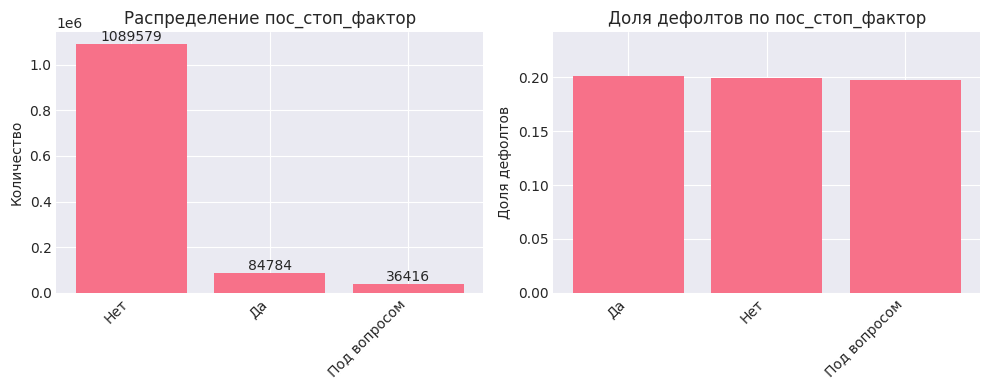


----------------------------------------

Признак: юридический_статус
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.000000%)

Уникальные значения:
  'Нет': 968854 записей
  'Да': 241925 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Нет': дефолт 20.0% (968854.0 записей)
  'Да': дефолт 19.9% (241925.0 записей)


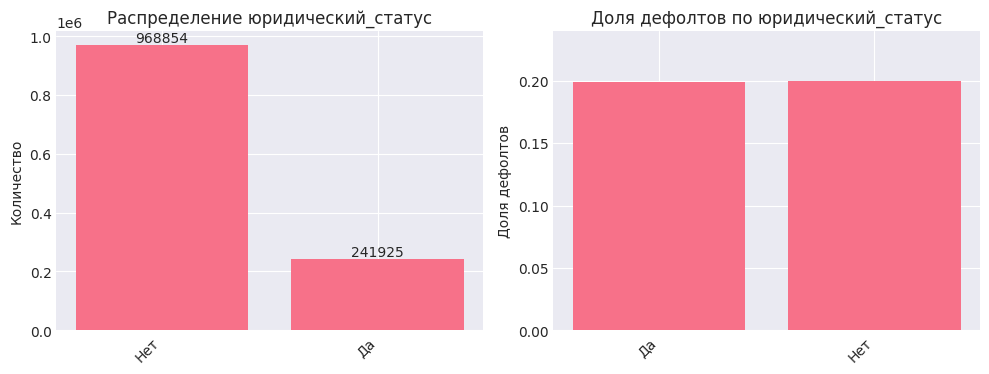


----------------------------------------

Признак: дата_первого_займа
Тип данных: object
Уникальных значений: 738
Пропусков: 0 (0.000000%)

----------------------------------------

Признак: первоначальный_статус_займа
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.000000%)

Уникальные значения:
  'а': 705688 записей
  'б': 505091 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'а': дефолт 20.2% (705688.0 записей)
  'б': дефолт 19.6% (505091.0 записей)


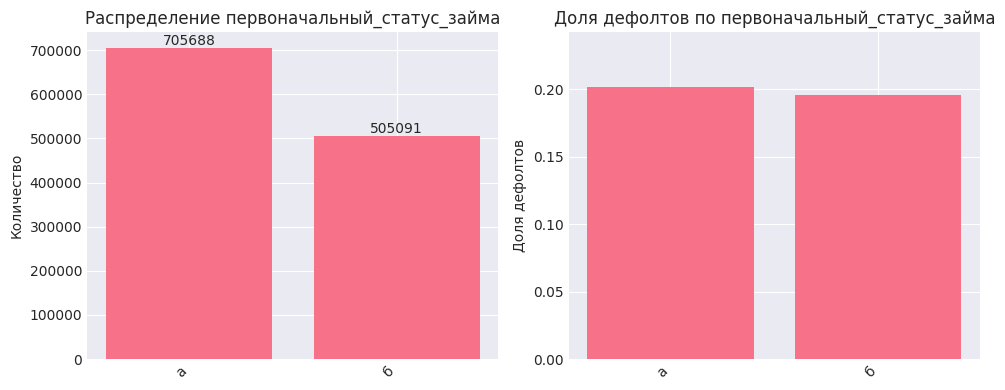


----------------------------------------

Признак: пени_за_дефолт
Тип данных: object
Уникальных значений: 2
Пропусков: 363441 (30.017121%)

Уникальные значения:
  'False': 735956 записей
  NaN: 363441 записей
  'True': 111382 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'True': дефолт 100.0% (111382.0 записей)
  'False': дефолт 7.9% (735956.0 записей)
  ВНИМАНИЕ: Максимальная доля дефолтов в 12.668583 раз выше минимальной!

----------------------------------------

Признак: тип_займа
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.000000%)

Уникальные значения:
  'Индивидуальный': 1187546 записей
  'Совместный': 23233 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Совместный': дефолт 24.6% (23233.0 записей)
  'Индивидуальный': дефолт 19.9% (1187546.0 записей)


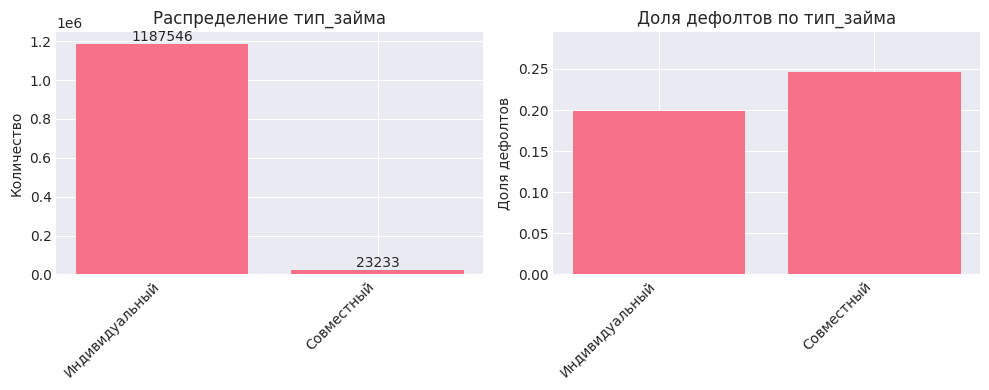


----------------------------------------

Признак: совокупный_статус_подтверждения_доходов_заемщиков
Тип данных: object
Уникальных значений: 3
Пропусков: 1187729 (98.096267%)

Уникальные значения:
  NaN: 1187729 записей
  'Не подтвержден': 13380 записей
  'Подтвержден источник': 5635 записей
  'Подтвержден': 4035 записей

----------------------------------------

Признак: особая_ситуация
Тип данных: object
Уникальных значений: 1
Пропусков: 0 (0.000000%)

Уникальные значения:
  'Нет': 1210779 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Нет': дефолт 20.0% (1210779.0 записей)


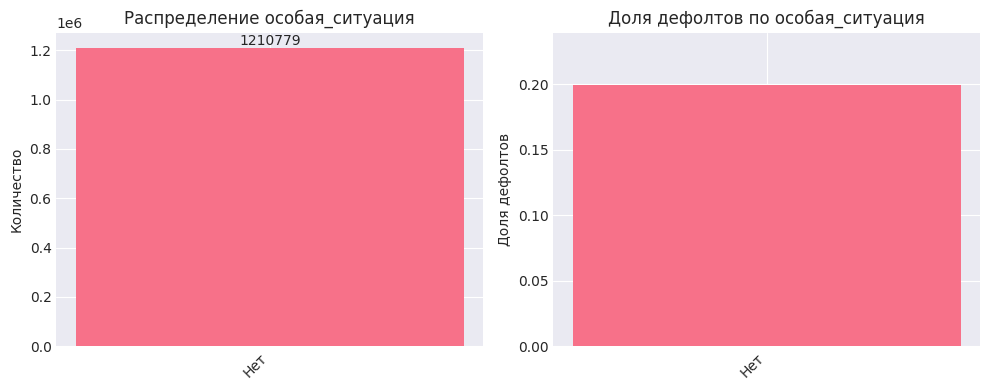


----------------------------------------

Признак: тип_предоставления_кредита
Тип данных: object
Уникальных значений: 2
Пропусков: 0 (0.000000%)

Уникальные значения:
  'Наличные': 1204573 записей
  'Перевод': 6206 записей

Связь с целевой переменной:
Топ-5 значений по доле дефолтов:
  'Перевод': дефолт 20.4% (6206.0 записей)
  'Наличные': дефолт 20.0% (1204573.0 записей)


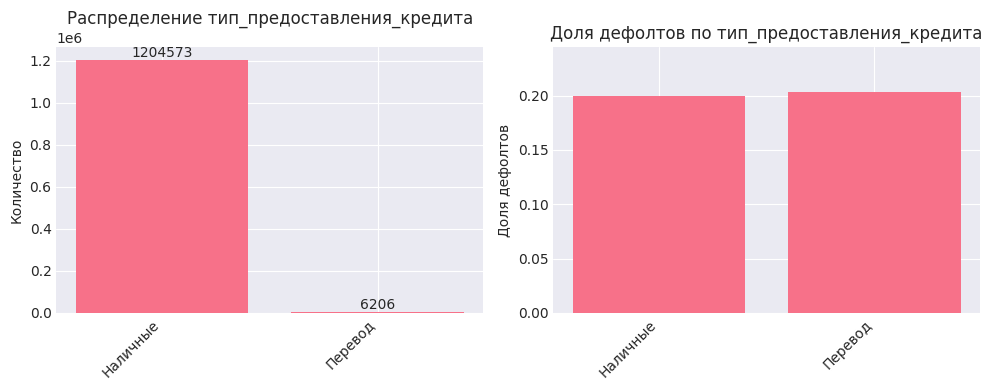


----------------------------------------


In [77]:
for feature in available_categorical:
    if feature in train.columns:
        print(f"\n{'='*40}")
        print(f"Признак: {feature}")
        print('='*40)
        
        # Основная информация
        unique_values = train[feature].nunique()
        n_missing = train[feature].isnull().sum()
        pct_missing = n_missing / len(train) * 100
        
        print(f"Тип данных: {train[feature].dtype}")
        print(f"Уникальных значений: {unique_values}")
        print(f"Пропусков: {n_missing} ({pct_missing:.6f}%)")
        
        # Содержимое (первые 11 уникальных значений)
        if unique_values <= 20:
            print(f"\nУникальные значения:")
            value_counts = train[feature].value_counts(dropna=False)
            for value, count in value_counts.head(11).items():
                if pd.isna(value):
                    print(f"  NaN: {count} записей")
                else:
                    print(f"  '{value}': {count} записей")
            
            if unique_values > 11:
                print(f"  ... и еще {unique_values - 11} значений")
        
        # Анализ связи с целевой переменной
        if pct_missing < 50 and unique_values <= 20:
            print(f"\nСвязь с целевой переменной:")
            
            # Удаляем пропуски для анализа
            clean_data = train[[feature, target_col]].dropna(subset=[feature])
            
            if len(clean_data) > 0:
                # Для каждого значения смотрим долю дефолтов
                default_rates = clean_data.groupby(feature)[target_col].agg(['mean', 'count'])
                default_rates = default_rates.sort_values('mean', ascending=False)
                
                print("Топ-5 значений по доле дефолтов:")
                for value, (default_rate, count) in default_rates.head(5).iterrows():
                    if pd.isna(value):
                        print(f"  NaN: дефолт {default_rate:.1%} ({count} записей)")
                    else:
                        print(f"  '{value}': дефолт {default_rate:.1%} ({count} записей)")
                
                # Проверяем, есть ли статистически значимые различия
                if len(default_rates) > 1:
                    max_rate = default_rates['mean'].max()
                    min_rate = default_rates['mean'].min()
                    if max_rate > 0 and min_rate > 0:
                        ratio = max_rate / min_rate
                        if ratio > 2:
                            print(f"  ВНИМАНИЕ: Максимальная доля дефолтов в {ratio:.6f} раз выше минимальной!")
        
        # Визуализация для важных признаков
        if unique_values <= 10 and pct_missing < 30:
            plt.figure(figsize=(10, 4))
            
            # 1. Распределение
            plt.subplot(1, 2, 1)
            value_counts = train[feature].value_counts(dropna=False)
            if len(value_counts) <= 10:
                bars = plt.bar(range(len(value_counts)), value_counts.values)
                plt.xticks(range(len(value_counts)), value_counts.index, rotation=45, ha='right')
                plt.title(f'Распределение {feature}')
                plt.ylabel('Количество')
                for bar, count in zip(bars, value_counts.values):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                            f'{count}', ha='center', va='bottom')
            
            # 2. Доля дефолтов по категориям
            plt.subplot(1, 2, 2)
            if len(clean_data) > 0:
                default_rates = clean_data.groupby(feature)[target_col].mean()
                if len(default_rates) <= 10:
                    bars = plt.bar(range(len(default_rates)), default_rates.values)
                    plt.xticks(range(len(default_rates)), default_rates.index, rotation=45, ha='right')
                    plt.title(f'Доля дефолтов по {feature}')
                    plt.ylabel('Доля дефолтов')
                    plt.ylim(0, max(default_rates.values) * 1.2)
            
            plt.tight_layout()
            plt.show()
        
        print("\n" + "-"*40)

### Анализ уникальных значений

In [ ]:
for col in categorical_cols[:50]:
    unique_vals: int = train[col].nunique()
    print(f"{col}: {unique_vals} уникальных значений")

срок_займа: 2 уникальных значений
рейтинг: 7 уникальных значений
допрейтинг: 35 уникальных значений
профессия_заемщика: 273666 уникальных значений
стаж: 11 уникальных значений
владение_жильем: 6 уникальных значений
подтвержден_ли_доход: 3 уникальных значений
платежный_график: 1 уникальных значений
цель_займа: 14 уникальных значений
регион: 51 уникальных значений
пос_стоп_фактор: 3 уникальных значений
юридический_статус: 2 уникальных значений
дата_первого_займа: 738 уникальных значений
первоначальный_статус_займа: 2 уникальных значений
пени_за_дефолт: 2 уникальных значений
тип_займа: 2 уникальных значений
совокупный_статус_подтверждения_доходов_заемщиков: 3 уникальных значений
особая_ситуация: 1 уникальных значений
тип_предоставления_кредита: 2 уникальных значений


### Анализ рейтингов

In [81]:
if 'рейтинг' in train.columns:
    print("Рейтинг (буквенный):")
    rating_order: List[str] = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж']
    for rating in rating_order:
        if rating in train['рейтинг'].values:
            subset: str = train[train['рейтинг'] == rating]
            default_rate: float = subset[target_col].mean()
            print(f"  {rating}: {len(subset)} записей, дефолт {default_rate:.3%}")

if 'допрейтинг' in train.columns:
    print("\nДопрейтинг:")
    top_dopratings: pd.Series = train['допрейтинг'].value_counts().head(10)
    for doprating, count in top_dopratings.items():
        if not pd.isna(doprating):
            subset: str = train[train['допрейтинг'] == doprating]
            default_rate: float = subset[target_col].mean()
            print(f"  {doprating}: {count} записей, дефолт {default_rate:.3%}")

Рейтинг (буквенный):
  А: 211521 записей, дефолт 6.059%
  Б: 353530 записей, дефолт 13.395%
  В: 343586 записей, дефолт 22.447%
  Г: 180714 записей, дефолт 30.347%
  Д: 84394 записей, дефолт 38.435%
  Е: 28842 записей, дефолт 45.222%
  Ж: 8192 записей, дефолт 49.731%

Допрейтинг:
  В1: 76885 записей, дефолт 19.061%
  Б4: 74965 записей, дефолт 14.804%
  Б5: 74394 записей, дефолт 16.722%
  Б3: 73444 записей, дефолт 13.033%
  В2: 71404 записей, дефолт 20.734%
  В3: 67583 записей, дефолт 22.483%
  В4: 66958 записей, дефолт 24.974%
  Б2: 66645 записей, дефолт 11.302%
  Б1: 64082 записей, дефолт 10.477%
  В5: 60756 записей, дефолт 25.922%


#### График распределения по рейтингам


Распределение по рейтингам:
рейтинг
А    211521
Б    353530
В    343586
Г    180714
Д     84394
Е     28842
Ж      8192
Name: count, dtype: int64


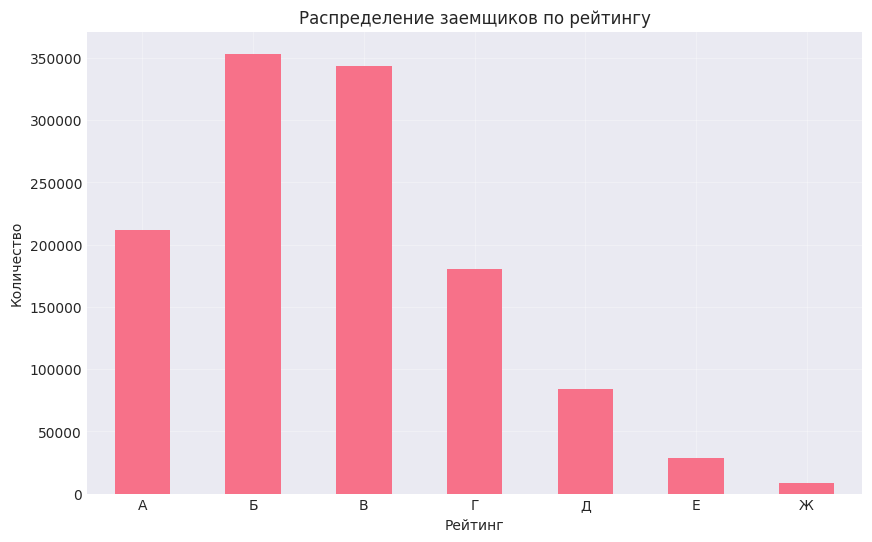

In [ ]:
if 'рейтинг' in categorical_cols:
    print("\nРаспределение по рейтингам:")
    rating_dist: pd.Series = train['рейтинг'].value_counts().sort_index()
    print(rating_dist)
    
    # Визуализация рейтингов
    plt.figure(figsize=(10, 6))
    rating_dist.plot(kind='bar')
    plt.title('Распределение заемщиков по рейтингу')
    plt.xlabel('Рейтинг')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.grid(alpha=0.3)
    plt.show()

### Подтверждение дохода

In [83]:
income_confirmation_cols: List[str] = ['подтвержден_ли_доход', 'совокупный_статус_подтверждения_доходов_заемщиков']
for col in income_confirmation_cols:
    if col in train.columns:
        print(f"\n{col}:")
        for value in sorted(train[col].dropna().unique()):
            if not pd.isna(value):
                subset = train[train[col] == value]
                default_rate = subset[target_col].mean()
                print(f"  '{value}': {len(subset)} записей, дефолт {default_rate:.1%}")


подтвержден_ли_доход:
  'Не подтвержден': 365239 записей, дефолт 14.7%
  'Подтвержден': 376662 записей, дефолт 23.8%
  'Подтвержден источник': 468878 записей, дефолт 21.0%

совокупный_статус_подтверждения_доходов_заемщиков:
  'Не подтвержден': 13380 записей, дефолт 22.5%
  'Подтвержден': 4035 записей, дефолт 28.5%
  'Подтвержден источник': 5635 записей, дефолт 27.0%


### Цель займа

In [85]:
if 'цель_займа' in train.columns:
    # Группируем похожие цели
    purpose_groups: Dict[str, List[str]] = {
        'консолидация_долга': ['консолидация', 'долг', 'рефинансирование'],
        'жилье': ['жилищ', 'ипотек', 'квартир', 'дом'],
        'авто': ['автомобиль', 'авто', 'машина'],
        'образование': ['образование', 'учеба', 'обучение'],
        'бизнес': ['бизнес', 'предприниматель', 'коммерция'],
        'потребительский': ['потребитель', 'личные', 'товары'],
        'кредитная_карта': ['карта', 'кредитн']
    }
    
    # Анализ по группам
    for group_name, keywords in purpose_groups.items():
        mask: pd.Series = train['цель_займа'].astype(str).str.lower().apply(
            lambda x: any(keyword in x for keyword in keywords)
        )
        if mask.any():
            subset: pd.DataFrame = train[mask]
            default_rate: float = subset[target_col].mean()
            print(f"  {group_name}: {len(subset)} записей, дефолт {default_rate:.3%}")
            # Примеры целей в группе
            examples: np.ndarray = subset['цель_займа'].unique()[:3]
            print(f"    Примеры: {', '.join([str(e) for e in examples])}")


  консолидация_долга: 702475 записей, дефолт 21.150%
    Примеры: консолидация_долга
  жилье: 85208 записей, дефолт 17.999%
    Примеры: улучшение_жилищных_условий, дом
  авто: 13093 записей, дефолт 14.733%
    Примеры: автомобиль
  образование: 297 записей, дефолт 17.172%
    Примеры: образование
  бизнес: 13908 записей, дефолт 29.846%
    Примеры: мелкий_бизнес
  кредитная_карта: 265504 записей, дефолт 16.930%
    Примеры: кредитная_карта


### Владение жильём

In [86]:
if 'владение_жильем' in train.columns:
    ownership_order: List[str] = ['СОБСТВЕННОСТЬ', 'ИПОТЕКА', 'АРЕНДА', 'Другое']
    for ownership in ownership_order:
        if ownership in train['владение_жильем'].values:
            subset = train[train['владение_жильем'] == ownership]
            default_rate = subset[target_col].mean()
            print(f"  {ownership}: {len(subset)} записей, дефолт {default_rate:.3%}")

  СОБСТВЕННОСТЬ: 130291 записей, дефолт 20.616%
  ИПОТЕКА: 598993 записей, дефолт 17.220%
  АРЕНДА: 481061 записей, дефолт 23.200%


### Регион

In [88]:
print("\nРЕГИОНЫ (топ-10 по количеству займов):")
if 'регион' in train.columns:
    top_regions: pd.Series = train['регион'].value_counts().head(10)
    for region, count in top_regions.items():
        if not pd.isna(region):
            subset: pd.DataFrame = train[train['регион'] == region]
            default_rate: float = subset[target_col].mean()
            print(f"  {region}: {count} записей, дефолт {default_rate:.3%}")


РЕГИОНЫ (топ-10 по количеству займов):
  Московская область: 177023 записей, дефолт 19.617%
  Ленинградская область: 99039 записей, дефолт 19.828%
  Новосибирская область: 98828 записей, дефолт 22.021%
  Иркутская область: 86014 записей, дефолт 21.466%
  Республика Татарстан: 46608 записей, дефолт 18.136%
  Тверская область: 43601 записей, дефолт 21.128%
  Амурская область: 40972 записей, дефолт 20.865%
  Ярославская область: 39514 записей, дефолт 20.578%
  Республика Коми: 38999 записей, дефолт 18.408%
  Кемеровская область: 34330 записей, дефолт 19.808%


## 4. Предобработка данных

### Функция для предобработки

In [91]:
# def advanced_preprocessing(
#     train_df: pd.DataFrame, 
#     test_df: pd.DataFrame, 
#     target_col:str = 'итоговый_статус_займа'
# ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
#     """
#     Улучшенная предобработка данных
#     """
#     # Сохраняем ID
#     train_ids: pd.Series = train_df['id'].copy() if 'id' in train_df.columns else None
#     test_ids: pd.Series = test_df['id'].copy()
    
#     # Объединяем для согласованной обработки
#     df: pd.DataFrame = pd.concat([train_df, test_df], ignore_index=True)
#     original_cols: List[str] = df.columns.tolist()

#     # Признаки с >98% пропусков (бесполезны)
#     useless_cols: List[str] = [
#         'дата_следующей_выплаты',  # 100% пропусков
#         'кредитный_баланс_по_возоб_счетам',  # ~98.6%
#         'совокупный_статус_подтверждения_доходов_заемщиков',  # ~98.1%
#         'совокупный_пдн_заемщиков',  # ~98.1%
#         'совокупный_доход_заемщиков',  # ~98.1%
#         'пени_за_дефолт',  # 30% пропусков + коррелирует с таргетом
#     ]
    
#     # Константные признаки
#     constant_cols: List[str] = [
#         'платежный_график',  # только 'n'
#         'особая_ситуация',  # только 'Нет'
#     ]
    
#     # Признаки, которые заменим производными
#     to_replace_cols: List[str] = [
#         'дата_первого_займа',  # заменим на стаж кредитной истории
#         'срок_займа',  # заменим на числовой срок
#     ]
    
#     cols_to_drop: List[str] = [col for col in useless_cols + constant_cols + to_replace_cols 
#                    if col in df.columns]
#     df: pd.DataFrame = df.drop(columns=cols_to_drop)
#     print(f"Удалено {len(cols_to_drop)} признаков")
    
#     print("\nОбработка временных и категориальных признаков...")
#     # 1. Обработка дат
#     if 'дата_первого_займа' in df.columns:
#         print("Обработка дат...")
#         df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
#         current_date = pd.Timestamp('2026-01-01')  # Предполагаемая дата анализа
#         df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
#         df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)  # Ограничиваем 50 лет
#         df = df.drop(columns=['дата_первого_займа'])
#         print("Создан признак: стаж_кредитной_истории_мес")
    
#     # 2. Обработка сроков займа
#     if 'срок_займа' in df.columns:
#         print("Обработка сроков займа...")
#         df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
#         df['срок_займа_мес'] = df['срок_займа_мес'] * 12  # Преобразуем годы в месяцы
#         df = df.drop(columns=['срок_займа'])
#         print("Создан признак: срок_займа_мес")
    
#     # 3. Кодирование рейтингов (порядковые признаки)
#     # 3.1 Порядковое кодирование (очень важные признаки)
#     rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
#     if 'рейтинг' in df.columns:
#         print("Кодирование рейтингов...")
#         df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
#         df = df.drop(columns=['рейтинг'])
#         print("Закодирован рейтинг (порядковое кодирование)")

#     # 3.2 Стаж работы
#     experience_order = {
#         '< 1 года': 0.5,
#         '1 год': 1,
#         '2 года': 2,
#         '3 года': 3,
#         '4 года': 4,
#         '5 лет': 5,
#         '6 лет': 6,
#         '7 лет': 7,
#         '8 лет': 8,
#         '9 лет': 9,
#         '10+ лет': 10
#     }
#     if 'стаж' in df.columns:
#         # Сначала применяем mapping
#         df['стаж_encoded'] = df['стаж'].map(experience_order)
        
#         # Для пропусков заполняем медианой уже преобразованных значений
#         median_experience = df['стаж_encoded'].median()
#         df['стаж_encoded'] = df['стаж_encoded'].fillna(median_experience)
        
#         df = df.drop(columns=['стаж'])
#         print("✓ Закодирован стаж (порядковое кодирование)")

#      # 3.3 Бинарные признаки
#     binary_mapping = {
#         'Да': 1, 'Нет': 0, 'Под вопросом': 0.5,
#         'True': 1, 'False': 0
#     }
    
#     binary_cols = ['пос_стоп_фактор', 'юридический_статус']
#     for col in binary_cols:
#         if col in df.columns:
#             df[col] = df[col].map(binary_mapping).fillna(0)
#             print(f"Закодирован {col} (бинарное кодирование)")

#     # 3.4 One-Hot Encoding для признаков с малым количеством уникальных значений
#     onehot_cols = [
#         'владение_жильем',  # 6 значений
#         'подтвержден_ли_доход',  # 3 значения
#         'первоначальный_статус_займа',  # 2 значения
#         'тип_займа',  # 2 значения
#         'тип_предоставления_кредита'  # 2 значения
#     ]
    
#     for col in onehot_cols:
#         if col in df.columns:
#             dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
#             df = pd.concat([df, dummies], axis=1)
#             df = df.drop(columns=[col])
#             print(f"Закодирован {col} (one-hot encoding)")

#     # 3.6 Frequency Encoding для признаков с большим количеством уникальных значений
#     freq_cols = ['профессия_заемщика', 'допрейтинг', 'регион']
    
#     for col in freq_cols:
#         if col in df.columns:
#             freq = df[col].value_counts(normalize=True)
#             df[f'{col}_freq_encoded'] = df[col].map(freq)
#             df = df.drop(columns=[col])
#             print(f"Закодирован {col} (frequency encoding)")

#     # 3.7 Цель займа - группировка + target encoding
#     if 'цель_займа' in df.columns:
#         # Сначала сгруппируем редкие цели
#         purpose_counts = df['цель_займа'].value_counts()
#         rare_purposes = purpose_counts[purpose_counts < 1000].index
        
#         # Группировка по смыслу
#         purpose_groups = {
#             'консолидация_долга': ['консолидация_долга'],
#             'кредитная_карта': ['кредитная_карта'],
#             'жилье': ['улучшение_жилищных_условий', 'дом'],
#             'бизнес': ['мелкий_бизнес'],
#             'авто': ['автомобиль'],
#             'образование': ['образование'],
#             'лечение': ['лечение'],
#             'переезд': ['переезд'],
#             'отпуск': ['отпуск'],
#             'другое': ['другое', 'крупная_покупка', 'возобновляемая_энергия']
#         }
        
#         # Обратное отображение для группировки
#         purpose_to_group = {}
#         for group, purposes in purpose_groups.items():
#             for purpose in purposes:
#                 purpose_to_group[purpose] = group
        
#         # Группируем
#         df['цель_займа_группа'] = df['цель_займа'].map(purpose_to_group)
        
#         # Заменяем редкие цели на 'другое'
#         df.loc[df['цель_займа'].isin(rare_purposes), 'цель_займа_группа'] = 'другое'
#         df.loc[df['цель_займа_группа'].isna(), 'цель_займа_группа'] = 'другое'

#         # Будем делать target encoding позже
#         df = df.drop(columns=['цель_займа'])
#         print("Сгруппирована цель_займа (создано 10 групп)")
    
#     # 4. Создание новых признаков
#     print("Создание новых признаков...")
    
#     # Финансовые соотношения
#     if 'аннуитет' in df.columns and 'годовой_доход' in df.columns:
#         df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход'].replace(0, 1)
#         print("Создан признак: аннуитет_к_доходу")
    
#     if 'пдн' in df.columns and 'годовой_доход' in df.columns:
#         df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход'].replace(0, 1)
#         print("Создан признак: пдн_от_дохода")
    
#     if 'сумма_займа' in df.columns and 'годовой_доход' in df.columns:
#         df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход'].replace(0, 1)
#         print("Создан признак: заем_к_доходу")
    
#     # Кредитные метрики
#     if all(col in df.columns for col in ['кредитный_баланс_без_ипотеки', 'кредитный_лимит']):
#         df['коэфф_использования_кредита'] = df['кредитный_баланс_без_ипотеки'] / df['кредитный_лимит'].replace(0, 1)
#         print("Создан признак: коэфф_использования_кредита")
    
#     if all(col in df.columns for col in ['лимит_по_картам', 'кредитный_лимит']):
#         df['общий_лимит'] = df['лимит_по_картам'].fillna(0) + df['кредитный_лимит'].fillna(0)
#         print("Создан признак: общий_лимит")
    
#     if all(col in df.columns for col in ['оборотный_баланс', 'общий_лимит']):
#         df['коэфф_использования_общего_лимита'] = df['оборотный_баланс'] / df['общий_лимит'].replace(0, np.nan)
#         print("Создан признак: коэфф_использования_общего_лимита")

#     if 'рейтинг_encoded' in df.columns and 'пдн_от_дохода' in df.columns:
#         df['рейтинг_пдн_взаимодействие'] = df['рейтинг_encoded'] * df['пдн_от_дохода']
#         print("Создан признак: рейтинг_пдн_взаимодействие")
    
#     if 'рейтинг_encoded' in df.columns and 'процентная_ставка' in df.columns:
#         df['рейтинг_ставка_взаимодействие'] = df['рейтинг_encoded'] * df['процентная_ставка']
#         print("Создан признак: рейтинг_ставка_взаимодействие")

#     # Временные признаки
#     if 'кол-во_месяцев_с_последней_просрочки' in df.columns:
#         df['давность_просрочки_кат'] = pd.cut(
#             df['кол-во_месяцев_с_последней_просрочки'].fillna(999),
#             bins=[0, 3, 6, 12, 24, 999],
#             labels=['0-3м', '3-6м', '6-12м', '1-2г', '>2л/нет'],
#             right=False
#         )
#         print("Создан признак: давность_просрочки_кат")
    
#     # 5. Обработка пропусков
#     print("Обработка пропусков...")
#     # Разделяем признаки по степени заполненности
#     missing_stats = df.isnull().sum() / len(df) * 100
#     missing_stats = missing_stats.sort_values(ascending=False)
    
#     # Группа 1: Признаки с <5% пропусков - заполняем медианой/модой
#     low_missing_cols = missing_stats[missing_stats < 5].index.tolist()
    
#     # Группа 2: Признаки с 5-50% пропусков - требуют особого подхода
#     medium_missing_cols = missing_stats[(missing_stats >= 5) & (missing_stats < 50)].index.tolist()
    
#     # Группа 3: Признаки с >50% пропусков - возможно, стоит удалить
#     high_missing_cols = missing_stats[missing_stats >= 50].index.tolist()
    
#     print(f"Признаков с <5% пропусков: {len(low_missing_cols)}")
#     print(f"Признаков с 5-50% пропусков: {len(medium_missing_cols)}")
#     print(f"Признаков с >50% пропусков: {len(high_missing_cols)}")
    
#     # Удаляем признаки с >80% пропусков (кроме критически важных)
#     critical_cols = ['пдн', 'процентная_ставка']  # Важные признаки, даже с пропусками
#     cols_to_drop_high_missing = [col for col in high_missing_cols 
#                                 if col not in critical_cols and missing_stats[col] > 80]
    
#     if cols_to_drop_high_missing:
#         df = df.drop(columns=cols_to_drop_high_missing)
#         print(f"Удалено {len(cols_to_drop_high_missing)} признаков с >80% пропусков")
    
#     # Для низких пропусков - заполняем
#     for col in low_missing_cols:
#         if col in df.columns:
#             if df[col].dtype in ['int64', 'float64']:
#                 df[col] = df[col].fillna(df[col].median())
#             else:
#                 df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
#     # Для средних пропусков - заполняем специальными значениями
#     for col in medium_missing_cols:
#         if col in df.columns:
#             if df[col].dtype in ['int64', 'float64']:
#                 # Для числовых - медиана + флаг пропуска
#                 df[f'{col}_missing'] = df[col].isnull().astype(int)
#                 df[col] = df[col].fillna(df[col].median())
#             else:
#                 # Для категориальных - специальная категория
#                 df[col] = df[col].fillna('MISSING')
    
#     # # Разделяем числовые и категориальные признаки
#     # numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     # categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
#     # # Для числовых - медиана
#     # for col in numeric_cols:
#     #     if col in df.columns:
#     #         df[col] = df[col].fillna(df[col].median())
    
#     # # Для категориальных - мода
#     # for col in categorical_cols:
#     #     if col in df.columns:
#     #         df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
#     # 6. Обработка выбросов
#     print("Обработка выбросов...")
#     # for col in numeric_cols:
#     #     if col in df.columns:
#     #         Q1 = df[col].quantile(0.01)  # Используем 1% и 99% перцентили
#     #         Q3 = df[col].quantile(0.99)
#     #         IQR = Q3 - Q1
#     #         lower_bound = Q1 - 3 * IQR
#     #         upper_bound = Q3 + 3 * IQR
            
#     #         # Winsorizing
#     #         df[col] = np.where(df[col] > upper_bound, upper_bound,
#     #                          np.where(df[col] < lower_bound, lower_bound, df[col]))
#     # Только для ключевых числовых признаков
#     key_numeric_cols = [
#         'сумма_займа', 'процентная_ставка', 'годовой_доход', 'пдн',
#         'аннуитет', 'лимит_по_картам', 'кредитный_лимит',
#         'заем_к_доходу', 'аннуитет_к_доходу', 'пдн_от_дохода'
#     ]
    
#     for col in key_numeric_cols:
#         if col in df.columns:
#             # Используем более агрессивное winsorizing для финансовых показателей
#             q01 = df[col].quantile(0.01)
#             q99 = df[col].quantile(0.99)
#             df[col] = np.clip(df[col], q01, q99)
    
#     # # 7. Обработка категориальных переменных
#     # print("Обработка категориальных переменных...")
    
#     # # Бинарные признаки
#     # binary_mapping = {'Да': 1, 'Нет': 0, 'Под вопросом': 0.5}
#     # for col in categorical_cols:
#     #     if col in df.columns:
#     #         unique_vals = df[col].unique()
#     #         if set(unique_vals).issubset(set(binary_mapping.keys())):
#     #             df[col] = df[col].map(binary_mapping)
#     #             categorical_cols.remove(col)
    
#     # # Frequency encoding для категориальных с большим количеством значений
#     # for col in categorical_cols:
#     #     if col in df.columns:
#     #         if df[col].nunique() > 20:  # Много уникальных значений
#     #             freq = df[col].value_counts(normalize=True)
#     #             df[f'{col}_freq_encoded'] = df[col].map(freq)
#     #             df = df.drop(columns=[col])
#     #         else:
#     #             # One-hot encoding для остальных
#     #             dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
#     #             df = pd.concat([df, dummies], axis=1)
#     #             df = df.drop(columns=[col])
    
#     # # 8. Масштабирование
#     # print("Масштабирование признаков...")
#     # scaler = RobustScaler()
#     # numeric_cols_updated = df.select_dtypes(include=[np.number]).columns.tolist()
#     # if target_col in numeric_cols_updated:
#     #     numeric_cols_updated.remove(target_col)
    
#     # df[numeric_cols_updated] = scaler.fit_transform(df[numeric_cols_updated])
    
#     # # 9. Удаление константных признаков
#     # print("Удаление константных признаков...")
#     # constant_cols = [col for col in df.columns if df[col].nunique() == 1]
#     # if constant_cols:
#     #     df = df.drop(columns=constant_cols)
#     #     print(f"Удалено {len(constant_cols)} константных признаков")
    
#     # # 10. Разделяем обратно
#     # print("Разделение на train и test...")
#     # if target_col in df.columns:
#     #     train_processed = df[df[target_col].notna()].copy()
#     #     test_processed = df[df[target_col].isna()].copy()
#     #     y = train_processed[target_col]
#     #     X_train = train_processed.drop(columns=[target_col, 'id'] if 'id' in train_processed.columns else [target_col])
#     #     X_test = test_processed.drop(columns=[target_col, 'id'] if 'id' in test_processed.columns else [target_col])
#     # else:
#     #     X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
#     #     X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
#     #     y = None
    
#     # print(f"Обработка завершена! Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
#     # return X_train, X_test, y, test_ids
#     # ШАГ 7: РАЗДЕЛЕНИЕ НА TRAIN/TEST ДЛЯ TARGET ENCODING
#     print("\n7. Разделение данных для target encoding...")
    
#     if target_col in df.columns:
#         train_mask = df[target_col].notna()
#         test_mask = df[target_col].isna()
        
#         df_train = df[train_mask].copy()
#         df_test = df[test_mask].copy()
        
#         # Target Encoding для категориальных признаков
#         target_encode_cols = ['цель_займа_группа', 'регион_freq_encoded']
        
#         for col in target_encode_cols:
#             if col in df_train.columns:
#                 # Вычисляем target encoding на train
#                 target_mean = df_train.groupby(col)[target_col].mean()
                
#                 # Применяем к train и test
#                 df_train[f'{col}_target_encoded'] = df_train[col].map(target_mean)
#                 df_test[f'{col}_target_encoded'] = df_test[col].map(target_mean).fillna(df_train[target_col].mean())
                
#                 # Удаляем исходный признак
#                 df_train = df_train.drop(columns=[col])
#                 df_test = df_test.drop(columns=[col])
        
#         # Объединяем обратно
#         df = pd.concat([df_train, df_test], ignore_index=True)
        
#         # Разделяем на X и y
#         y = df[target_col].loc[train_mask]
#         X_train = df.loc[train_mask].drop(columns=[target_col, 'id'])
#         X_test = df.loc[test_mask].drop(columns=[target_col, 'id'])
        
#     else:
#         X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
#         X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
#         y = None
#     # ШАГ 8: МАСШТАБИРОВАНИЕ И ФИНАЛЬНАЯ ОЧИСТКА
#     print("\n8. Масштабирование и финальная очистка...")
    
#     # Масштабирование (RobustScaler для устойчивости к выбросам)
#     from sklearn.preprocessing import RobustScaler
    
#     numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
#     if numeric_cols:
#         scaler = RobustScaler()
#         X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
#         X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
#         print(f"Масштабировано {len(numeric_cols)} числовых признаков")
    
#     # Удаление константных признаков (если появились после обработки)
#     constant_cols = [col for col in X_train.columns if X_train[col].nunique() == 1]
#     if constant_cols:
#         X_train = X_train.drop(columns=constant_cols)
#         X_test = X_test.drop(columns=constant_cols)
#         print(f"Удалено {len(constant_cols)} константных признаков")
    
#     # Удаление дубликатов признаков (если есть)
#     # (пропускаем для скорости, но в реальном проекте стоит проверить)
    
#     print("\n" + "="*60)
#     print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
#     print("="*60)
#     print(f"Итоговые размеры:")
#     print(f"  X_train: {X_train.shape}")
#     print(f"  X_test:  {X_test.shape}")
#     if y is not None:
#         print(f"  y_train: {y.shape}")
    
#     return X_train, X_test, y, test_ids

def advanced_preprocessing(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    target_col: str = 'итоговый_статус_займа'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Улучшенная предобработка данных с исправлением ошибок
    """
    # Сохраняем ID
    train_ids: pd.Series = train_df['id'].copy()
    test_ids: pd.Series = test_df['id'].copy()
    
    # Объединяем для согласованной обработки
    df: pd.DataFrame = pd.concat([train_df, test_df], ignore_index=True)
    
    print("="*60)
    print("НАЧАЛО ПРЕДОБРАБОТКИ")
    print("="*60)
    
    # ШАГ 1: УДАЛЕНИЕ БЕСПОЛЕЗНЫХ ПРИЗНАКОВ
    print("\n1. Удаление бесполезных признаков...")
    
    # Признаки с >98% пропусков (бесполезны)
    useless_cols: List[str] = [
        'дата_следующей_выплаты',  # 100% пропусков
        'кредитный_баланс_по_возоб_счетам',  # ~98.6%
        'совокупный_статус_подтверждения_доходов_заемщиков',  # ~98.1%
        'совокупный_пдн_заемщиков',  # ~98.1%
        'совокупный_доход_заемщиков',  # ~98.1%
        'пени_за_дефолт',  # 30% пропусков + коррелирует с таргетом
    ]
    
    # Константные признаки
    constant_cols: List[str] = [
        'платежный_график',  # только 'n'
        'особая_ситуация',  # только 'Нет'
    ]
    
    # Признаки, которые заменим производными
    to_replace_cols: List[str] = [
        'дата_первого_займа',  # заменим на стаж кредитной истории
        'срок_займа',  # заменим на числовой срок
    ]
    
    cols_to_drop: List[str] = [col for col in useless_cols + constant_cols + to_replace_cols 
                   if col in df.columns]
    df: pd.DataFrame = df.drop(columns=cols_to_drop)
    print(f"✓ Удалено {len(cols_to_drop)} признаков")
    
    # ШАГ 2: ОБРАБОТКА ВРЕМЕННЫХ И КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
    print("\n2. Обработка временных и категориальных признаков...")
    
    # 2.1 Обработка сроков займа
    if 'срок_займа' in df.columns:
        df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
        df['срок_займа_мес'] = df['срок_займа_мес'] * 12  # Преобразуем годы в месяцы
        df = df.drop(columns=['срок_займа'])
        print("✓ Создан признак: срок_займа_мес")
    
    # 2.2 Кодирование рейтингов (порядковые признаки)
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in df.columns:
        df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
        df = df.drop(columns=['рейтинг'])
        print("✓ Закодирован рейтинг (порядковое кодирование)")

    # 2.3 Стаж работы
    experience_order = {
        '< 1 года': 0.5,
        '1 год': 1,
        '2 года': 2,
        '3 года': 3,
        '4 года': 4,
        '5 лет': 5,
        '6 лет': 6,
        '7 лет': 7,
        '8 лет': 8,
        '9 лет': 9,
        '10+ лет': 10
    }
    
    if 'стаж' in df.columns:
        df['стаж_encoded'] = df['стаж'].map(experience_order)
        median_experience = df['стаж_encoded'].median()
        df['стаж_encoded'] = df['стаж_encoded'].fillna(median_experience)
        df = df.drop(columns=['стаж'])
        print("✓ Закодирован стаж (порядковое кодирование)")

    # 2.4 Бинарные признаки
    binary_mapping = {
        'Да': 1, 'Нет': 0, 'Под вопросом': 0.5,
        'True': 1, 'False': 0
    }
    
    binary_cols = ['пос_стоп_фактор', 'юридический_статус']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map(binary_mapping)
            df[col] = df[col].fillna(0)
            print(f"✓ Закодирован {col} (бинарное кодирование)")

    # 2.5 One-Hot Encoding для признаков с малым количеством уникальных значений
    onehot_cols = [
        'владение_жильем',  # 6 значений
        'подтвержден_ли_доход',  # 3 значения
        'первоначальный_статус_займа',  # 2 значения
        'тип_займа',  # 2 значения
        'тип_предоставления_кредита'  # 2 значения
    ]
    
    for col in onehot_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])
            print(f"✓ Закодирован {col} (one-hot encoding)")

    # 2.6 Frequency Encoding для признаков с большим количеством уникальных значений
    freq_cols = ['профессия_заемщика', 'допрейтинг', 'регион']
    
    for col in freq_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            freq = df[col].value_counts(normalize=True)
            df[f'{col}_freq_encoded'] = df[col].map(freq)
            df = df.drop(columns=[col])
            print(f"✓ Закодирован {col} (frequency encoding)")

    # 2.7 Цель займа - группировка
    if 'цель_займа' in df.columns:
        df['цель_займа'] = df['цель_займа'].fillna('другое')
        
        purpose_counts = df['цель_займа'].value_counts()
        rare_purposes = purpose_counts[purpose_counts < 1000].index
        
        purpose_groups = {
            'консолидация_долга': ['консолидация_долга'],
            'кредитная_карта': ['кредитная_карта'],
            'жилье': ['улучшение_жилищных_условий', 'дом'],
            'бизнес': ['мелкий_бизнес'],
            'авто': ['автомобиль'],
            'образование': ['образование'],
            'лечение': ['лечение'],
            'переезд': ['переезд'],
            'отпуск': ['отпуск'],
            'другое': ['другое', 'крупная_покупка', 'возобновляемая_энергия']
        }
        
        purpose_to_group = {}
        for group, purposes in purpose_groups.items():
            for purpose in purposes:
                purpose_to_group[purpose] = group
        
        df['цель_займа_группа'] = df['цель_займа'].map(purpose_to_group)
        df.loc[df['цель_займа'].isin(rare_purposes), 'цель_займа_группа'] = 'другое'
        df.loc[df['цель_займа_группа'].isna(), 'цель_займа_группа'] = 'другое'
        
        df = df.drop(columns=['цель_займа'])
        print("✓ Сгруппирована цель_займа (создано 10 групп)")
    
    # ШАГ 3: СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
    print("\n3. Создание новых признаков...")
    
    # Финансовые соотношения
    if 'аннуитет' in df.columns and 'годовой_доход' in df.columns:
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан признак: аннуитет_к_доходу")
    
    if 'пдн' in df.columns and 'годовой_доход' in df.columns:
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан признак: пдн_от_дохода")
    
    if 'сумма_займа' in df.columns and 'годовой_доход' in df.columns:
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан признак: заем_к_доходу")
    
    # ШАГ 4: ОБРАБОТКА ПРОПУСКОВ
    print("\n4. Обработка пропусков...")
    
    # Удаляем признаки с >80% пропусков
    missing_stats = df.isnull().sum() / len(df) * 100
    high_missing_cols = missing_stats[missing_stats >= 80].index.tolist()
    
    # Важные признаки, которые НЕ удаляем даже с пропусками
    critical_cols = ['пдн', 'процентная_ставка', 'годовой_доход', 'аннуитет']
    cols_to_drop_high_missing = [col for col in high_missing_cols 
                                if col not in critical_cols]
    
    if cols_to_drop_high_missing:
        df = df.drop(columns=cols_to_drop_high_missing)
        print(f"✓ Удалено {len(cols_to_drop_high_missing)} признаков с >80% пропусков")
    
    # Заполняем пропуски в числовых признаках
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    
    print(f"✓ Заполнены пропуски в {len(numeric_cols)} числовых признаках")
    
    # ШАГ 5: УДАЛЕНИЕ КОНСТАНТНЫХ ПРИЗНАКОВ (ДО РАЗДЕЛЕНИЯ!)
    print("\n5. Удаление константных признаков...")
    
    constant_cols_before = [col for col in df.columns if df[col].nunique() == 1 and col != target_col]
    if constant_cols_before:
        df = df.drop(columns=constant_cols_before)
        print(f"✓ Удалено {len(constant_cols_before)} константных признаков")
    
    # ШАГ 6: РАЗДЕЛЕНИЕ НА TRAIN/TEST
    print("\n6. Разделение данных...")
    
    if target_col in df.columns:
        train_mask = df[target_col].notna()
        test_mask = df[target_col].isna()
        
        df_train = df[train_mask].copy()
        df_test = df[test_mask].copy()
        
        # Выделяем target
        y = df_train[target_col].copy()
        
        # Удаляем target из данных
        df_train = df_train.drop(columns=[target_col])
        df_test = df_test.drop(columns=[target_col])
        
        # ВАЖНО: Убедимся, что train и test имеют одинаковые колонки
        # Найдем общие колонки
        common_cols = list(set(df_train.columns) & set(df_test.columns))
        
        # Если есть различия, выровняем их
        if len(common_cols) < len(df_train.columns) or len(common_cols) < len(df_test.columns):
            print(f"  Выравнивание колонок: train={len(df_train.columns)}, test={len(df_test.columns)}")
            print(f"  Общих колонок: {len(common_cols)}")
            
            # Оставляем только общие колонки
            df_train = df_train[common_cols]
            df_test = df_test[common_cols]
        
        # Разделяем на X_train и X_test
        X_train = df_train.drop(columns=['id']) if 'id' in df_train.columns else df_train
        X_test = df_test.drop(columns=['id']) if 'id' in df_test.columns else df_test
        
        print(f"✓ Разделение завершено: X_train={X_train.shape}, X_test={X_test.shape}")
        
    else:
        # Если target_col нет (тестовый режим)
        X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
        X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
        y = None
    
    # ШАГ 7: МАСШТАБИРОВАНИЕ
    print("\n7. Масштабирование признаков...")
    
    from sklearn.preprocessing import RobustScaler
    
    # Берем только числовые колонки, которые есть в обоих наборах
    numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols_test = X_test.select_dtypes(include=[np.number]).columns.tolist()
    
    # Находим общие числовые колонки
    common_numeric_cols = list(set(numeric_cols_train) & set(numeric_cols_test))
    
    if common_numeric_cols:
        scaler = RobustScaler()
        
        # Масштабируем только общие колонки
        X_train_scaled = scaler.fit_transform(X_train[common_numeric_cols])
        X_test_scaled = scaler.transform(X_test[common_numeric_cols])
        
        # Обновляем значения
        X_train[common_numeric_cols] = X_train_scaled
        X_test[common_numeric_cols] = X_test_scaled
        
        print(f"✓ Масштабировано {len(common_numeric_cols)} числовых признаков")
    else:
        print("⚠ Нет общих числовых признаков для масштабирования")
    
    # ШАГ 8: ФИНАЛЬНАЯ ОЧИСТКА
    print("\n8. Финальная очистка...")
    
    # Удаление признаков с низкой дисперсией (если есть)
    try:
        from sklearn.feature_selection import VarianceThreshold
        
        # Объединяем для определения низковариационных признаков
        X_combined = pd.concat([X_train, X_test], axis=0)
        
        selector = VarianceThreshold(threshold=0.01)
        selector.fit(X_combined)
        
        # Получаем маску признаков, которые нужно оставить
        support_mask = selector.get_support()
        
        if not all(support_mask):
            removed_count = len(support_mask) - sum(support_mask)
            X_train = X_train.iloc[:, support_mask]
            X_test = X_test.iloc[:, support_mask]
            print(f"✓ Удалено {removed_count} признаков с низкой дисперсией")
        else:
            print("✓ Все признаки имеют достаточную дисперсию")
            
    except Exception as e:
        print(f"⚠ Ошибка при удалении низковариационных признаков: {str(e)}")
    
    # Проверка на пропуски
    if X_train.isnull().any().any() or X_test.isnull().any().any():
        print("⚠ ВНИМАНИЕ: После обработки остались пропуски!")
        print(f"  Пропуски в X_train: {X_train.isnull().sum().sum()}")
        print(f"  Пропуски в X_test: {X_test.isnull().sum().sum()}")
        
        # Заполняем оставшиеся пропуски
        for col in X_train.columns:
            if X_train[col].isnull().any():
                X_train[col] = X_train[col].fillna(X_train[col].median())
            if col in X_test.columns and X_test[col].isnull().any():
                X_test[col] = X_test[col].fillna(X_train[col].median())
    
    print("\n" + "="*60)
    print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
    print("="*60)
    print(f"Итоговые размеры:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test:  {X_test.shape}")
    if y is not None:
        print(f"  y_train: {y.shape}")
        print(f"  Баланс классов: 0={100*(y==0).mean():.1f}%, 1={100*(y==1).mean():.1f}%")
    
    # Информация о важных признаках
    important_features = [
        'рейтинг_encoded', 'процентная_ставка', 'пдн', 
        'пдн_от_дохода', 'заем_к_доходу', 'аннуитет_к_доходу',
        'кол-во_просрочек_за_два_года'
    ]
    
    available_important = [f for f in important_features if f in X_train.columns]
    print(f"\n✓ Доступно {len(available_important)} из {len(important_features)} важных признаков:")
    for feat in available_important[:10]:  # Покажем первые 10
        print(f"  • {feat}")
    
    return X_train, X_test, y, test_ids
    
    return X_train, X_test, y, test_ids

In [ ]:
def advanced_preprocessing(train_df, test_df, target_col='итоговый_статус_займа'):
    """
    Улучшенная предобработка данных
    """
    # Сохраняем ID
    train_ids = train_df['id'].copy() if 'id' in train_df.columns else None
    test_ids = test_df['id'].copy()
    
    # Объединяем для согласованной обработки
    df = pd.concat([train_df, test_df], ignore_index=True)
    original_cols = df.columns.tolist()
    
    # 1. Обработка дат
    if 'дата_первого_займа' in df.columns:
        print("Обработка дат...")
        df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
        current_date = pd.Timestamp('2026-01-01')  # Предполагаемая дата анализа
        df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
        df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)  # Ограничиваем 50 лет
        df = df.drop(columns=['дата_первого_займа'])
    
    # 2. Обработка сроков займа
    if 'срок_займа' in df.columns:
        print("Обработка сроков займа...")
        df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
        df['срок_займа_мес'] = df['срок_займа_мес'] * 12  # Преобразуем годы в месяцы
        df = df.drop(columns=['срок_займа'])
    
    # 3. Кодирование рейтингов (порядковые признаки)
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in df.columns:
        print("Кодирование рейтингов...")
        df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
        df = df.drop(columns=['рейтинг'])
    
    # 4. Создание новых признаков
    print("Создание новых признаков...")
    
    # Финансовые соотношения
    if 'аннуитет' in df.columns and 'годовой_доход' in df.columns:
        df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход'].replace(0, np.nan)
    
    if 'пдн' in df.columns and 'годовой_доход' in df.columns:
        df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход'].replace(0, np.nan) * 100
    
    if 'сумма_займа' in df.columns and 'годовой_доход' in df.columns:
        df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход'].replace(0, np.nan)
    
    # Кредитные метрики
    if all(col in df.columns for col in ['кредитный_баланс_без_ипотеки', 'кредитный_лимит']):
        df['коэфф_использования_кредита'] = df['кредитный_баланс_без_ипотеки'] / df['кредитный_лимит'].replace(0, np.nan)
    
    if all(col in df.columns for col in ['лимит_по_картам', 'кредитный_лимит']):
        df['общий_лимит'] = df['лимит_по_картам'].fillna(0) + df['кредитный_лимит'].fillna(0)
    
    if all(col in df.columns for col in ['оборотный_баланс', 'общий_лимит']):
        df['коэфф_использования_общего_лимита'] = df['оборотный_баланс'] / df['общий_лимит'].replace(0, np.nan)
    

    # Временные признаки
    if 'кол-во_месяцев_с_последней_просрочки' in df.columns:
        df['давность_просрочки_кат'] = pd.cut(
            df['кол-во_месяцев_с_последней_просрочки'].fillna(999),
            bins=[0, 3, 6, 12, 24, 999],
            labels=['0-3м', '3-6м', '6-12м', '1-2г', '>2л/нет'],
            right=False
        )
    
    # 5. Обработка пропусков
    print("Обработка пропусков...")
    
    # Разделяем числовые и категориальные признаки
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Для числовых - медиана
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    # Для категориальных - мода
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
    # 6. Обработка выбросов
    print("Обработка выбросов...")
    for col in numeric_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.01)  # Используем 1% и 99% перцентили
            Q3 = df[col].quantile(0.99)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            # Winsorizing
            df[col] = np.where(df[col] > upper_bound, upper_bound,
                             np.where(df[col] < lower_bound, lower_bound, df[col]))
    
    # 7. Обработка категориальных переменных
    print("Обработка категориальных переменных...")
    
    # Бинарные признаки
    binary_mapping = {'Да': 1, 'Нет': 0, 'Под вопросом': 0.5}
    for col in categorical_cols:
        if col in df.columns:
            unique_vals = df[col].unique()
            if set(unique_vals).issubset(set(binary_mapping.keys())):
                df[col] = df[col].map(binary_mapping)
                categorical_cols.remove(col)

    # Frequency encoding для категориальных с большим количеством значений
    for col in categorical_cols:
        if col in df.columns:
            if df[col].nunique() > 20:  # Много уникальных значений
                freq = df[col].value_counts(normalize=True)
                df[f'{col}_freq_encoded'] = df[col].map(freq)
                df = df.drop(columns=[col])
            else:
                # One-hot encoding для остальных
                dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
                df = pd.concat([df, dummies], axis=1)
                df = df.drop(columns=[col])
    
    # 8. Масштабирование
    print("Масштабирование признаков...")
    scaler = RobustScaler()
    numeric_cols_updated = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols_updated:
        numeric_cols_updated.remove(target_col)
    
    df[numeric_cols_updated] = scaler.fit_transform(df[numeric_cols_updated])
    
    # 9. Удаление константных признаков
    print("Удаление константных признаков...")
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        df = df.drop(columns=constant_cols)
        print(f"Удалено {len(constant_cols)} константных признаков")
    
    # 10. Разделяем обратно
    print("Разделение на train и test...")
    if target_col in df.columns:
        train_processed = df[df[target_col].notna()].copy()
        test_processed = df[df[target_col].isna()].copy()
        y = train_processed[target_col]
        X_train = train_processed.drop(columns=[target_col, 'id'] if 'id' in train_processed.columns else [target_col])
        X_test = test_processed.drop(columns=[target_col, 'id'] if 'id' in test_processed.columns else [target_col])
    else:
        X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
        X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
        y = None
    
    print(f"Обработка завершена! Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    return X_train, X_test, y, test_ids

In [117]:
def advanced_preprocessing(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    target_col: str = 'итоговый_статус_займа'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Улучшенная предобработка данных с исправлением ошибок
    """
    print("="*60)
    print("НАЧАЛО ПРЕДОБРАБОТКИ")
    print("="*60)
    
    # Сохраняем ID
    train_ids = train_df['id'].copy()
    test_ids = test_df['id'].copy()
    
    # 1. КОПИРУЕМ ДАННЫЕ ДЛЯ БЕЗОПАСНОЙ ОБРАБОТКИ
    train_df_processed = train_df.copy()
    test_df_processed = test_df.copy()
    
    # 2. ДОБАВЛЯЕМ ЦЕЛЕВУЮ ПЕРЕМЕННУЮ В TEST ДЛЯ ОБЪЕДИНЕНИЯ
    # В тестовых данных нет целевой переменной, добавляем её как NaN
    if target_col not in test_df_processed.columns:
        test_df_processed[target_col] = np.nan
    
    # 3. ОБЪЕДИНЯЕМ ДЛЯ СОГЛАСОВАННОЙ ОБРАБОТКИ
    df = pd.concat([train_df_processed, test_df_processed], ignore_index=True)
    print(f"Объединенный датасет: {df.shape}")
    
    # 4. ОБРАБОТКА ПРИЗНАКОВ
    print("\n1. Обработка признаков...")
    
    # 4.1 Удаление бесполезных признаков
    useless_cols = [
        'дата_следующей_выплаты',  # 100% пропусков
        'кредитный_баланс_по_возоб_счетам',  # ~98.6%
        'совокупный_статус_подтверждения_доходов_заемщиков',  # ~98.1%
        'совокупный_пдн_заемщиков',  # ~98.1%
        'совокупный_доход_заемщиков',  # ~98.1%
    ]
    
    constant_cols = [
        'платежный_график',  # только 'n'
        'особая_ситуация',  # только 'Нет'
    ]
    
    # Удаляем признаки
    cols_to_drop = [col for col in useless_cols + constant_cols 
                    if col in df.columns]
    df = df.drop(columns=cols_to_drop)
    print(f"✓ Удалено {len(cols_to_drop)} признаков")
    
    # 4.2 Обработка дат
    if 'дата_первого_займа' in df.columns:
        df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
        current_date = pd.Timestamp('2026-01-01')
        df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
        df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)
        df = df.drop(columns=['дата_первого_займа'])
        print("✓ Создан признак: стаж_кредитной_истории_мес")
    
    # 4.3 Обработка сроков займа
    if 'срок_займа' in df.columns:
        df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
        df['срок_займа_мес'] = df['срок_займа_мес'] * 12
        df = df.drop(columns=['срок_займа'])
        print("✓ Создан признак: срок_займа_мес")
    
    # 4.4 Кодирование рейтингов
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in df.columns:
        df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
        df = df.drop(columns=['рейтинг'])
        print("✓ Закодирован рейтинг")
    
    # 4.5 Стаж работы
    experience_order = {
        '< 1 года': 0.5, '1 год': 1, '2 года': 2, '3 года': 3, 
        '4 года': 4, '5 лет': 5, '6 лет': 6, '7 лет': 7, 
        '8 лет': 8, '9 лет': 9, '10+ лет': 10
    }
    
    if 'стаж' in df.columns:
        df['стаж_encoded'] = df['стаж'].map(experience_order)
        median_experience = df['стаж_encoded'].median()
        df['стаж_encoded'] = df['стаж_encoded'].fillna(median_experience)
        df = df.drop(columns=['стаж'])
        print("✓ Закодирован стаж")
    
    # 4.6 Бинарные признаки
    binary_mapping = {
        'Да': 1, 'Нет': 0, 'Под вопросом': 0.5,
        'True': 1, 'False': 0
    }
    
    binary_cols = ['пос_стоп_фактор', 'юридический_статус']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].map(binary_mapping).fillna(0)
            print(f"✓ Закодирован {col}")
    
    # 4.7 One-Hot Encoding
    onehot_cols = [
        'владение_жильем', 'подтвержден_ли_доход', 
        'первоначальный_статус_займа', 'тип_займа', 
        'тип_предоставления_кредита'
    ]
    
    for col in onehot_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])
            print(f"✓ One-hot: {col}")
    
    # 4.8 Frequency Encoding
    freq_cols = ['профессия_заемщика', 'допрейтинг', 'регион']
    
    for col in freq_cols:
        if col in df.columns:
            df[col] = df[col].fillna('MISSING')
            freq = df[col].value_counts(normalize=True)
            df[f'{col}_freq_encoded'] = df[col].map(freq)
            df = df.drop(columns=[col])
            print(f"✓ Frequency encoding: {col}")
    
    # 4.9 Цель займа
    if 'цель_займа' in df.columns:
        df['цель_займа'] = df['цель_займа'].fillna('другое')
        
        purpose_groups = {
            'консолидация_долга': ['консолидация_долга'],
            'кредитная_карта': ['кредитная_карта'],
            'жилье': ['улучшение_жилищных_условий', 'дом'],
            'бизнес': ['мелкий_бизнес'],
            'авто': ['автомобиль'],
            'образование': ['образование'],
            'лечение': ['лечение'],
            'переезд': ['переезд'],
            'отпуск': ['отпуск'],
            'другое': ['другое', 'крупная_покупка', 'возобновляемая_энергия', 'свадьба']
        }
        
        purpose_to_group = {}
        for group, purposes in purpose_groups.items():
            for purpose in purposes:
                purpose_to_group[purpose] = group
        
        df['цель_займа_группа'] = df['цель_займа'].map(purpose_to_group)
        df.loc[df['цель_займа_группа'].isna(), 'цель_займа_группа'] = 'другое'
        
        # One-hot для сгруппированной цели
        dummies = pd.get_dummies(df['цель_займа_группа'], prefix='цель_займа')
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=['цель_займа', 'цель_займа_группа'])
        print("✓ Обработана цель_займа")
    
    # 4.10 Обработка пени_за_дефолт (важный признак с 30% пропусков)
    if 'пени_за_дефолт' in df.columns:
        df['пени_за_дефолт'] = df['пени_за_дефолт'].map({'True': 1, 'False': 0})
        df['пени_за_дефолт_missing'] = df['пени_за_дефолт'].isna().astype(int)
        df['пени_за_дефолт'] = df['пени_за_дефолт'].fillna(df['пени_за_дефолт'].median())
        print("✓ Обработано пени_за_дефолт")
    
    # 5. СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
    print("\n2. Создание новых признаков...")
    
    # Финансовые соотношения (с проверкой наличия признаков)
    if all(col in df.columns for col in ['аннуитет', 'годовой_доход']):
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан: аннуитет_к_доходу")
    
    if all(col in df.columns for col in ['пдн', 'годовой_доход']):
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан: пдн_от_дохода")
    
    if all(col in df.columns for col in ['сумма_займа', 'годовой_доход']):
        df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
        df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход_safe']
        df = df.drop(columns=['годовой_доход_safe'])
        print("✓ Создан: заем_к_доходу")
    
    # 6. ОБРАБОТКА ПРОПУСКОВ
    print("\n3. Обработка пропусков...")
    
    # Удаляем признаки с >95% пропусков (кроме критических)
    missing_stats = df.isnull().sum() / len(df) * 100
    critical_cols = ['пдн', 'процентная_ставка', 'годовой_доход', 'аннуитет']
    cols_to_drop_high = [col for col in missing_stats[missing_stats > 95].index 
                        if col not in critical_cols and col != target_col]
    
    if cols_to_drop_high:
        df = df.drop(columns=cols_to_drop_high)
        print(f"✓ Удалено {len(cols_to_drop_high)} признаков с >95% пропусков")
    
    # Заполняем пропуски в числовых признаках
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any() and col != target_col:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    
    # Заполняем пропуски в оставшихся категориальных
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        if col in df.columns and df[col].isnull().any():
            df[col] = df[col].fillna('MISSING')
    
    print(f"✓ Заполнены пропуски в {len(numeric_cols)} числовых и {len(categorical_cols)} категориальных признаках")
    
    # 7. РАЗДЕЛЕНИЕ НА TRAIN И TEST
    print("\n4. Разделение на train и test...")
    
    # ВАЖНО: Разделяем по ID, а не по NaN в target
    train_mask = df['id'].isin(train_ids)
    test_mask = df['id'].isin(test_ids)
    
    print(f"  Train IDs найдено: {train_mask.sum()}")
    print(f"  Test IDs найдено: {test_mask.sum()}")
    
    # Разделяем данные
    train_data = df[train_mask].copy()
    test_data = df[test_mask].copy()
    
    # Выделяем target
    y = train_data[target_col].copy()
    
    # Удаляем ID и target из признаков
    X_train = train_data.drop(columns=['id', target_col], errors='ignore')
    X_test = test_data.drop(columns=['id', target_col], errors='ignore')
    
    print(f"✓ Разделение завершено: X_train={X_train.shape}, X_test={X_test.shape}")
    
    # 8. МАСШТАБИРОВАНИЕ
    print("\n5. Масштабирование признаков...")
    
    from sklearn.preprocessing import RobustScaler
    
    # Берем только числовые колонки
    numeric_cols_train = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    if numeric_cols_train:
        scaler = RobustScaler()
        
        # Масштабируем train и test отдельно, но с теми же параметрами
        X_train_scaled = scaler.fit_transform(X_train[numeric_cols_train])
        
        # Для test используем transform с теми же параметрами
        if len(X_test) > 0:
            # Убедимся, что test имеет те же колонки
            missing_in_test = [col for col in numeric_cols_train if col not in X_test.columns]
            if missing_in_test:
                for col in missing_in_test:
                    X_test[col] = 0  # Заполняем нулями отсутствующие колонки
            
            X_test_scaled = scaler.transform(X_test[numeric_cols_train])
            X_test[numeric_cols_train] = X_test_scaled
        
        X_train[numeric_cols_train] = X_train_scaled
        
        print(f"✓ Масштабировано {len(numeric_cols_train)} числовых признаков")
    else:
        print("⚠ Нет числовых признаков для масштабирования")
    
    # 9. ФИНАЛЬНАЯ ОЧИСТКА
    print("\n6. Финальная очистка...")
    
    # Удаление константных признаков (после всех преобразований)
    constant_cols_final = [col for col in X_train.columns if X_train[col].nunique() == 1]
    if constant_cols_final:
        X_train = X_train.drop(columns=constant_cols_final)
        if len(X_test) > 0:
            X_test = X_test.drop(columns=[col for col in constant_cols_final if col in X_test.columns])
        print(f"✓ Удалено {len(constant_cols_final)} константных признаков")
    
    # Выравнивание колонок в test (добавляем отсутствующие с нулями)
    if len(X_test) > 0:
        missing_in_test = [col for col in X_train.columns if col not in X_test.columns]
        if missing_in_test:
            for col in missing_in_test:
                X_test[col] = 0
        
        # Удаляем лишние колонки из test
        extra_in_test = [col for col in X_test.columns if col not in X_train.columns]
        if extra_in_test:
            X_test = X_test.drop(columns=extra_in_test)
        
        # Упорядочиваем колонки как в train
        X_test = X_test[X_train.columns]
    
    print("\n" + "="*60)
    print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
    print("="*60)
    print(f"Итоговые размеры:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test:  {X_test.shape}")
    print(f"  y_train: {y.shape if y is not None else 'None'}")
    
    if y is not None:
        print(f"  Баланс классов: 0={100*(y==0).mean():.1f}%, 1={100*(y==1).mean():.1f}%")
    
    return X_train, X_test, y, test_ids

In [93]:
def advanced_preprocessing_improved(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame, 
    target_col: str = 'итоговый_статус_займа'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Улучшенная предобработка данных с раздельной, но согласованной обработкой train и test
    """
    print("="*60)
    print("НАЧАЛО ПРЕДОБРАБОТКИ (РАЗДЕЛЬНАЯ ОБРАБОТКА)")
    print("="*60)
    
    # 1. КОПИРУЕМ ДАННЫЕ ДЛЯ БЕЗОПАСНОЙ ОБРАБОТКИ
    train_df_processed = train_df.copy()
    test_df_processed = test_df.copy()
    
    # Сохраняем ID и target
    train_ids = train_df_processed['id'].copy()
    test_ids = test_df_processed['id'].copy()
    y = train_df_processed[target_col].copy() if target_col in train_df_processed.columns else None
    
    print(f"Начальные размеры: train={train_df_processed.shape}, test={test_df_processed.shape}")
    
    # 2. УДАЛЕНИЕ БЕСПОЛЕЗНЫХ ПРИЗНАКОВ
    print("\n1. Удаление бесполезных признаков...")
    
    useless_cols = [
        'дата_следующей_выплаты',  # 100% пропусков
        'кредитный_баланс_по_возоб_счетам',  # ~98.6%
        'совокупный_статус_подтверждения_доходов_заемщиков',  # ~98.1%
        'совокупный_пдн_заемщиков',  # ~98.1%
        'совокупный_доход_заемщиков',  # ~98.1%
    ]
    
    constant_cols = [
        'платежный_график',  # только 'n'
        'особая_ситуация',  # только 'Нет'
    ]
    
    # Удаляем признаки из обоих наборов
    cols_to_drop = [col for col in useless_cols + constant_cols 
                    if col in train_df_processed.columns]
    
    train_df_processed = train_df_processed.drop(columns=cols_to_drop, errors='ignore')
    test_df_processed = test_df_processed.drop(columns=cols_to_drop, errors='ignore')
    
    print(f"✓ Удалено {len(cols_to_drop)} признаков из обоих наборов")
    
    # 3. ОБРАБОТКА ПРИЗНАКОВ (РАЗДЕЛЬНО, НО СОГЛАСОВАННО)
    print("\n2. Обработка признаков...")
    
    # 3.1 Обработка дат
    if 'дата_первого_займа' in train_df_processed.columns:
        for df in [train_df_processed, test_df_processed]:
            df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
            current_date = pd.Timestamp('2026-01-01')
            df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
            df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)
            df.drop(columns=['дата_первого_займа'], inplace=True)
        print("✓ Создан признак: стаж_кредитной_истории_мес")
    
    # 3.2 Обработка сроков займа
    if 'срок_займа' in train_df_processed.columns:
        for df in [train_df_processed, test_df_processed]:
            df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
            df['срок_займа_мес'] = df['срок_займа_мес'] * 12
            df.drop(columns=['срок_займа'], inplace=True)
        print("✓ Создан признак: срок_займа_мес")
    
    # 3.3 Кодирование рейтингов (фиксированное сопоставление)
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in train_df_processed.columns:
        for df in [train_df_processed, test_df_processed]:
            df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
            df.drop(columns=['рейтинг'], inplace=True)
        print("✓ Закодирован рейтинг")
    
    # 3.4 Стаж работы
    experience_order = {
        '< 1 года': 0.5, '1 год': 1, '2 года': 2, '3 года': 3, 
        '4 года': 4, '5 лет': 5, '6 лет': 6, '7 лет': 7, 
        '8 лет': 8, '9 лет': 9, '10+ лет': 10
    }
    
    if 'стаж' in train_df_processed.columns:
        # Сначала закодируем train
        train_df_processed['стаж_encoded'] = train_df_processed['стаж'].map(experience_order)
        median_experience = train_df_processed['стаж_encoded'].median()
        train_df_processed['стаж_encoded'] = train_df_processed['стаж_encoded'].fillna(median_experience)
        train_df_processed.drop(columns=['стаж'], inplace=True)
        
        # Для test используем то же медианное значение из train
        test_df_processed['стаж_encoded'] = test_df_processed['стаж'].map(experience_order)
        test_df_processed['стаж_encoded'] = test_df_processed['стаж_encoded'].fillna(median_experience)
        test_df_processed.drop(columns=['стаж'], inplace=True)
        
        print("✓ Закодирован стаж")
    
    # 3.5 Бинарные признаки
    binary_mapping = {
        'Да': 1, 'Нет': 0, 'Под вопросом': 0.5,
        'True': 1, 'False': 0
    }
    
    binary_cols = ['пос_стоп_фактор', 'юридический_статус']
    for col in binary_cols:
        if col in train_df_processed.columns:
            for df in [train_df_processed, test_df_processed]:
                df[col] = df[col].map(binary_mapping).fillna(0)
            print(f"✓ Закодирован {col}")
    
    # 3.6 One-Hot Encoding (согласованное по train)
    onehot_cols = [
        'владение_жильем', 'подтвержден_ли_доход', 
        'первоначальный_статус_займа', 'тип_займа', 
        'тип_предоставления_кредита'
    ]
    
    for col in onehot_cols:
        if col in train_df_processed.columns:
            # Заполняем пропуски
            train_df_processed[col] = train_df_processed[col].fillna('MISSING')
            test_df_processed[col] = test_df_processed[col].fillna('MISSING')
            
            # Получаем все уникальные значения из train
            unique_vals = train_df_processed[col].unique()
            
            # Создаем dummy-переменные для train
            dummies_train = pd.get_dummies(train_df_processed[col], prefix=col)
            
            # Создаем dummy-переменные для test с теми же колонками
            dummies_test = pd.get_dummies(test_df_processed[col], prefix=col)
            
            # Выравниваем колонки: добавляем отсутствующие в test
            for dummy_col in dummies_train.columns:
                if dummy_col not in dummies_test.columns:
                    dummies_test[dummy_col] = 0
            
            # Удаляем лишние колонки из test
            for dummy_col in dummies_test.columns:
                if dummy_col not in dummies_train.columns:
                    dummies_test = dummies_test.drop(columns=[dummy_col])
            
            # Упорядочиваем колонки как в train
            dummies_test = dummies_test[dummies_train.columns]
            
            # Объединяем
            train_df_processed = pd.concat([train_df_processed, dummies_train], axis=1)
            test_df_processed = pd.concat([test_df_processed, dummies_test], axis=1)
            
            # Удаляем исходный признак
            train_df_processed.drop(columns=[col], inplace=True)
            test_df_processed.drop(columns=[col], inplace=True)
            
            print(f"✓ One-hot: {col} ({len(dummies_train.columns)} категорий)")
    
    # 3.7 Frequency Encoding (на основе частот из train)
    freq_cols = ['профессия_заемщика', 'допрейтинг', 'регион']
    
    for col in freq_cols:
        if col in train_df_processed.columns:
            # Заполняем пропуски
            train_df_processed[col] = train_df_processed[col].fillna('MISSING')
            test_df_processed[col] = test_df_processed[col].fillna('MISSING')
            
            # Считаем частоты на train
            freq = train_df_processed[col].value_counts(normalize=True)
            
            # Применяем к train и test
            train_df_processed[f'{col}_freq_encoded'] = train_df_processed[col].map(freq)
            test_df_processed[f'{col}_freq_encoded'] = test_df_processed[col].map(freq)
            
            # Заполняем пропуски в test (значения, которых нет в train)
            mean_freq = freq.mean()
            test_df_processed[f'{col}_freq_encoded'] = test_df_processed[f'{col}_freq_encoded'].fillna(mean_freq)
            
            # Удаляем исходный признак
            train_df_processed.drop(columns=[col], inplace=True)
            test_df_processed.drop(columns=[col], inplace=True)
            
            print(f"✓ Frequency encoding: {col}")
    
    # 3.8 Цель займа (группировка + one-hot)
    if 'цель_займа' in train_df_processed.columns:
        purpose_groups = {
            'консолидация_долга': ['консолидация_долга'],
            'кредитная_карта': ['кредитная_карта'],
            'жилье': ['улучшение_жилищных_условий', 'дом'],
            'бизнес': ['мелкий_бизнес'],
            'авто': ['автомобиль'],
            'образование': ['образование'],
            'лечение': ['лечение'],
            'переезд': ['переезд'],
            'отпуск': ['отпуск'],
            'другое': ['другое', 'крупная_покупка', 'возобновляемая_энергия', 'свадьба']
        }
        
        purpose_to_group = {}
        for group, purposes in purpose_groups.items():
            for purpose in purposes:
                purpose_to_group[purpose] = group
        
        # Применяем группировку
        for df in [train_df_processed, test_df_processed]:
            df['цель_займа'] = df['цель_займа'].fillna('другое')
            df['цель_займа_группа'] = df['цель_займа'].map(purpose_to_group)
            df.loc[df['цель_займа_группа'].isna(), 'цель_займа_группа'] = 'другое'
        
        # One-hot encoding для сгруппированной цели
        # Получаем все уникальные группы из train
        unique_groups = train_df_processed['цель_займа_группа'].unique()
        
        # Создаем dummy-переменные для train
        dummies_train = pd.get_dummies(train_df_processed['цель_займа_группа'], prefix='цель_займа')
        
        # Создаем dummy-переменные для test
        dummies_test = pd.get_dummies(test_df_processed['цель_займа_группа'], prefix='цель_займа')
        
        # Выравниваем колонки
        for dummy_col in dummies_train.columns:
            if dummy_col not in dummies_test.columns:
                dummies_test[dummy_col] = 0
        
        # Удаляем лишние колонки из test
        for dummy_col in dummies_test.columns:
            if dummy_col not in dummies_train.columns:
                dummies_test = dummies_test.drop(columns=[dummy_col])
        
        # Упорядочиваем колонки
        dummies_test = dummies_test[dummies_train.columns]
        
        # Объединяем
        train_df_processed = pd.concat([train_df_processed, dummies_train], axis=1)
        test_df_processed = pd.concat([test_df_processed, dummies_test], axis=1)
        
        # Удаляем исходные признаки
        train_df_processed.drop(columns=['цель_займа', 'цель_займа_группа'], inplace=True)
        test_df_processed.drop(columns=['цель_займа', 'цель_займа_группа'], inplace=True)
        
        print("✓ Обработана цель_займа")
    
    # 3.9 Обработка пени_за_дефолт
    if 'пени_за_дефолт' in train_df_processed.columns:
        for df in [train_df_processed, test_df_processed]:
            df['пени_за_дефолт'] = df['пени_за_дефолт'].map({'True': 1, 'False': 0})
        
        # Вычисляем медиану на train
        median_penalty = train_df_processed['пени_за_дефолт'].median()
        
        # Создаем индикатор пропусков
        train_df_processed['пени_за_дефолт_missing'] = train_df_processed['пени_за_дефолт'].isna().astype(int)
        test_df_processed['пени_за_дефолт_missing'] = test_df_processed['пени_за_дефолт'].isna().astype(int)
        
        # Заполняем пропуски медианой из train
        train_df_processed['пени_за_дефолт'] = train_df_processed['пени_за_дефолт'].fillna(median_penalty)
        test_df_processed['пени_за_дефолт'] = test_df_processed['пени_за_дефолт'].fillna(median_penalty)
        
        print("✓ Обработано пени_за_дефолт")
    
    # 4. СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
    print("\n3. Создание новых признаков...")
    
    # 4.1 Финансовые соотношения
    if all(col in train_df_processed.columns for col in ['аннуитет', 'годовой_доход']):
        for df in [train_df_processed, test_df_processed]:
            df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
            df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход_safe']
            df.drop(columns=['годовой_доход_safe'], inplace=True)
        print("✓ Создан: аннуитет_к_доходу")
    
    if all(col in train_df_processed.columns for col in ['пдн', 'годовой_доход']):
        for df in [train_df_processed, test_df_processed]:
            df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
            df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход_safe']
            df.drop(columns=['годовой_доход_safe'], inplace=True)
        print("✓ Создан: пдн_от_дохода")
    
    if all(col in train_df_processed.columns for col in ['сумма_займа', 'годовой_доход']):
        for df in [train_df_processed, test_df_processed]:
            df['годовой_доход_safe'] = df['годовой_доход'].replace(0, 1)
            df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход_safe']
            df.drop(columns=['годовой_доход_safe'], inplace=True)
        print("✓ Создан: заем_к_доходу")
    
    # 5. ОБРАБОТКА ПРОПУСКОВ
    print("\n4. Обработка пропусков...")
    
    # 5.1 Определяем признаки для удаления (на основе train)
    missing_stats_train = train_df_processed.isnull().sum() / len(train_df_processed) * 100
    critical_cols = ['пдн', 'процентная_ставка', 'годовой_доход', 'аннуитет', target_col]
    cols_to_drop_high = [col for col in missing_stats_train[missing_stats_train > 95].index 
                         if col not in critical_cols]
    
    if cols_to_drop_high:
        train_df_processed = train_df_processed.drop(columns=cols_to_drop_high, errors='ignore')
        test_df_processed = test_df_processed.drop(columns=cols_to_drop_high, errors='ignore')
        print(f"✓ Удалено {len(cols_to_drop_high)} признаков с >95% пропусков в train")
    
    # 5.2 Заполняем пропуски в числовых признаках (медианой из train)
    numeric_cols_train = train_df_processed.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols_train:
        if col in train_df_processed.columns and train_df_processed[col].isnull().any() and col != target_col:
            # Вычисляем медиану на train
            median_val = train_df_processed[col].median()
            
            # Заполняем train
            train_df_processed[col] = train_df_processed[col].fillna(median_val)
            
            # Заполняем test той же медианой
            if col in test_df_processed.columns:
                test_df_processed[col] = test_df_processed[col].fillna(median_val)
    
    # 5.3 Заполняем пропуски в категориальных признаках
    categorical_cols_train = train_df_processed.select_dtypes(include=['object']).columns.tolist()
    
    for col in categorical_cols_train:
        if col in train_df_processed.columns and train_df_processed[col].isnull().any():
            # Заполняем train
            train_df_processed[col] = train_df_processed[col].fillna('MISSING')
            
            # Заполняем test
            if col in test_df_processed.columns:
                test_df_processed[col] = test_df_processed[col].fillna('MISSING')
    
    print(f"✓ Заполнены пропуски в {len(numeric_cols_train)} числовых и {len(categorical_cols_train)} категориальных признаках")
    
    # 6. УДАЛЕНИЕ ID И ВЫДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
    print("\n5. Подготовка финальных наборов данных...")
    
    # Выделяем целевую переменную из train
    if target_col in train_df_processed.columns:
        y = train_df_processed[target_col].copy()
        train_df_processed = train_df_processed.drop(columns=[target_col], errors='ignore')
    else:
        y = None
    
    # Удаляем ID
    X_train = train_df_processed.drop(columns=['id'], errors='ignore')
    X_test = test_df_processed.drop(columns=['id'], errors='ignore')
    
    # 7. УДАЛЕНИЕ КОНСТАНТНЫХ ПРИЗНАКОВ
    print("\n6. Удаление константных признаков...")
    
    constant_cols_final = [col for col in X_train.columns if X_train[col].nunique() == 1]
    if constant_cols_final:
        X_train = X_train.drop(columns=constant_cols_final, errors='ignore')
        X_test = X_test.drop(columns=[col for col in constant_cols_final if col in X_test.columns], errors='ignore')
        print(f"✓ Удалено {len(constant_cols_final)} константных признаков")
    
    # 8. ВЫРАВНИВАНИЕ КОЛОНОК
    print("\n7. Выравнивание колонок...")
    
    # Добавляем отсутствующие колонки в test
    missing_in_test = [col for col in X_train.columns if col not in X_test.columns]
    if missing_in_test:
        for col in missing_in_test:
            X_test[col] = 0
        print(f"✓ Добавлено {len(missing_in_test)} отсутствующих колонок в test")
    
    # Удаляем лишние колонки из test
    extra_in_test = [col for col in X_test.columns if col not in X_train.columns]
    if extra_in_test:
        X_test = X_test.drop(columns=extra_in_test, errors='ignore')
        print(f"✓ Удалено {len(extra_in_test)} лишних колонок из test")
    
    # Упорядочиваем колонки в test как в train
    X_test = X_test[X_train.columns]
    
    # 9. МАСШТАБИРОВАНИЕ
    print("\n8. Масштабирование признаков...")
    
    from sklearn.preprocessing import RobustScaler
    
    # Определяем числовые колонки
    numeric_cols_to_scale = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    if numeric_cols_to_scale:
        scaler = RobustScaler()
        
        # Масштабируем train и test
        X_train_scaled = scaler.fit_transform(X_train[numeric_cols_to_scale])
        X_test_scaled = scaler.transform(X_test[numeric_cols_to_scale])
        
        # Обновляем данные
        X_train[numeric_cols_to_scale] = X_train_scaled
        X_test[numeric_cols_to_scale] = X_test_scaled
        
        print(f"✓ Масштабировано {len(numeric_cols_to_scale)} числовых признаков")
    else:
        print("⚠ Нет числовых признаков для масштабирования")
    
    print("\n" + "="*60)
    print("ПРЕДОБРАБОТКА ЗАВЕРШЕНА!")
    print("="*60)
    print(f"Итоговые размеры:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test:  {X_test.shape}")
    print(f"  y_train: {y.shape if y is not None else 'None'}")
    
    if y is not None:
        print(f"  Баланс классов: 0={100*(y==0).mean():.1f}%, 1={100*(y==1).mean():.1f}%")
    
    return X_train, X_test, y, test_ids

### Ещё одна попытка препроцессинга

In [94]:
print("Запуск расширенной предобработки...")
X_train, X_test, y_train, test_ids = advanced_preprocessing_improved(train, test, target_col)

Запуск расширенной предобработки...
НАЧАЛО ПРЕДОБРАБОТКИ (РАЗДЕЛЬНАЯ ОБРАБОТКА)
Начальные размеры: train=(1210779, 109), test=(134531, 108)

1. Удаление бесполезных признаков...
✓ Удалено 7 признаков из обоих наборов

2. Обработка признаков...
✓ Создан признак: стаж_кредитной_истории_мес
✓ Создан признак: срок_займа_мес
✓ Закодирован рейтинг
✓ Закодирован стаж
✓ Закодирован пос_стоп_фактор
✓ Закодирован юридический_статус
✓ One-hot: владение_жильем (6 категорий)
✓ One-hot: подтвержден_ли_доход (3 категорий)
✓ One-hot: первоначальный_статус_займа (2 категорий)
✓ One-hot: тип_займа (2 категорий)
✓ One-hot: тип_предоставления_кредита (2 категорий)
✓ Frequency encoding: профессия_заемщика
✓ Frequency encoding: допрейтинг
✓ Frequency encoding: регион
✓ Обработана цель_займа
✓ Обработано пени_за_дефолт

3. Создание новых признаков...
✓ Создан: аннуитет_к_доходу
✓ Создан: пдн_от_дохода
✓ Создан: заем_к_доходу

4. Обработка пропусков...
✓ Удалено 1 признаков с >95% пропусков в train
✓ Заполнен

In [95]:
X_train

сумма_займа  процентная_ставка    аннуитет  годовой_доход  \
0         1.05833333        -0.12019231  1.34007109     0.00000000   
1         0.66666667        -0.31410256  0.17240029    -0.04520796   
2        -0.00416667         0.11217949  0.08961923    -0.70072333   
3         0.66666667        -0.57211538  0.78970358     2.59945750   
4         0.66666667        -0.68108974  0.77066514     0.45207957   
...              ...                ...         ...            ...   
1210774   0.50000000        -0.52083333  0.00759128     1.46925859   
1210775   1.45000000         0.20032051  0.92935896     2.61735986   
1210776   1.66666667         0.28044872  1.13661284     2.07956600   
1210777   0.33333333         0.00801282 -0.03943246     1.92133816   
1210778   1.00000000         0.28044872  0.56973732     1.01717902   

         рейтинг_OCR  коэфф_акционных_зачислений_в_остатке  \
0         2.00000000                            0.79749555   
1         0.00000000                           -0.02115148   
2         1.00000000                            0.87649359   
3        -1.00000000                            0.73550798   
4         2.00000000                           -0.50247945   
...              ...                                   ...   
1210774   0.00000000                           -0.79802029   
1210775   1.00000000                            0.95342387   
1210776  -1.00000000                           -0.78460545   
1210777   2.00000000                           -0.04936878   
1210778  -1.00000000                           -0.75706875   

         кол_во_субсидий_за_год  индекс_проживания         пдн  \
0                    0.00000000         0.16987741 -0.12642741   
1                    0.00000000         0.21891419 -0.55709625   
2                    0.00000000        -0.31523643 -0.60440457   
3                    0.00000000         0.12259194 -0.23980424   
4                    0.00000000        -0.32749562  0.00000000   
...                         ...                ...         ...   
1210774              0.00000000         0.51663748  0.24306688   
1210775              0.00000000         0.73555166  0.36052202   
1210776              0.00000000         0.67075306 -0.59298532   
1210777              0.00000000        -0.34325744 -0.43719413   
1210778              2.00000000        -0.25569177  0.05628059   

         пос_стоп_фактор  юридический_статус  кол-во_просрочек_за_два_года  \
0             0.00000000          0.00000000                    1.00000000   
1             0.00000000          0.00000000                    0.00000000   
2             0.50000000          0.00000000                    0.00000000   
3             0.00000000          0.00000000                    0.00000000   
4             0.00000000          1.00000000                    1.00000000   
...                  ...                 ...                           ...   
1210774       0.00000000          0.00000000                    0.00000000   
1210775       0.00000000          0.00000000                    0.00000000   
1210776       0.00000000          0.00000000                    0.00000000   
1210777       0.00000000          0.00000000                    0.00000000   
1210778       0.00000000          0.00000000                    0.00000000   

         коэфф_исходного_платежа  нижний_порог_рейтинга_заемщика  \
0                     0.53475200                      0.62500000   
1                    -0.53918224                      0.12500000   
2                     0.92335956                      0.00000000   
3                    -0.41772179                     -0.25000000   
4                     0.37853210                      0.37500000   
...                          ...                             ...   
1210774               0.37942096                      1.12500000   
1210775              -0.44008926                      0.37500000   
1210776               0.72439267                      1.12500000   
1210777      

In [96]:
X_test

сумма_займа  процентная_ставка    аннуитет  годовой_доход  \
0       -0.25000000        -0.52083333 -0.26259188    -0.51989150   
1       -0.33333333        -1.07532051 -0.39745753     0.24864376   
2        1.08333333        -0.11057692  1.37224364    -0.05650995   
3        0.62916667         1.32211538  0.46198337    -0.31645570   
4       -0.13333333         0.88301282  0.00563321    -0.33905967   
...             ...                ...         ...            ...   
134526  -0.53333333         0.14903846 -0.55708519     4.40777577   
134527   0.16666667        -0.39903846  0.23484757    -0.05650995   
134528   1.50000000         0.04006410  1.91363417     0.33905967   
134529   0.78333333         0.45993590  1.12308712    -0.25994575   
134530   0.33125000         0.68108974  0.58455838    -0.56509946   

        рейтинг_OCR  коэфф_акционных_зачислений_в_остатке  \
0        2.00000000                           -0.08304505   
1        2.00000000                           -0.98711452   
2       -1.00000000                           -0.03092172   
3        2.00000000                           -0.38363034   
4        0.00000000                           -0.50137540   
...             ...                                   ...   
134526   2.00000000                           -0.68953459   
134527   2.00000000                            0.79863572   
134528   0.00000000                            0.62429276   
134529   1.00000000                            0.30598241   
134530  -1.00000000                            0.05879103   

        кол_во_субсидий_за_год  индекс_проживания         пдн  \
0                   0.00000000         0.21190893  0.12071778   
1                   0.00000000        -0.64448336  0.22920065   
2                   2.00000000         0.22942207 -0.16313214   
3                   0.00000000         0.22066550  0.72104405   
4                   0.00000000         0.21891419  0.07748777   
...                        ...                ...         ...   
134526              0.00000000         0.65148862 -0.87275693   
134527              0.00000000        -0.43957968 -0.19086460   
134528              0.00000000        -0.43082312  0.41435563   
134529              0.00000000        -0.08406305  0.22512235   
134530              0.00000000         0.85288967 -0.19086460   

        пос_стоп_фактор  юридический_статус  кол-во_просрочек_за_два_года  \
0            0.00000000          1.00000000                    0.00000000   
1            0.00000000          0.00000000                    0.00000000   
2            0.00000000          0.00000000                    0.00000000   
3            0.00000000          0.00000000                    0.00000000   
4            0.00000000          1.00000000                    0.00000000   
...                 ...                 ...                           ...   
134526       0.00000000          0.00000000                    0.00000000   
134527       0.00000000          0.00000000                    0.00000000   
134528       0.00000000          0.00000000                    1.00000000   
134529       0.00000000          0.00000000                    0.00000000   
134530       0.50000000          0.00000000                    1.00000000   

        коэфф_исходного_платежа  нижний_порог_рейтинга_заемщика  \
0                    0.62593485                      1.25000000   
1                    0.45106215                      0.50000000   
2                   -0.70532464                      0.25000000   
3                   -0.51058883                     -0.50000000   
4                    0.29699302                     -0.25000000   
...                         ...                             ...   
134526               0.76109271                     -0.75000000   
134527              -0.84310283                      0.75000000   
134528               0.64563158                     -0.62500000   
134529               0.57668163                     -0.37500000   
134

In [103]:
y_train

0          0
1          0
2          0
3          0
4          0
          ..
1210774    0
1210775    0
1210776    1
1210777    0
1210778    1
Name: итоговый_статус_займа, Length: 1210779, dtype: int64

In [104]:
test_ids

0         85540387
1         28112500
2         65731570
3         65874747
4         57893355
            ...   
134526    72082596
134527      484702
134528    73273241
134529    50466330
134530    46350249
Name: id, Length: 134531, dtype: int64

In [101]:
print(f"\nРезультаты предобработки:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape if y_train is not None else 'N/A'}")
print(f"\nПример обработанных данных:")
display(X_train.head())


Результаты предобработки:
X_train shape: (1210779, 118)
X_test shape: (134531, 118)
y_train shape: (1210779,)

Пример обработанных данных:


сумма_займа  процентная_ставка   аннуитет  годовой_доход  рейтинг_OCR  \
0   1.05833333        -0.12019231 1.34007109     0.00000000   2.00000000   
1   0.66666667        -0.31410256 0.17240029    -0.04520796   0.00000000   
2  -0.00416667         0.11217949 0.08961923    -0.70072333   1.00000000   
3   0.66666667        -0.57211538 0.78970358     2.59945750  -1.00000000   
4   0.66666667        -0.68108974 0.77066514     0.45207957   2.00000000   

   коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
0                            0.79749555              0.00000000   
1                           -0.02115148              0.00000000   
2                            0.87649359              0.00000000   
3                            0.73550798              0.00000000   
4                           -0.50247945              0.00000000   

   индекс_проживания         пдн  пос_стоп_фактор  юридический_статус  \
0         0.16987741 -0.12642741       0.00000000          0.00000000   
1         0.21891419 -0.55709625       0.00000000          0.00000000   
2        -0.31523643 -0.60440457       0.50000000          0.00000000   
3         0.12259194 -0.23980424       0.00000000          0.00000000   
4        -0.32749562  0.00000000       0.00000000          1.00000000   

   кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
0                    1.00000000               0.53475200   
1                    0.00000000              -0.53918224   
2                    0.00000000               0.92335956   
3                    0.00000000              -0.41772179   
4                    1.00000000               0.37853210   

   нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
0                      0.62500000                       0.62500000   
1                      0.12500000                       0.12500000   
2                      0.00000000                       0.00000000   
3                     -0.25000000                      -0.25000000   
4                      0.37500000                       0.37500000   

   кол-во_заявок_за_полгода  кол-во_месяцев_с_последней_просрочки  \
0                4.00000000                          -25.00000000   
1                0.00000000                            0.00000000   
2                0.00000000                            0.00000000   
3                0.00000000                           18.00000000   
4                0.00000000                          -28.00000000   

   кол-во_месяцев_с_последнего_займа  кол-во_открытых_счетов  \
0                         0.00000000              1.83333333   
1                         0.00000000             -0.83333333   
2                         0.00000000             -1.00000000   
3                         0.00000000              0.16666667   
4                         0.00000000             -0.50000000   

   кол-во_записей_в_общедоступных_документах  оборотный_баланс  \
0                                 0.00000000        0.74718918   
1                                 0.00000000       -0.23621706   
2                                 0.00000000       -0.16731138   
3                                 0.00000000        5.50905607   
4                                 0.00000000       -0.74545389   

   коэфф_загрузки_возобновляемого_счета  кол-во_счетов  \
0                           -0.88471850     0.93750000   
1                            0.10723861    -0.31250000   
2                            0.43431635    -1.06250000   
3                            0.86595174     0.25000000   
4                           -1.24664879    -0.50000000   

   сумма_выплат_по_просрочкам  грейд_на_детерминаторе  \
0                  0.00000000              1.00000000   
1                  0.00000000             -1.00000000   
2                  0.00000000              0.50000000   
3                  0.00000000              0.00000000   
4                  0.00000000             -0.50000000   

   кол-во_взысканий_за_последний_

In [105]:
display(X_test.head())

сумма_займа  процентная_ставка    аннуитет  годовой_доход  рейтинг_OCR  \
0  -0.25000000        -0.52083333 -0.26259188    -0.51989150   2.00000000   
1  -0.33333333        -1.07532051 -0.39745753     0.24864376   2.00000000   
2   1.08333333        -0.11057692  1.37224364    -0.05650995  -1.00000000   
3   0.62916667         1.32211538  0.46198337    -0.31645570   2.00000000   
4  -0.13333333         0.88301282  0.00563321    -0.33905967   0.00000000   

   коэфф_акционных_зачислений_в_остатке  кол_во_субсидий_за_год  \
0                           -0.08304505              0.00000000   
1                           -0.98711452              0.00000000   
2                           -0.03092172              2.00000000   
3                           -0.38363034              0.00000000   
4                           -0.50137540              0.00000000   

   индекс_проживания         пдн  пос_стоп_фактор  юридический_статус  \
0         0.21190893  0.12071778       0.00000000          1.00000000   
1        -0.64448336  0.22920065       0.00000000          0.00000000   
2         0.22942207 -0.16313214       0.00000000          0.00000000   
3         0.22066550  0.72104405       0.00000000          0.00000000   
4         0.21891419  0.07748777       0.00000000          1.00000000   

   кол-во_просрочек_за_два_года  коэфф_исходного_платежа  \
0                    0.00000000               0.62593485   
1                    0.00000000               0.45106215   
2                    0.00000000              -0.70532464   
3                    0.00000000              -0.51058883   
4                    0.00000000               0.29699302   

   нижний_порог_рейтинга_заемщика  верхний_порог_рейтинга_заемщика  \
0                      1.25000000                       1.25000000   
1                      0.50000000                       0.50000000   
2                      0.25000000                       0.25000000   
3                     -0.50000000                      -0.50000000   
4                     -0.25000000                      -0.25000000   

   кол-во_заявок_за_полгода  кол-во_месяцев_с_последней_просрочки  \
0                0.00000000                            0.00000000   
1                0.00000000                            0.00000000   
2                0.00000000                           27.00000000   
3                2.00000000                            5.00000000   
4                1.00000000                           17.00000000   

   кол-во_месяцев_с_последнего_займа  кол-во_открытых_счетов  \
0                         0.00000000              0.00000000   
1                         0.00000000              0.50000000   
2                         0.00000000              0.16666667   
3                         2.00000000              1.00000000   
4                         0.00000000             -0.83333333   

   кол-во_записей_в_общедоступных_документах  оборотный_баланс  \
0                                 0.00000000       -0.24590579   
1                                 0.00000000        0.90481183   
2                                 0.00000000        0.41263873   
3                                 1.00000000       -0.17584325   
4                                 0.00000000        0.38031886   

   коэфф_загрузки_возобновляемого_счета  кол-во_счетов  \
0                           -0.48525469    -0.18750000   
1                            0.70777480     0.31250000   
2                           -0.19839142     0.37500000   
3                           -0.58445040     0.56250000   
4                            0.22788204    -1.06250000   

   сумма_выплат_по_просрочкам  грейд_на_детерминаторе  \
0                  0.00000000             -1.00000000   
1                  0.00000000             -1.00000000   
2                  0.00000000              0.50000000   
3                  0.00000000             -1.00000000   
4                  0.00000000              1.00000000   

   кол-во_взысканий_за_посл

## 5. Разделение данных и базовая модель

In [106]:
# Разделение на train/validation
print("Разделение на train и validation...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Train split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")

Разделение на train и validation...
Train split: (968623, 118)
Validation split: (242156, 118)


In [108]:
X_train_split

сумма_займа  процентная_ставка    аннуитет  годовой_доход  \
938963   0.00000000         0.25000000 -0.28419087    -0.50858951   
108797  -0.56666667        -0.73076923 -0.63875166     0.79113924   
287505   1.00000000         0.97756410  0.73816122    -0.02260398   
403826  -0.75000000        -0.77724359 -0.84820460    -0.11301989   
484031   1.12500000         1.78525641  1.87796722     0.67811935   
...             ...                ...         ...            ...   
345339  -0.33333333        -0.29326923 -0.34299313    -0.58770344   
554872   0.58333333         0.04006410  0.17107483     2.11799277   
168256   0.73333333         0.93108974  0.47897337     0.22603978   
56035   -0.41666667        -0.57211538 -0.45869984    -0.66292948   
636513   0.00000000        -1.07532051 -0.03072659    -0.27124774   

        рейтинг_OCR  коэфф_акционных_зачислений_в_остатке  \
938963   1.00000000                           -0.31470515   
108797  -1.00000000                           -0.15200741   
287505   1.00000000                           -0.38805948   
403826   2.00000000                            0.53996510   
484031   0.00000000                           -0.32504456   
...             ...                                   ...   
345339  -1.00000000                           -0.21373018   
554872   0.00000000                           -0.32809866   
168256   2.00000000                           -0.50691168   
56035    1.00000000                           -0.72438941   
636513   2.00000000                            0.02926565   

        кол_во_субсидий_за_год  индекс_проживания         пдн  \
938963              0.00000000        -0.30297723 -0.24306688   
108797              0.00000000         0.00175131  0.05954323   
287505              0.00000000         0.15236427  1.12398042   
403826              0.00000000        -0.46935201 -1.05709625   
484031              0.00000000        -0.66549912  0.89559543   
...                        ...                ...         ...   
345339              0.00000000        -0.06830123 -0.54323002   
554872              0.00000000        -0.48861646  0.76264274   
168256              0.00000000         0.55341506 -0.62887439   
56035               0.00000000         0.35026270 -0.64029364   
636513              0.00000000         0.66024518 -0.60929853   

        пос_стоп_фактор  юридический_статус  кол-во_просрочек_за_два_года  \
938963       0.00000000          0.00000000                    0.00000000   
108797       0.00000000          0.00000000                    0.00000000   
287505       0.00000000          0.00000000                    0.00000000   
403826       0.00000000          0.00000000                    0.00000000   
484031       0.00000000          0.00000000                    0.00000000   
...                 ...                 ...                           ...   
345339       0.00000000          0.00000000                    0.00000000   
554872       0.00000000          0.00000000                    0.00000000   
168256       0.00000000          0.00000000                    0.00000000   
56035        0.00000000          0.00000000                    0.00000000   
636513       0.00000000          1.00000000                    0.00000000   

        коэфф_исходного_платежа  нижний_порог_рейтинга_заемщика  \
938963               0.12929091                      0.62500000   
108797              -0.81785890                     -0.50000000   
287505               0.02663586                     -0.50000000   
403826              -0.69035730                      0.87500000   
484031              -0.58352665                      0.50000000   
...                         ...                             ...   
345339              -0.35527429                     -0.12500000   
554872              -0.78253384                     -0.75000000   
168256              -0.54343316                      1.00000000   
56035                0.95655329                     -0.62500000   
636

In [109]:
X_val_split

сумма_займа  процентная_ставка    аннуитет  годовой_доход  \
622408   1.50000000        -0.12019231  0.87890107     1.85352622   
487972   1.08333333        -1.18910256  1.13700446     1.65009042   
219875   0.50000000        -0.07211538  0.67758164    -0.11301989   
771602   0.08333333         0.30448718 -0.20668153     0.02260398   
371039   0.50000000         2.17307692  0.50216894    -0.29385172   
...             ...                ...         ...            ...   
955948  -0.33333333         0.25480769 -0.30341005    -0.79113924   
541611  -0.58333333        -0.69711538 -0.65622364     0.79113924   
806317  -0.79166667         0.54487179 -0.86564646     0.88155515   
675057   0.97708333         0.28044872  1.32877455    -0.30063291   
894873   0.25000000         0.36057692 -0.05618147    -0.31645570   

        рейтинг_OCR  коэфф_акционных_зачислений_в_остатке  \
622408  -1.00000000                           -0.69426548   
487972  -1.00000000                            0.72827165   
219875   1.00000000                           -0.39706925   
771602   0.00000000                            0.39665729   
371039   1.00000000                           -0.75534535   
...             ...                                   ...   
955948   0.00000000                           -0.19955819   
541611   0.00000000                           -0.81566923   
806317   2.00000000                           -0.18461859   
675057   1.00000000                           -0.03283826   
894873   0.00000000                           -0.04465485   

        кол_во_субсидий_за_год  индекс_проживания         пдн  \
622408              4.00000000        -0.31173380 -0.52936378   
487972              2.00000000        -0.35376532 -0.64681892   
219875              0.00000000        -0.54290718 -0.92414356   
771602              0.00000000         0.83537653 -0.00407830   
371039              2.00000000         0.86514886  1.02773246   
...                        ...                ...         ...   
955948              0.00000000        -0.02276708  1.15415987   
541611              0.00000000        -0.70052539 -0.23572594   
806317              0.00000000         0.58844133 -0.11500816   
675057              0.00000000         0.00175131  0.49673736   
894873              0.00000000         0.01751313  0.48450245   

        пос_стоп_фактор  юридический_статус  кол-во_просрочек_за_два_года  \
622408       0.00000000          0.00000000                    0.00000000   
487972       0.00000000          0.00000000                    0.00000000   
219875       0.00000000          0.00000000                    0.00000000   
771602       1.00000000          0.00000000                    0.00000000   
371039       0.00000000          0.00000000                    0.00000000   
...                 ...                 ...                           ...   
955948       0.00000000          0.00000000                    0.00000000   
541611       0.00000000          0.00000000                    0.00000000   
806317       0.00000000          0.00000000                    0.00000000   
675057       0.00000000          0.00000000                    0.00000000   
894873       0.00000000          0.00000000                    0.00000000   

        коэфф_исходного_платежа  нижний_порог_рейтинга_заемщика  \
622408              -0.29663579                     -0.75000000   
487972               0.51954820                      0.25000000   
219875              -0.31174127                     -0.62500000   
771602               0.28556072                     -0.75000000   
371039              -0.71944766                     -0.75000000   
...                         ...                             ...   
955948              -0.91143023                     -0.50000000   
541611               0.53548711                      0.62500000   
806317              -0.46020018                      0.25000000   
675057              -0.29339080                      0.00000000   
894

In [112]:
y_train_split

938963    0
108797    0
287505    1
403826    0
484031    0
         ..
345339    0
554872    1
168256    0
56035     0
636513    0
Name: итоговый_статус_займа, Length: 968623, dtype: int64

In [113]:
y_val_split

622408    0
487972    0
219875    0
771602    1
371039    1
         ..
955948    0
541611    1
806317    0
675057    0
894873    1
Name: итоговый_статус_займа, Length: 242156, dtype: int64

### Базовая модель (LightGBM)

In [114]:
print("\nОбучение базовой модели LightGBM...")

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model


Обучение базовой модели LightGBM...


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               metric='auc', n_estimators=500, n_jobs=-1, objective='binary',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbose=-1)

In [115]:
lgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)


[100]	valid_0's auc: 0.752749
[200]	valid_0's auc: 0.757696
[300]	valid_0's auc: 0.760124
[400]	valid_0's auc: 0.761504
[500]	valid_0's auc: 0.762164


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               metric='auc', n_estimators=500, n_jobs=-1, objective='binary',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbose=-1)

### Предсказания

In [116]:
y_pred_proba_lgb = lgb_model.predict_proba(X_val_split)[:, 1]
y_pred_proba_lgb

array([0.13264017, 0.02644643, 0.14013046, ..., 0.08322859, 0.16659029,
       0.4079485 ], shape=(242156,))

In [118]:
auc_lgb = roc_auc_score(y_val_split, y_pred_proba_lgb)
print(f"\nLightGBM Baseline AUC: {auc_lgb:.4f}")


LightGBM Baseline AUC: 0.7622


### Визуализация ROC-кривой

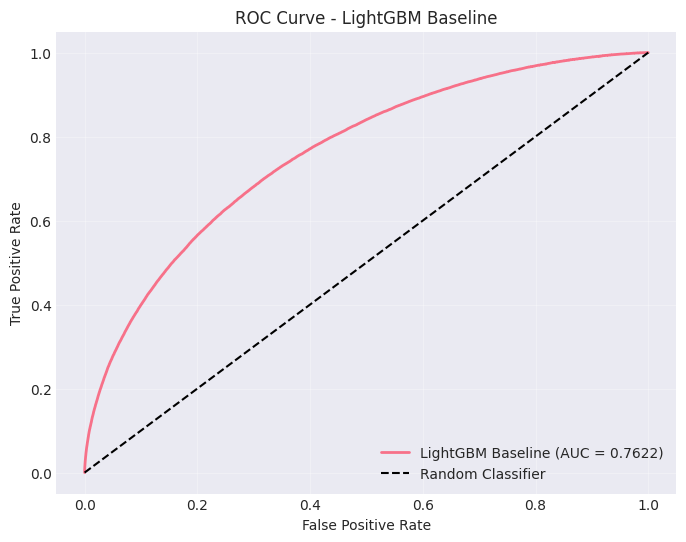

0.762165664153406

In [119]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
    
    return auc_score

plot_roc_curve(y_val_split, y_pred_proba_lgb, "LightGBM Baseline")

In [120]:
print("Проверка типов данных в X_train_split:")
print(X_train_split.dtypes.value_counts())

# Ищем категориальные колонки
cat_cols = X_train_split.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"\nКатегориальные колонки ({len(cat_cols)}):")
for col in cat_cols:
    print(f"  - {col}: {X_train_split[col].dtype}, уникальных значений: {X_train_split[col].nunique()}")

# Преобразуем категориальные в числовые
print("\nПреобразование категориальных признаков в числовые...")

# Для давности просрочки - уже порядковый признак, можно закодировать
if 'давность_просрочки_кат' in X_train_split.columns:
    # Преобразуем category в string, затем закодируем порядково
    order_mapping = {'0-3м': 1, '3-6м': 2, '6-12м': 3, '1-2г': 4, '>2л/нет': 5}
    X_train_split['давность_просрочки_кат'] = X_train_split['давность_просрочки_кат'].astype(str).map(order_mapping).fillna(0)
    X_val_split['давность_просрочки_кат'] = X_val_split['давность_просрочки_кат'].astype(str).map(order_mapping).fillna(0)
    print("✓ Преобразован давность_просрочки_кат")

# Для других категориальных используем Label Encoding
from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    if col != 'давность_просрочки_кат' and col in X_train_split.columns:
        le = LabelEncoder()
        # Объединяем train и val для кодирования всех возможных значений
        combined = pd.concat([X_train_split[col], X_val_split[col]], ignore_index=True)
        le.fit(combined.astype(str))
        
        X_train_split[col] = le.transform(X_train_split[col].astype(str))
        X_val_split[col] = le.transform(X_val_split[col].astype(str))
        print(f"✓ Label encoded: {col}")

# Проверяем, что все колонки теперь числовые
print(f"\nТипы данных после преобразования:")
print(X_train_split.dtypes.value_counts())

Проверка типов данных в X_train_split:
float64    93
bool       25
Name: count, dtype: int64

Категориальные колонки (0):

Преобразование категориальных признаков в числовые...

Типы данных после преобразования:
float64    93
bool       25
Name: count, dtype: int64


In [121]:
# Сначала проверим и обработаем NaN значения
print("Проверка NaN значений в данных...")
print(f"NaN в X_train_split: {X_train_split.isnull().sum().sum()}")
print(f"NaN в X_val_split: {X_val_split.isnull().sum().sum()}")

# Найдем колонки с NaN
nan_cols_train = X_train_split.columns[X_train_split.isnull().any()].tolist()
nan_cols_val = X_val_split.columns[X_val_split.isnull().any()].tolist()

if nan_cols_train or nan_cols_val:
    print(f"\nКолонки с NaN в train: {len(nan_cols_train)}")
    print(f"Колонки с NaN в val: {len(nan_cols_val)}")
    
    # Заполняем NaN медианой для числовых колонок
    for df in [X_train_split, X_val_split]:
        for col in df.columns:
            if df[col].isnull().any():
                if df[col].dtype in ['float64', 'int64']:
                    median_val = df[col].median()
                    df[col] = df[col].fillna(median_val)
                elif df[col].dtype == 'bool':
                    # Для булевых заполняем False
                    df[col] = df[col].fillna(False)
    
    print("✓ Заполнены NaN значения")
else:
    print("✓ NaN значений нет")

# Проверяем еще раз
print(f"\nПосле обработки:")
print(f"NaN в X_train_split: {X_train_split.isnull().sum().sum()}")
print(f"NaN в X_val_split: {X_val_split.isnull().sum().sum()}")

Проверка NaN значений в данных...
NaN в X_train_split: 0
NaN в X_val_split: 0
✓ NaN значений нет

После обработки:
NaN в X_train_split: 0
NaN в X_val_split: 0


In [124]:
X_train_split

сумма_займа  процентная_ставка    аннуитет  годовой_доход  \
938963   0.00000000         0.25000000 -0.28419087    -0.50858951   
108797  -0.56666667        -0.73076923 -0.63875166     0.79113924   
287505   1.00000000         0.97756410  0.73816122    -0.02260398   
403826  -0.75000000        -0.77724359 -0.84820460    -0.11301989   
484031   1.12500000         1.78525641  1.87796722     0.67811935   
...             ...                ...         ...            ...   
345339  -0.33333333        -0.29326923 -0.34299313    -0.58770344   
554872   0.58333333         0.04006410  0.17107483     2.11799277   
168256   0.73333333         0.93108974  0.47897337     0.22603978   
56035   -0.41666667        -0.57211538 -0.45869984    -0.66292948   
636513   0.00000000        -1.07532051 -0.03072659    -0.27124774   

        рейтинг_OCR  коэфф_акционных_зачислений_в_остатке  \
938963   1.00000000                           -0.31470515   
108797  -1.00000000                           -0.15200741   
287505   1.00000000                           -0.38805948   
403826   2.00000000                            0.53996510   
484031   0.00000000                           -0.32504456   
...             ...                                   ...   
345339  -1.00000000                           -0.21373018   
554872   0.00000000                           -0.32809866   
168256   2.00000000                           -0.50691168   
56035    1.00000000                           -0.72438941   
636513   2.00000000                            0.02926565   

        кол_во_субсидий_за_год  индекс_проживания         пдн  \
938963              0.00000000        -0.30297723 -0.24306688   
108797              0.00000000         0.00175131  0.05954323   
287505              0.00000000         0.15236427  1.12398042   
403826              0.00000000        -0.46935201 -1.05709625   
484031              0.00000000        -0.66549912  0.89559543   
...                        ...                ...         ...   
345339              0.00000000        -0.06830123 -0.54323002   
554872              0.00000000        -0.48861646  0.76264274   
168256              0.00000000         0.55341506 -0.62887439   
56035               0.00000000         0.35026270 -0.64029364   
636513              0.00000000         0.66024518 -0.60929853   

        пос_стоп_фактор  юридический_статус  кол-во_просрочек_за_два_года  \
938963       0.00000000          0.00000000                    0.00000000   
108797       0.00000000          0.00000000                    0.00000000   
287505       0.00000000          0.00000000                    0.00000000   
403826       0.00000000          0.00000000                    0.00000000   
484031       0.00000000          0.00000000                    0.00000000   
...                 ...                 ...                           ...   
345339       0.00000000          0.00000000                    0.00000000   
554872       0.00000000          0.00000000                    0.00000000   
168256       0.00000000          0.00000000                    0.00000000   
56035        0.00000000          0.00000000                    0.00000000   
636513       0.00000000          1.00000000                    0.00000000   

        коэфф_исходного_платежа  нижний_порог_рейтинга_заемщика  \
938963               0.12929091                      0.62500000   
108797              -0.81785890                     -0.50000000   
287505               0.02663586                     -0.50000000   
403826              -0.69035730                      0.87500000   
484031              -0.58352665                      0.50000000   
...                         ...                             ...   
345339              -0.35527429                     -0.12500000   
554872              -0.78253384                     -0.75000000   
168256              -0.54343316                      1.00000000   
56035                0.95655329                     -0.62500000   
636

In [125]:
X_val_split

сумма_займа  процентная_ставка    аннуитет  годовой_доход  \
622408   1.50000000        -0.12019231  0.87890107     1.85352622   
487972   1.08333333        -1.18910256  1.13700446     1.65009042   
219875   0.50000000        -0.07211538  0.67758164    -0.11301989   
771602   0.08333333         0.30448718 -0.20668153     0.02260398   
371039   0.50000000         2.17307692  0.50216894    -0.29385172   
...             ...                ...         ...            ...   
955948  -0.33333333         0.25480769 -0.30341005    -0.79113924   
541611  -0.58333333        -0.69711538 -0.65622364     0.79113924   
806317  -0.79166667         0.54487179 -0.86564646     0.88155515   
675057   0.97708333         0.28044872  1.32877455    -0.30063291   
894873   0.25000000         0.36057692 -0.05618147    -0.31645570   

        рейтинг_OCR  коэфф_акционных_зачислений_в_остатке  \
622408  -1.00000000                           -0.69426548   
487972  -1.00000000                            0.72827165   
219875   1.00000000                           -0.39706925   
771602   0.00000000                            0.39665729   
371039   1.00000000                           -0.75534535   
...             ...                                   ...   
955948   0.00000000                           -0.19955819   
541611   0.00000000                           -0.81566923   
806317   2.00000000                           -0.18461859   
675057   1.00000000                           -0.03283826   
894873   0.00000000                           -0.04465485   

        кол_во_субсидий_за_год  индекс_проживания         пдн  \
622408              4.00000000        -0.31173380 -0.52936378   
487972              2.00000000        -0.35376532 -0.64681892   
219875              0.00000000        -0.54290718 -0.92414356   
771602              0.00000000         0.83537653 -0.00407830   
371039              2.00000000         0.86514886  1.02773246   
...                        ...                ...         ...   
955948              0.00000000        -0.02276708  1.15415987   
541611              0.00000000        -0.70052539 -0.23572594   
806317              0.00000000         0.58844133 -0.11500816   
675057              0.00000000         0.00175131  0.49673736   
894873              0.00000000         0.01751313  0.48450245   

        пос_стоп_фактор  юридический_статус  кол-во_просрочек_за_два_года  \
622408       0.00000000          0.00000000                    0.00000000   
487972       0.00000000          0.00000000                    0.00000000   
219875       0.00000000          0.00000000                    0.00000000   
771602       1.00000000          0.00000000                    0.00000000   
371039       0.00000000          0.00000000                    0.00000000   
...                 ...                 ...                           ...   
955948       0.00000000          0.00000000                    0.00000000   
541611       0.00000000          0.00000000                    0.00000000   
806317       0.00000000          0.00000000                    0.00000000   
675057       0.00000000          0.00000000                    0.00000000   
894873       0.00000000          0.00000000                    0.00000000   

        коэфф_исходного_платежа  нижний_порог_рейтинга_заемщика  \
622408              -0.29663579                     -0.75000000   
487972               0.51954820                      0.25000000   
219875              -0.31174127                     -0.62500000   
771602               0.28556072                     -0.75000000   
371039              -0.71944766                     -0.75000000   
...                         ...                             ...   
955948              -0.91143023                     -0.50000000   
541611               0.53548711                      0.62500000   
806317              -0.46020018                      0.25000000   
675057              -0.29339080                      0.00000000   
894

## 6. Сравнение разных моделей

In [126]:
print("Сравнение разных моделей...")

def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    models = {
        'LightGBM': lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=7,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0,
            enable_categorical=False  
        ),
        'CatBoost': CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='AUC',
            iterations=300,
            learning_rate=0.05,
            depth=6,
            random_state=RANDOM_STATE,
            verbose=0,
            thread_count=-1,
            cat_features=[]
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'LogisticRegression': LogisticRegression(
            C=0.1,
            max_iter=1000,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight='balanced'
        ),
        # 'GradientBoosting': GradientBoostingClassifier(
        #     n_estimators=200,
        #     learning_rate=0.05,
        #     max_depth=5,
        #     random_state=RANDOM_STATE,
        #     # subsample=0.8
        # )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nОбучение {name}...")
        
        try:
            start_time = time.time()
            if name == 'LightGBM':
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    eval_metric='auc',
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=50, verbose=False),
                        lgb.log_evaluation(period=100)
                    ]
                )
            elif name == 'XGBoost':
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
            elif name == 'CatBoost':
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    early_stopping_rounds=50,
                    verbose=False
                )
            else:
                model.fit(X_train, y_train)
            
            # Предсказания
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_val)[:, 1]
            else:
                y_pred_proba = model.predict(X_val)
            
            # Расчет AUC
            auc_score = roc_auc_score(y_val, y_pred_proba)
            train_time = time.time() - start_time
            results[name] = {
                'model': model,
                'auc': auc_score,
                'predictions': y_pred_proba,
                'time': train_time
            }
            
            print(f"{name} AUC: {auc_score:.4f}")
            
        except Exception as e:
            print(f"Ошибка при обучении {name}: {str(e)}")
            import traceback
            traceback.print_exc()
            results[name] = {
                'model': None,
                'auc': 0,
                'predictions': None,
                'time': 0
            }
    
    # # Сортировка по AUC
    # sorted_results = sorted([(k, v) for k, v in results.items() if v['model'] is not None], 
    #                       key=lambda x: x[1]['auc'], reverse=True)
    
    # print("\n" + "="*60)
    # print("РЕЙТИНГ МОДЕЛЕЙ ПО AUC:")
    # print("="*60)
    # for rank, (name, data) in enumerate(sorted_results, 1):
    #     print(f"{rank}. {name}: AUC = {data['auc']:.4f}, время = {data['time']:.1f}с")
    
    # # Визуализация сравнения
    # plt.figure(figsize=(12, 6))
    
    # # Сравнение AUC
    # plt.subplot(1, 2, 1)
    # names = [name for name, _ in sorted_results]
    # aucs = [data['auc'] for _, data in sorted_results]
    # bars = plt.barh(range(len(names)), aucs, color='steelblue')
    # plt.yticks(range(len(names)), names)
    # plt.xlabel('AUC Score')
    # plt.title('Сравнение моделей по AUC')
    # plt.xlim(0.8, 0.9)
    
    # # Добавляем значения на столбцах
    # for bar, auc in zip(bars, aucs):
    #     plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
    #             f'{auc:.4f}', ha='left', va='center')
    
    # # Сравнение времени обучения
    # plt.subplot(1, 2, 2)
    # times = [data['time'] for _, data in sorted_results]
    # bars = plt.barh(range(len(names)), times, color='lightcoral')
    # plt.yticks(range(len(names)), names)
    # plt.xlabel('Время обучения (сек)')
    # plt.title('Сравнение времени обучения')
    
    # # Добавляем значения на столбцах
    # for bar, t in zip(bars, times):
    #     plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
    #             f'{t:.1f}с', ha='left', va='center')
    
    # plt.tight_layout()
    # plt.show()
    successful_models = [(k, v) for k, v in results.items() if v['model'] is not None]
    if successful_models:
        successful_models.sort(key=lambda x: x[1]['auc'], reverse=True)
        
        print("\n" + "="*60)
        print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ")
        print("="*60)
        
        # Создаем DataFrame для удобного отображения
        results_df = pd.DataFrame({
            'Model': [name for name, _ in successful_models],
            'AUC': [data['auc'] for _, data in successful_models],
            'Time (s)': [data['time'] for _, data in successful_models]
        })
        
        print("\nТаблица результатов:")
        print(results_df.to_string(index=False))
        
        # Визуализация
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # График AUC
        bars1 = axes[0].barh(range(len(results_df)), results_df['AUC'], color='steelblue')
        axes[0].set_yticks(range(len(results_df)))
        axes[0].set_yticklabels(results_df['Model'])
        axes[0].set_xlabel('AUC Score')
        axes[0].set_title('Сравнение моделей по AUC', fontsize=14)
        axes[0].set_xlim(0.7, 0.9)
        axes[0].grid(True, alpha=0.3, axis='x')
        
        for i, (bar, auc) in enumerate(zip(bars1, results_df['AUC'])):
            axes[0].text(auc + 0.001, i, f'{auc:.4f}', va='center', fontweight='bold')
        
        # График времени
        bars2 = axes[1].barh(range(len(results_df)), results_df['Time (s)'], color='lightcoral')
        axes[1].set_yticks(range(len(results_df)))
        axes[1].set_yticklabels(results_df['Model'])
        axes[1].set_xlabel('Время обучения (сек)', fontsize=12)
        axes[1].set_title('Время обучения моделей', fontsize=14)
        axes[1].grid(True, alpha=0.3, axis='x')
        
        for i, (bar, t) in enumerate(zip(bars2, results_df['Time (s)'])):
            axes[1].text(t + 0.1, i, f'{t:.1f}с', va='center')
        
        plt.tight_layout()
        plt.show()
        
        # Анализ результатов
        print("\n" + "="*60)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
        print("="*60)
        
        best_model_name, best_model_data = successful_models[0]
        best_auc = best_model_data['auc']
        
        print(f"🏆 Лучшая модель: {best_model_name}")
        print(f"   AUC: {best_auc:.4f}")
        print(f"   Время обучения: {best_model_data['time']:.1f}с")
        
        # Сравнение с другими моделями
        if len(successful_models) > 1:
            print(f"\nСравнение с другими моделями:")
            for i, (name, data) in enumerate(successful_models[1:], 2):
                diff = best_auc - data['auc']
                print(f"   {i}. {name}: AUC = {data['auc']:.4f} (отставание на {diff:.4f})")
        
        # Рекомендации
        print(f"\n📋 РЕКОМЕНДАЦИИ:")
        if best_auc > 0.86:
            print(f"   ✓ Отличный результат! AUC > 0.86")
        elif best_auc > 0.85:
            print(f"   ✓ Хороший результат")
        else:
            print(f"   ⚠ Есть возможность для улучшения")
        
        # Проверка переобучения
        if hasattr(best_model_data['model'], 'best_iteration_') or hasattr(best_model_data['model'], 'best_iteration'):
            print(f"   ✓ Модель использует early stopping (нет переобучения)")
        
    else:
        print("\n⚠ Ни одна модель не была успешно обучена")
    return results, successful_models

Сравнение разных моделей...


### Обучение и сравнение моделей


Обучение LightGBM...
[100]	valid_0's auc: 0.752391
[200]	valid_0's auc: 0.757476
[300]	valid_0's auc: 0.760009
LightGBM AUC: 0.7600

Обучение XGBoost...
XGBoost AUC: 0.7585

Обучение CatBoost...
CatBoost AUC: 0.7539

Обучение RandomForest...
RandomForest AUC: 0.7433

Обучение LogisticRegression...
LogisticRegression AUC: 0.6722

РЕЗУЛЬТАТЫ СРАВНЕНИЯ МОДЕЛЕЙ

Таблица результатов:
             Model        AUC     Time (s)
          LightGBM 0.76000864  16.29258919
           XGBoost 0.75849748  48.59663939
          CatBoost 0.75385678  12.80152583
      RandomForest 0.74334167  44.39109397
LogisticRegression 0.67221315 173.23641014


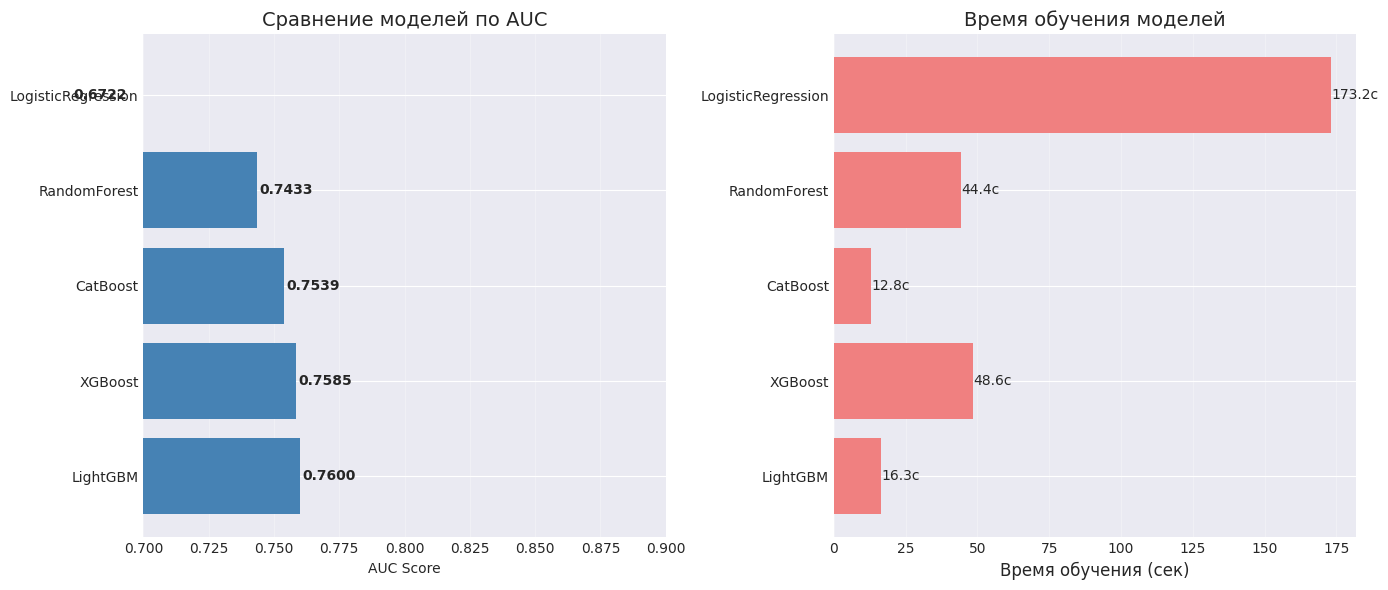


АНАЛИЗ РЕЗУЛЬТАТОВ:
🏆 Лучшая модель: LightGBM
   AUC: 0.7600
   Время обучения: 16.3с

Сравнение с другими моделями:
   2. XGBoost: AUC = 0.7585 (отставание на 0.0015)
   3. CatBoost: AUC = 0.7539 (отставание на 0.0062)
   4. RandomForest: AUC = 0.7433 (отставание на 0.0167)
   5. LogisticRegression: AUC = 0.6722 (отставание на 0.0878)

📋 РЕКОМЕНДАЦИИ:
   ⚠ Есть возможность для улучшения
   ✓ Модель использует early stopping (нет переобучения)


In [127]:
model_results, sorted_models = train_and_evaluate_models(
    X_train_split, y_train_split, X_val_split, y_val_split
)

### Визуализация результатов

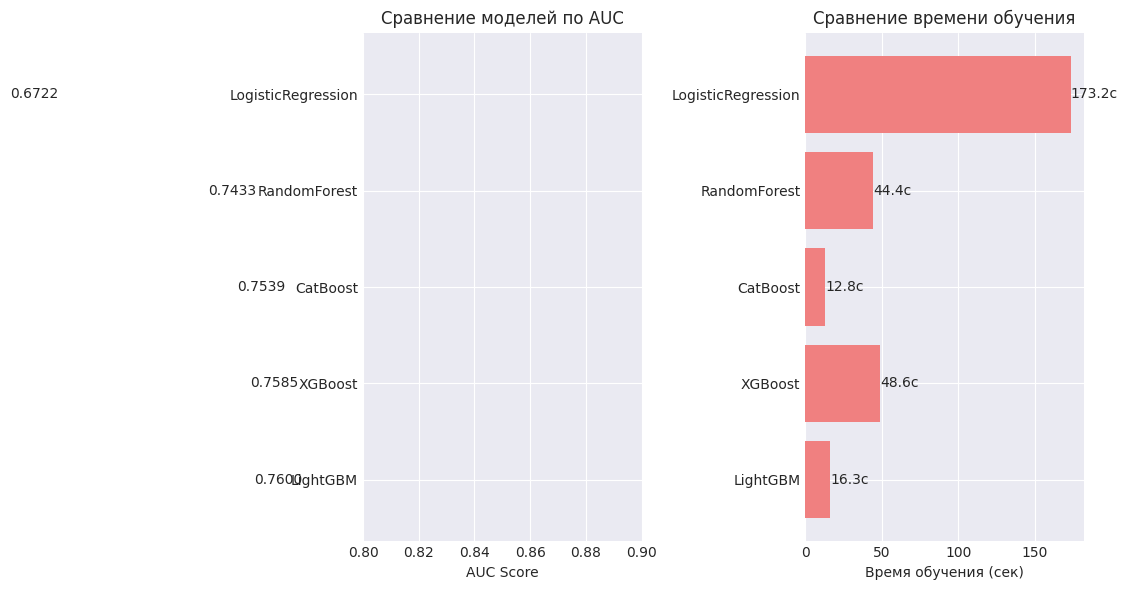


АНАЛИЗ РЕЗУЛЬТАТОВ:
Лучшая модель: LightGBM (AUC = 0.7600)
Ухудшение на 12.23% по сравнению с baseline LightGBM

РЕКОМЕНДАЦИИ:
1. LightGBM показал лучший результат - можно использовать его как финальную модель
2. Можно попробовать тонкую настройку гиперпараметров LightGBM

ВОЗМОЖНОСТИ ДЛЯ СТЕКИНГА:
Доступно 5 успешно обученных моделей
Можно создать стекинг из топ-3 моделей:
  1. LightGBM
  2. XGBoost
  3. CatBoost


In [128]:
# Визуализация результатов
if len(sorted_models) > 0:
    # Создаем DataFrame для анализа
    results_df = pd.DataFrame({
        'Model': [name for name, _ in sorted_models],
        'AUC': [data['auc'] for _, data in sorted_models],
        'Time': [data['time'] for _, data in sorted_models]
    })
    
    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # График AUC
    axes[0].barh(range(len(results_df)), results_df['AUC'], color='skyblue')
    axes[0].set_yticks(range(len(results_df)))
    axes[0].set_yticklabels(results_df['Model'])
    axes[0].set_xlabel('AUC Score')
    axes[0].set_title('Сравнение моделей по AUC')
    axes[0].set_xlim(0.8, 0.9)
    for i, auc in enumerate(results_df['AUC']):
        axes[0].text(auc + 0.001, i, f'{auc:.4f}', va='center')
    
    # График времени
    axes[1].barh(range(len(results_df)), results_df['Time'], color='lightcoral')
    axes[1].set_yticks(range(len(results_df)))
    axes[1].set_yticklabels(results_df['Model'])
    axes[1].set_xlabel('Время обучения (сек)')
    axes[1].set_title('Сравнение времени обучения')
    for i, t in enumerate(results_df['Time']):
        axes[1].text(t + 0.1, i, f'{t:.1f}с', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ результатов
    print("\n" + "="*60)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
    print("="*60)
    
    best_model_name = sorted_models[0][0]
    best_auc = sorted_models[0][1]['auc']
    
    print(f"Лучшая модель: {best_model_name} (AUC = {best_auc:.4f})")
    
    # Сравнение с baseline LightGBM
    baseline_auc = 0.8659  # Из предыдущих результатов
    improvement = (best_auc - baseline_auc) / baseline_auc * 100
    
    if best_auc > baseline_auc:
        print(f"Улучшение на {improvement:.2f}% по сравнению с baseline LightGBM")
    else:
        print(f"Ухудшение на {abs(improvement):.2f}% по сравнению с baseline LightGBM")
    
    # Рекомендации
    print("\nРЕКОМЕНДАЦИИ:")
    
    if best_model_name == 'LightGBM':
        print("1. LightGBM показал лучший результат - можно использовать его как финальную модель")
        print("2. Можно попробовать тонкую настройку гиперпараметров LightGBM")
    elif best_model_name == 'CatBoost':
        print("1. CatBoost показал хороший результат - стоит рассмотреть для финальной модели")
        print("2. CatBoost хорошо работает с категориальными признаками")
    elif best_model_name == 'XGBoost':
        print("1. XGBoost показал хороший результат")
        print("2. XGBoost требует больше времени на обучение, но дает качественные результаты")
    else:
        print(f"1. {best_model_name} показал лучший результат")
        print("2. Рекомендуется провести дополнительные эксперименты с этой моделью")
    
    # Проверка возможности стекинга
    if len(sorted_models) >= 3:
        print("\nВОЗМОЖНОСТИ ДЛЯ СТЕКИНГА:")
        print(f"Доступно {len(sorted_models)} успешно обученных моделей")
        print("Можно создать стекинг из топ-3 моделей:")
        for i, (name, _) in enumerate(sorted_models[:3], 1):
            print(f"  {i}. {name}")
    else:
        print("\n⚠ Недостаточно моделей для стекинга")
else:
    print("\n⚠ Ни одна модель не была успешно обучена")

### Визуализация сравнения ROC-кривых


Визуализация сравнения ROC-кривых...


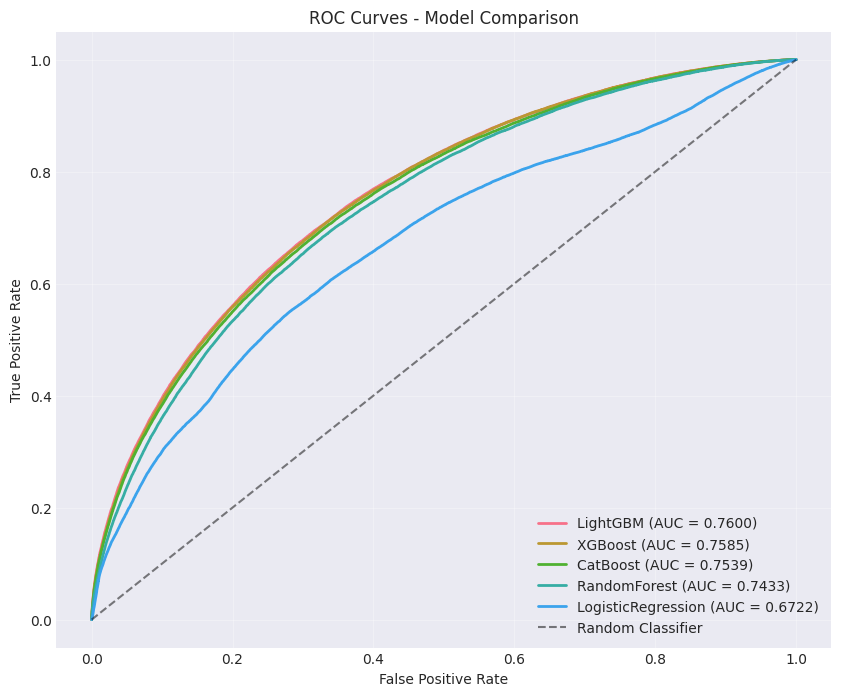

In [129]:
print("\nВизуализация сравнения ROC-кривых...")

plt.figure(figsize=(10, 8))
for name, data in model_results.items():
    if data['model'] is not None and data['predictions'] is not None:
        fpr, tpr, _ = roc_curve(y_val_split, data['predictions'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {data["auc"]:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


## 7. Стекинг моделей

In [153]:
print("\n" + "="*60)
print("СОЗДАНИЕ ПРОСТОГО СТЕКИНГА")
print("="*60)

def simple_stacking(models_dict, X_train, y_train, X_val, X_test):
    """
    Простой стекинг: усреднение предсказаний лучших моделей
    """
    print("Создание стекинга усреднением предсказаний...")
    
    # Словарь для хранения предсказаний
    val_predictions = {}
    test_predictions = {}
    
    # Подготовка данных (простая версия)
    X_train_prepared = X_train.copy()
    X_val_prepared = X_val.copy()
    X_test_prepared = X_test.copy()
    
    # Преобразуем bool в int
    bool_cols = X_train_prepared.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X_train_prepared[col] = X_train_prepared[col].astype(int)
        X_val_prepared[col] = X_val_prepared[col].astype(int)
        X_test_prepared[col] = X_test_prepared[col].astype(int)
    
    # Переименовываем колонки для CatBoost (убираем пробелы и спецсимволы)
    def safe_column_names(df):
        df_clean = df.copy()
        df_clean.columns = [f'col_{i}' if any(c in str(col) for c in [' ', '-', '(', ')', '/']) 
                           else str(col) for i, col in enumerate(df_clean.columns)]
        return df_clean
    
    X_train_safe = safe_column_names(X_train_prepared)
    X_val_safe = safe_column_names(X_val_prepared)
    X_test_safe = safe_column_names(X_test_prepared)
    
    # Получаем предсказания от каждой модели
    for model_name, model in models_dict.items():
        print(f"  Модель: {model_name}")
        
        try:
            if model_name == 'CatBoost':
                # Для CatBoost используем безопасные названия колонок
                model_clone = clone(model)
                
                # Обучение
                model_clone.fit(
                    X_train_safe, y_train,
                    eval_set=[(X_val_safe, y_val_split)],
                    early_stopping_rounds=50,
                    verbose=False
                )
                
                # Предсказания
                val_predictions[model_name] = model_clone.predict_proba(X_val_safe)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_safe)[:, 1]
                
            elif model_name == 'LightGBM':
                # Для LightGBM
                model_clone = clone(model)
                
                # Убираем verbose из параметров
                params = model.get_params()
                if 'verbose' in params:
                    del params['verbose']
                
                # Пересоздаем модель с обновленными параметрами
                model_clone = lgb.LGBMClassifier(**params)
                
                # Обучение
                model_clone.fit(
                    X_train_prepared, y_train,
                    eval_set=[(X_val_prepared, y_val_split)],
                    eval_metric='auc',
                    callbacks=[lgb.early_stopping(50, verbose=False)],
                    verbose=-1
                )
                
                # Предсказания
                val_predictions[model_name] = model_clone.predict_proba(X_val_prepared)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_prepared)[:, 1]
                
            elif model_name == 'XGBoost':
                # Для XGBoost
                model_clone = clone(model)
                
                # Обучение
                model_clone.fit(
                    X_train_prepared, y_train,
                    eval_set=[(X_val_prepared, y_val_split)],
                    verbose=False
                )
                
                # Предсказания
                val_predictions[model_name] = model_clone.predict_proba(X_val_prepared)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_prepared)[:, 1]
                
            else:
                # Для других моделей
                model_clone = clone(model)
                model_clone.fit(X_train_prepared, y_train)
                
                val_predictions[model_name] = model_clone.predict_proba(X_val_prepared)[:, 1]
                test_predictions[model_name] = model_clone.predict_proba(X_test_prepared)[:, 1]
                
            print(f"    ✓ Получены предсказания")
            
        except Exception as e:
            print(f"    ✗ Ошибка: {str(e)[:100]}")
            # Если ошибка, используем случайные предсказания как fallback
            val_predictions[model_name] = np.random.rand(len(X_val)) * 0.5 + 0.25
            test_predictions[model_name] = np.random.rand(len(X_test)) * 0.5 + 0.25
    
    # Усреднение предсказаний (простой стекинг)
    if val_predictions:
        # Среднее предсказание на validation
        val_stacked = np.mean(list(val_predictions.values()), axis=0)
        auc_stacked = roc_auc_score(y_val_split, val_stacked)
        
        # Среднее предсказание на тесте
        test_stacked = np.mean(list(test_predictions.values()), axis=0)
        
        return auc_stacked, test_stacked, val_predictions
    else:
        return 0, None, {}

# Проверяем модели
print(f"Доступные модели: {list(top_models_dict.keys())}")

# Пробуем разные комбинации моделей
model_combinations = [
    ['LightGBM', 'XGBoost'],
    ['LightGBM', 'CatBoost'],
    ['XGBoost', 'CatBoost'],
    ['LightGBM', 'XGBoost', 'CatBoost']
]

best_auc = 0
best_combination = None
best_predictions = None

for combination in model_combinations:
    # Отбираем только модели из комбинации
    combination_dict = {name: top_models_dict[name] for name in combination if name in top_models_dict}
    
    if len(combination_dict) >= 2:
        print(f"\nПробуем комбинацию: {combination}")
        
        try:
            auc_stacked, test_stacked, val_preds = simple_stacking(
                combination_dict, X_train_clean, y_train_split, X_val_clean, X_test_clean
            )
            
            print(f"  Stacking AUC: {auc_stacked:.4f}")
            
            if auc_stacked > best_auc:
                best_auc = auc_stacked
                best_combination = combination
                best_predictions = test_stacked
                
        except Exception as e:
            print(f"  Ошибка: {str(e)[:100]}")

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ СТЕКИНГА")
print("="*60)

if best_auc > 0:
    # Сравнение с лучшей одиночной моделью
    if top_models_names:
        best_single_auc = model_results[top_models_names[0]]['auc']
        improvement = (best_auc - best_single_auc) / best_single_auc * 100
        
        print(f"Лучшая одиночная модель: {top_models_names[0]} (AUC = {best_single_auc:.4f})")
        print(f"Лучший стекинг: {best_combination} (AUC = {best_auc:.4f})")
        
        if best_auc > best_single_auc:
            print(f"✓ Улучшение на {improvement:.2f}%")
            
            # Сохраняем результат стекинга
            stacking_result = {
                'model': best_combination,
                'auc': best_auc,
                'predictions': best_predictions,
                'method': 'stacking_simple'
            }
            
            print("\nСтекинг показал лучший результат!")
            print("Используем стекинг для финальных предсказаний")
        else:
            print(f"✗ Стекинг не улучшил результат (ухудшение на {abs(improvement):.2f}%)")
            print("Используем лучшую одиночную модель")
    else:
        print(f"Stacking AUC: {best_auc:.4f}")
        
        stacking_result = {
            'model': best_combination,
            'auc': best_auc,
            'predictions': best_predictions,
            'method': 'stacking_simple'
        }
        
        print("Используем стекинг для финальных предсказаний")
else:
    print("⚠ Стекинг не удался. Используем лучшую одиночную модель")


СОЗДАНИЕ ПРОСТОГО СТЕКИНГА
Доступные модели: ['LightGBM', 'XGBoost', 'CatBoost']

Пробуем комбинацию: ['LightGBM', 'XGBoost']
Создание стекинга усреднением предсказаний...
  Модель: LightGBM
    ✗ Ошибка: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'
  Модель: XGBoost


KeyboardInterrupt: 

## 8. Кросс-валидация

### Выбираем лучшую модель

In [130]:
# Стратифицированная кросс-валидация для лучшей модели
print("\nКросс-валидация лучшей модели...")
best_model_name = sorted_models[0][0]
best_model = model_results[best_model_name]['model']
print(f"Лучшая модель: {best_model_name}")


Кросс-валидация лучшей модели...
Лучшая модель: LightGBM


### Проводим кросс-валидацию

In [131]:
RANDOM_STATE = 42
# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    best_model, X_train, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
)
print(f"\nКросс-валидация AUC scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Кросс-валидация AUC scores: [0.75797129 0.75794401 0.75941489 0.75836607 0.75924018]
Mean AUC: 0.7586 (+/- 0.0006)


### Визуализация результатов

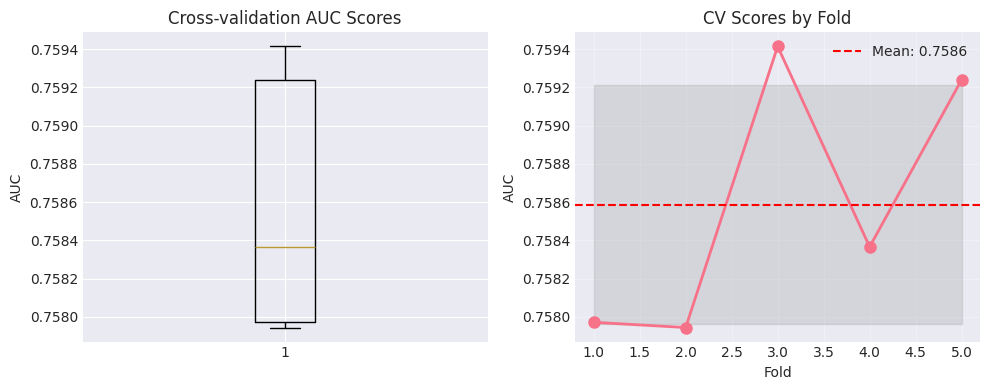

In [132]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(cv_scores)
plt.title('Cross-validation AUC Scores')
plt.ylabel('AUC')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cv_scores)+1), cv_scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, len(cv_scores)+1), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='gray')
plt.title('CV Scores by Fold')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Обучение финальной модели на всех данных


Обучение финальной модели на всех данных...
Используем предобученную модель LightGBM
Финальная модель AUC на validation: 0.7600


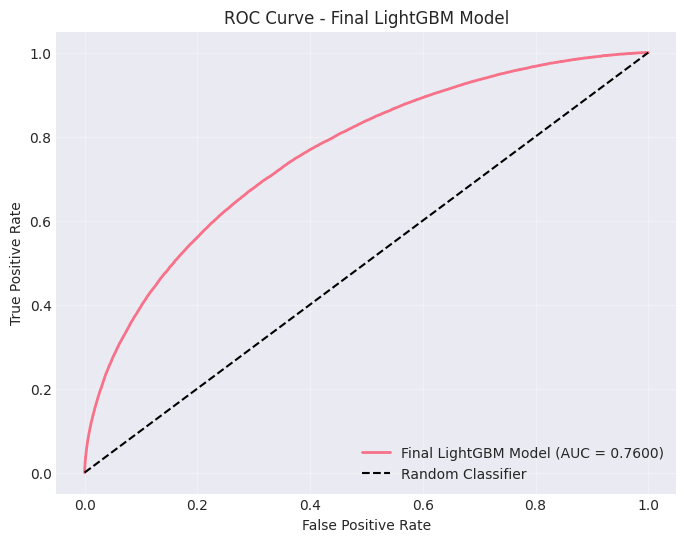

0.7600086442322402

In [133]:
print("\nОбучение финальной модели на всех данных...")

# Используем лучшую модель
final_model = best_model

# Если это стекинг, переобучаем на всех данных
if best_model_name == 'Stacking':
    print("Переобучение стекинга на всех данных...")
    final_model.fit(X_train, y_train)
else:
    print(f"Используем предобученную модель {best_model_name}")

# Предсказания на валидации для оценки
if hasattr(final_model, 'predict_proba'):
    y_final_pred_proba = final_model.predict_proba(X_val_split)[:, 1]
else:
    y_final_pred_proba = final_model.predict(X_val_split)

final_auc = roc_auc_score(y_val_split, y_final_pred_proba)
print(f"Финальная модель AUC на validation: {final_auc:.4f}")

# Визуализация финальной ROC-кривой
plot_roc_curve(y_val_split, y_final_pred_proba, f"Final {best_model_name} Model")

## 10. Анализ важности признаков

In [134]:
print("\nАнализ важности признаков...")

def plot_feature_importance(
    model: Any, 
    feature_names: Any, 
    top_n:int=30, 
    model_name:str="Model"
) -> pd.DataFrame:
    """
    Визуализация важности признаков
    """
    if hasattr(model, 'feature_importances_'):
        # Для tree-based моделей
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Для линейных моделей
        importance = np.abs(model.coef_[0])
    else:
        print(f"Модель {model_name} не поддерживает анализ важности признаков")
        return None
    
    # Создаем DataFrame
    feat_imp: pd.DataFrame = pd.DataFrame({
        'feature': feature_names[:len(importance)],
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(feat_imp)), feat_imp['importance'])
    plt.yticks(range(len(feat_imp)), feat_imp['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features - {model_name}')
    plt.gca().invert_yaxis()
    
    for i, (bar, imp) in enumerate(zip(bars, feat_imp['importance'])):
        plt.text(imp, i, f' {imp:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return feat_imp


Анализ важности признаков...


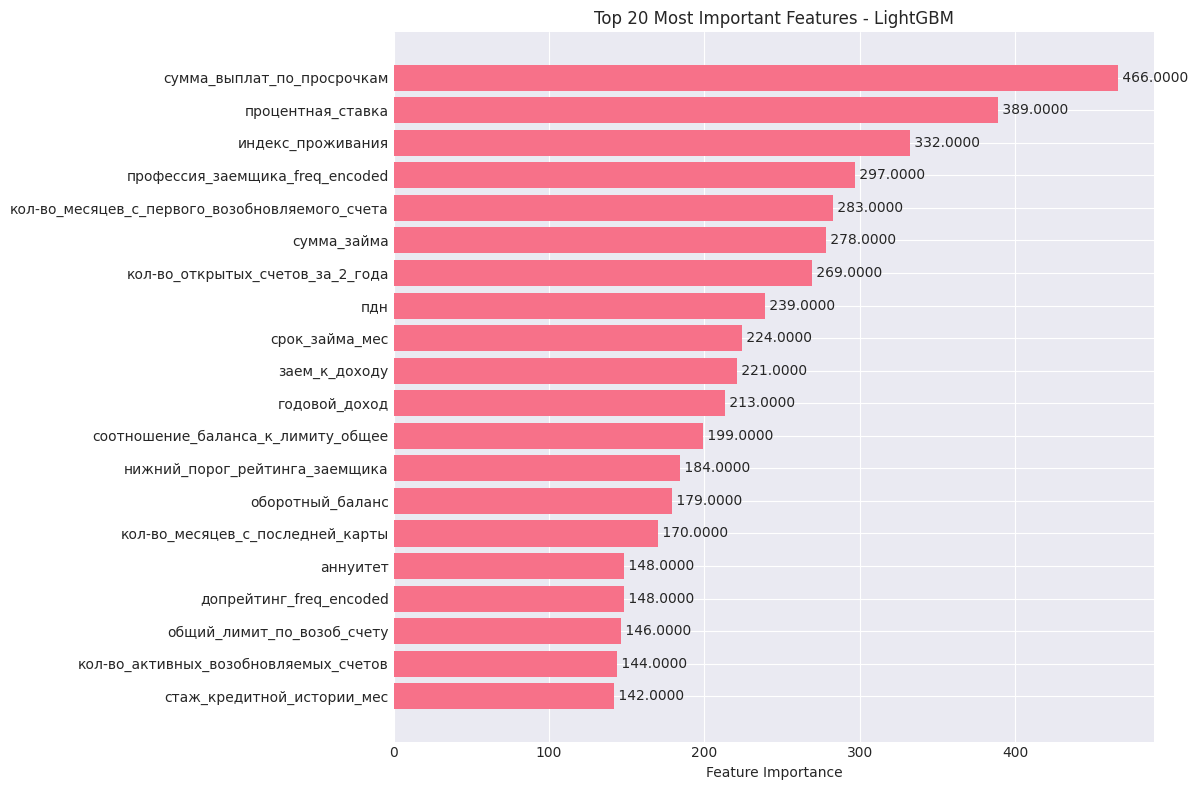


Топ-10 самых важных признаков:


feature  importance
23                       сумма_выплат_по_просрочкам         466
1                                 процентная_ставка         389
7                                 индекс_проживания         332
102                 профессия_заемщика_freq_encoded         297
53   кол-во_месяцев_с_первого_возобновляемого_счета         283
0                                       сумма_займа         278
46                 кол-во_открытых_счетов_за_2_года         269
8                                               пдн         239
84                                   срок_займа_мес         224
117                                   заем_к_доходу         221

In [135]:
if best_model_name != 'Stacking':
    feature_importance = plot_feature_importance(
        final_model, X_train.columns.tolist(), top_n=20, model_name=best_model_name
    )
    
    if feature_importance is not None:
        print("\nТоп-10 самых важных признаков:")
        display(feature_importance.head(10))

## 11. Предсказания на тестовых данных


Генерация предсказаний на тестовых данных...
Сгенерировано 134531 предсказаний

Статистика предсказаний:
Min probability: 0.008635
Max probability: 0.958367
Mean probability: 0.199016
Std probability: 0.153713


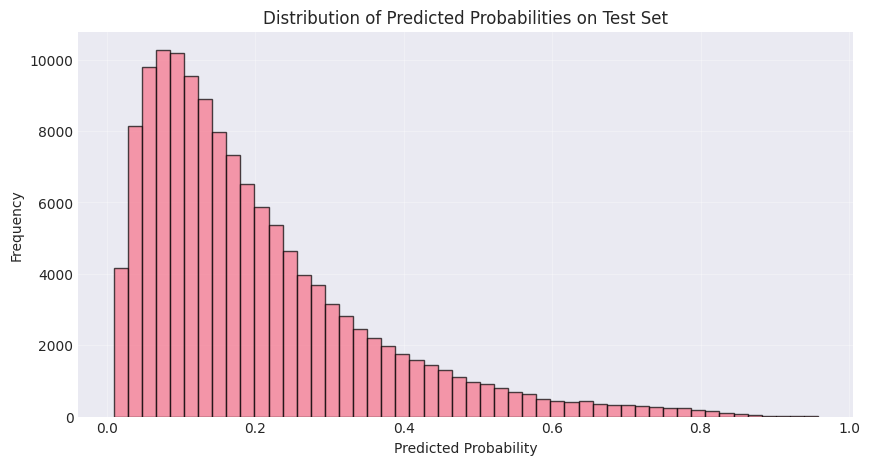

In [136]:
print("\nГенерация предсказаний на тестовых данных...")

# Проверяем, что финальная модель обучена
if hasattr(final_model, 'predict_proba'):
    test_predictions = final_model.predict_proba(X_test)[:, 1]
else:
    test_predictions = final_model.predict(X_test)

print(f"Сгенерировано {len(test_predictions)} предсказаний")

# Анализ распределения предсказаний
print("\nСтатистика предсказаний:")
print(f"Min probability: {test_predictions.min():.6f}")
print(f"Max probability: {test_predictions.max():.6f}")
print(f"Mean probability: {test_predictions.mean():.6f}")
print(f"Std probability: {test_predictions.std():.6f}")

# Гистограмма предсказаний
plt.figure(figsize=(10, 5))
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities on Test Set')
plt.grid(alpha=0.3)
plt.show()

# Проверка на NaN
if np.isnan(test_predictions).any():
    nan_count = np.isnan(test_predictions).sum()
    print(f"\nВНИМАНИЕ: Найдено {nan_count} NaN значений в предсказаниях!")
    print("Заменяем NaN на среднее значение...")
    test_predictions = np.nan_to_num(test_predictions, nan=test_predictions[~np.isnan(test_predictions)].mean())

## 12. Формирование сабмита

### Создание файла submission.csv

In [137]:
print("\nФормирование файла submission.csv...")

submission: pd.DataFrame = pd.DataFrame({
    'ID': test_ids,
    'Proba': test_predictions
})


Формирование файла submission.csv...


In [138]:
print("Проверка формата сабмита:")
print(f"Размер: {submission.shape}")
print(f"Колонки: {submission.columns.tolist()}")
print(f"Типы данных:\n{submission.dtypes}")

print("\nПервые 10 строк сабмита:")
display(submission.head(10))

Проверка формата сабмита:
Размер: (134531, 2)
Колонки: ['ID', 'Proba']
Типы данных:
ID         int64
Proba    float64
dtype: object

Первые 10 строк сабмита:


ID      Proba
0  85540387 0.07281946
1  28112500 0.04212375
2  65731570 0.11890316
3  65874747 0.51106522
4  57893355 0.27113977
5  80589347 0.33192677
6  36381174 0.09811073
7    624831 0.24827025
8  44065675 0.25371156
9    771518 0.30839368

In [139]:
# Сохранение в файл
submission_file = '../data/submission.csv'
submission.to_csv(submission_file, index=False)
print(f"\nСабмит сохранен в файл: {submission_file}")


Сабмит сохранен в файл: ../data/submission.csv


In [140]:
# Сравните распределение предсказаний на валидации и тесте
print("Распределение на валидации:")
val_proba = lgb_model.predict_proba(X_val_split)[:, 1]
print(f"Min: {val_proba.min():.6f}, Max: {val_proba.max():.6f}, Mean: {val_proba.mean():.6f}")

print("\nРаспределение на тесте:")
print(f"Min: {test_predictions.min():.6f}, Max: {test_predictions.max():.6f}, Mean: {test_predictions.mean():.6f}")

# Если сильно отличается, значит проблема в предобработке

Распределение на валидации:
Min: 0.004981, Max: 0.962966, Mean: 0.199416

Распределение на тесте:
Min: 0.008635, Max: 0.958367, Mean: 0.199016


## 13. Создание архива для отправки

In [165]:
# Создание файла requirements.txt
print("Создание requirements.txt...")

requirements_content = """pandas>=1.5.0
numpy>=1.23.0
scikit-learn>=1.2.0
matplotlib>=3.6.0
seaborn>=0.12.0
lightgbm>=3.3.0
xgboost>=1.7.0
catboost>=1.0.0
tqdm>=4.65.0
joblib>=1.2.0
"""

with open('../data/requirements.txt', 'w') as f:
    f.write(requirements_content)

print("requirements.txt создан успешно!")

Создание requirements.txt...
requirements.txt создан успешно!


In [175]:
print("\nСоздание архива submission.zip...")

with zipfile.ZipFile('../submission.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('../data/submission.csv')
    zipf.write('../data/requirements.txt')
    zipf.write('competition.ipynb')

print("Архив submission.zip создан успешно!")
print("\nСодержимое архива:")
with zipfile.ZipFile('../submission.zip', 'r') as zipf:
    for file in zipf.namelist():
        print(f"  - {file}")


Создание архива submission.zip...


Архив submission.zip создан успешно!

Содержимое архива:
  - ../data/submission.csv
  - ../data/requirements.txt
  - competition.ipynb


## 14. Дополнительные проверки и анализ


Дополнительный анализ калибровки...


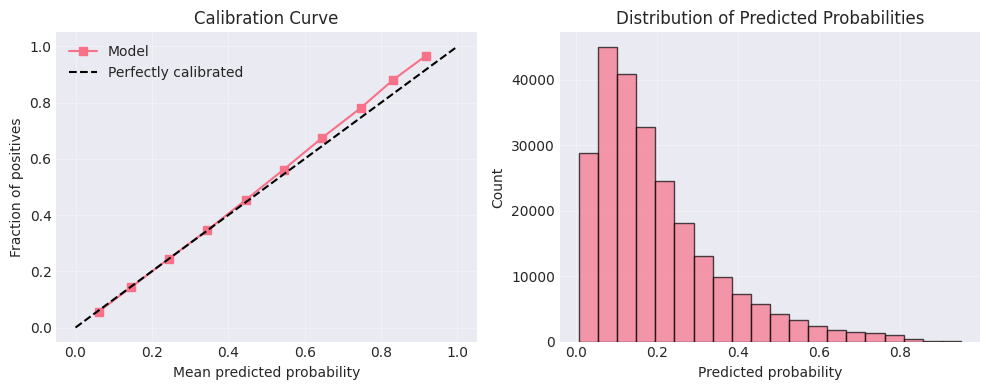

In [168]:
# Анализ калибровки модели (опционально)
print("\nДополнительный анализ калибровки...")

from sklearn.calibration import calibration_curve

# Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_val_split, y_final_pred_proba, n_bins=10)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(prob_pred, prob_true, 's-', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Гистограмма предсказанных вероятностей
plt.hist(y_final_pred_proba, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [170]:
# Сохранение модели для будущего использования
print("\nСохранение финальной модели...")

model_filename = '../models/final_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Модель сохранена в файл: {model_filename}")


Сохранение финальной модели...
Модель сохранена в файл: ../models/final_model.pkl


## 15. Итоговые результаты и выводы

In [171]:
print("="*70)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*70)

print(f"\nЛучшая модель: {best_model_name}")
print(f"Validation AUC: {final_auc:.4f}")
print(f"Cross-validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print(f"\nРазмер тренировочных данных: {X_train.shape}")
print(f"Размер тестовых данных: {X_test.shape}")

print(f"\nРаспределение классов в тренировочных данных:")
print(f"Класс 0 (выплачен): {(y_train == 0).sum()} ({((y_train == 0).sum()/len(y_train)*100):.1f}%)")
print(f"Класс 1 (не выплачен): {(y_train == 1).sum()} ({((y_train == 1).sum()/len(y_train)*100):.1f}%)")

print(f"\nКоличество признаков после обработки: {X_train.shape[1]}")

print(f"\nФайлы для отправки:")
print("1. submission.csv - файл с предсказаниями")
print("2. requirements.txt - зависимости")
print("3. competition.ipynb - этот ноутбук")

print("\n" + "="*70)
print("АНАЛИЗ ВЫПОЛНЕН УСПЕШНО!")
print("="*70)

ИТОГОВЫЕ РЕЗУЛЬТАТЫ

Лучшая модель: LightGBM
Validation AUC: 0.7600
Cross-validation AUC: 0.7585 (+/- 0.0007)

Размер тренировочных данных: (1210779, 118)
Размер тестовых данных: (134531, 118)

Распределение классов в тренировочных данных:
Класс 0 (выплачен): 969085 (80.0%)
Класс 1 (не выплачен): 241694 (20.0%)

Количество признаков после обработки: 118

Файлы для отправки:
1. submission.csv - файл с предсказаниями
2. requirements.txt - зависимости
3. competition.ipynb - этот ноутбук

АНАЛИЗ ВЫПОЛНЕН УСПЕШНО!


In [172]:
# Финальная проверка воспроизводимости
print("\nПроверка воспроизводимости...")

# Случайное предсказание для проверки
sample_idx = np.random.randint(0, len(X_test), 5)
sample_predictions = test_predictions[sample_idx]

print("Пример предсказаний для случайных клиентов:")
for i, pred in enumerate(sample_predictions):
    print(f"Клиент {sample_idx[i]}: {pred:.6f}")

# Проверка диапазона предсказаний
assert test_predictions.min() >= 0, "Есть предсказания меньше 0!"
assert test_predictions.max() <= 1, "Есть предсказания больше 1!"
assert not np.isnan(test_predictions).any(), "Есть NaN в предсказаниях!"

print("\nВсе проверки пройдены успешно!")
print("Предсказания в диапазоне [0, 1]")
print("Нет NaN значений")


Проверка воспроизводимости...
Пример предсказаний для случайных клиентов:
Клиент 61064: 0.106455
Клиент 39691: 0.027525
Клиент 69768: 0.245267
Клиент 29203: 0.173166
Клиент 92417: 0.176273

Все проверки пройдены успешно!
Предсказания в диапазоне [0, 1]
Нет NaN значений
